In [1]:
import os
import pickle as pkl
from joblib import load, dump
import cv2
import matplotlib
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm 
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7952363394386345592
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10080287813063474612
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 498049992309352205
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5136220160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17512338081153881318
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:

MODEL_LIST = []
MODEL_NAMES = ['skin_disease_resnet_No_AUG_88acc', 'resnet_model1_cifar10']

for i in range(len(MODEL_NAMES)):
    ### Loading DNN models 
    with open('Models/'+ MODEL_NAMES[i]+'.json', 'r') as j_file:
        loaded_model_json = j_file.read()
    model = tf.keras.models.model_from_json(loaded_model_json)
    model.load_weights("Models/"+MODEL_NAMES[i]+".h5")
    if (MODEL_NAMES[i] == 'skin_disease_resnet_No_AUG_88acc'):
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',
                      metrics=['acc'])
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                      loss = "categorical_crossentropy",  metrics= ['accuracy'])
    MODEL_LIST.append(model)



# Cifar 10

In [3]:
### Cifar model benchmark
def loadPreprocessCifar10():
    ### Load In Data
    (trainX, trainY), (testX, testY) = tf.keras.datasets.cifar10.load_data()
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return [trainX/255, trainY, testX/255, testY]
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

trainX, trainY, testX, testY = loadPreprocessCifar10()

In [4]:

extractor0  = tf.keras.Model(inputs = MODEL_LIST[0].input,
                         outputs = MODEL_LIST[0].get_layer(MODEL_LIST[0].layers[-5].name).output
                        )
extractor1  = tf.keras.Model(inputs = MODEL_LIST[1].input,
                         outputs = MODEL_LIST[1].get_layer(MODEL_LIST[1].layers[-5].name).output
                        )
### Predictions
#p = model1.predict(trainX,verbose = 1)
#print("Model Evaluation")
#MODEL_LIST[1].evaluate(testX, testY, verbose =1)

In [5]:
### Used to Extract features
"""
print("Extracting Features......")
print("May take a while")
feat0 = []
feat1 = []
for i in tqdm(range(len(trainX))):
    tmp = np.expand_dims(cv2.resize(trainX[i], (200,200)), axis = 0)
    feat0.append(extractor0.predict(tmp))
    feat1.append(extractor1.predict(np.expand_dims(trainX[i], axis = 0)))
"""    

'\nprint("Extracting Features......")\nprint("May take a while")\nfeat0 = []\nfeat1 = []\nfor i in tqdm(range(len(trainX))):\n    tmp = np.expand_dims(cv2.resize(trainX[i], (200,200)), axis = 0)\n    feat0.append(extractor0.predict(tmp))\n    feat1.append(extractor1.predict(np.expand_dims(trainX[i], axis = 0)))\n'

In [6]:
#np.save("data/train_feat0.npy", np.vstack(feat0))
#np.save("data/train_feat1.npy", np.vstack(feat1))
train_feat0 = np.load("data/train_feat0.npy")
train_feat1 = np.load("data/train_feat1.npy")

In [7]:
### Used to Extract features
"""print("Extracting Features......")
print("May take a while")
test_feat0 = []
test_feat1 = []
for i in tqdm(range(len(testX))):
    tmp = np.expand_dims(cv2.resize(testX[i], (200,200)), axis = 0)
    test_feat0.append(extractor0.predict(tmp))
    test_feat1.append(extractor1.predict(np.expand_dims(testX[i], axis = 0)))"""   

'print("Extracting Features......")\nprint("May take a while")\ntest_feat0 = []\ntest_feat1 = []\nfor i in tqdm(range(len(testX))):\n    tmp = np.expand_dims(cv2.resize(testX[i], (200,200)), axis = 0)\n    test_feat0.append(extractor0.predict(tmp))\n    test_feat1.append(extractor1.predict(np.expand_dims(testX[i], axis = 0)))'

In [8]:
### Load Testing features 
test_feat0 = np.load("data/test_feat0.npy")
test_feat1 = np.load("data/test_feat1.npy")
train_feat0 = np.load("data/train_feat0.npy")
train_feat1 = np.load("data/train_feat1.npy")

In [9]:
### Selecting the classes
hold_in_train_class = [0,1,2,3,4]
hold_in_train_class_idx = []
for i in hold_in_train_class:
    hold_in_train_class_idx = hold_in_train_class_idx + returnClassIndex(trainY,i)

In [10]:
### Selecting the classes
hold_in_test_class = [0,1,2,3,4]
hold_in_test_class_idx = []
for i in hold_in_test_class:
    hold_in_test_class_idx = hold_in_test_class_idx + returnClassIndex(testY,i)

In [11]:
from tensorflow.keras.layers import Dense, Input, GaussianNoise,  BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input

## Cifar Sub-Model 0

In [12]:
inputs = Input((128))
x = BatchNormalization()(inputs)
x = Dense(64, activation = tf.keras.layers.LeakyReLU())(x)
x = Dropout(0.5)(x)
x = Dense(32, activation = tf.keras.layers.LeakyReLU() )(x)
output = Dense(10, activation ='softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs = output)

In [13]:
op = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.0, nesterov=False, name="SGD",)
model.compile(optimizer = op, 
              loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 11,178
Trainable params: 10,922
Non-trainable params: 256
________________________________________________

In [14]:
mycallbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True),
    tf.keras.callbacks.TerminateOnNaN()
]
history = model.fit(train_feat1[hold_in_train_class_idx],trainY[hold_in_train_class_idx],
                    callbacks= mycallbacks, epochs = 1, verbose = 1,
                    validation_data = (test_feat1[hold_in_test_class_idx], 
                                       testY[hold_in_test_class_idx]) 
                   )

782/782 [==============================] - 1s 2ms/step - loss: 0.9234 - acc: 0.7387 - val_loss: 0.2621 - val_acc: 0.9494


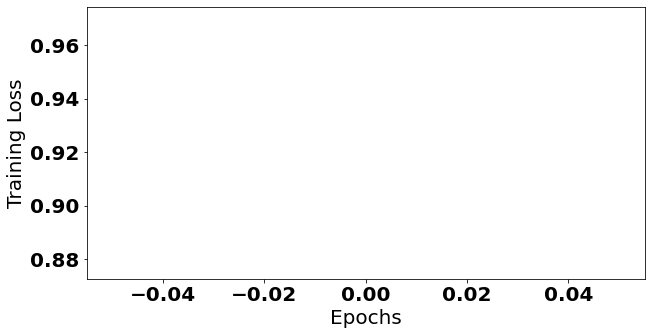

In [15]:
loss = history.history['loss']
ep = np.arange(len(loss))
font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 20}
matplotlib.rc('font', **font)
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

In [16]:
model.evaluate(test_feat1[hold_in_test_class_idx],testY[hold_in_test_class_idx])
model.save("Models/en_model.h5")

157/157 [==============================] - 0s 1ms/step - loss: 0.2621 - acc: 0.9494


# Cifar sub Model 1

In [17]:
inputs1 = Input((128))
x1 = BatchNormalization()(inputs1)
x1 = Dense(64, activation = 'elu')(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(32, activation = 'elu' )(x1)
output1 = Dense(10, activation ='softmax')(x1)
model1 = tf.keras.Model(inputs = inputs1, outputs = output1)

In [18]:
op1 = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop"
)
model1.compile(optimizer = op1, 
              loss = 'categorical_crossentropy', metrics = ['acc'])
model1.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 11,178
Trainable params: 10,922
Non-trainable params: 256
________________________________________________

In [19]:
mycallbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True),
    tf.keras.callbacks.TerminateOnNaN()
]
history1 = model1.fit(train_feat1[hold_in_train_class_idx],trainY[hold_in_train_class_idx],
                      callbacks= mycallbacks, epochs = 1, verbose = 1,
                      validation_data = (test_feat1[hold_in_test_class_idx],
                                         testY[hold_in_test_class_idx])
                     )

782/782 [==============================] - 2s 2ms/step - loss: 0.1056 - acc: 0.9734 - val_loss: 0.1324 - val_acc: 0.9656


In [20]:
model1.evaluate(test_feat1, testY)
model.save("Models/en_model1.h5")
print("Model is Saved!")

313/313 [==============================] - 0s 1ms/step - loss: 4.7637 - acc: 0.4828
Model is Saved!


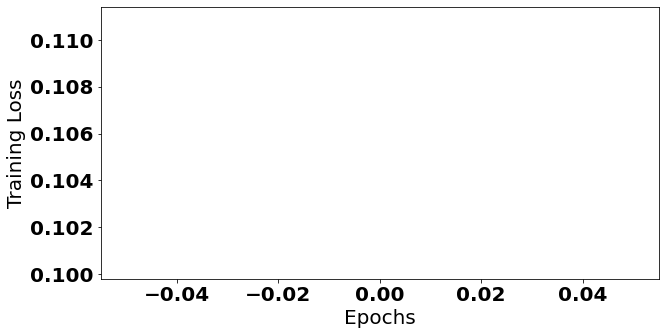

In [21]:
loss = history1.history['loss']
ep = np.arange(len(loss))
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

# Cifar Sub-Model 2

In [22]:
inputs2 = Input((128))
x2 = BatchNormalization()(inputs2)
x2 = Dense(64, activation = 'relu')(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(32, activation = 'relu' )(x2)
output2 = Dense(10, activation ='softmax')(x2)
model2 = tf.keras.Model(inputs = inputs2, outputs = output2)

In [23]:
op2 = tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad"
)
model2.compile(optimizer = op2, 
              loss = 'categorical_crossentropy', metrics = ['acc'])

In [24]:
model2.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 11,178
Trainable params: 10,922
Non-trainable params: 256
________________________________________________

In [25]:
history2 = model2.fit(train_feat1[hold_in_train_class_idx],trainY[hold_in_train_class_idx],
                      callbacks= mycallbacks, epochs = 1, verbose = 1,
                      validation_data = (test_feat1[hold_in_test_class_idx], 
                                         testY[hold_in_test_class_idx]) 
                     )
print("validation")
model2.evaluate(test_feat1[hold_in_test_class_idx],testY[hold_in_test_class_idx])

782/782 [==============================] - 1s 2ms/step - loss: 0.9751 - acc: 0.7338 - val_loss: 0.3268 - val_acc: 0.9518
validation
157/157 [==============================] - 0s 1ms/step - loss: 0.3268 - acc: 0.9518


[0.3267686069011688, 0.9517999887466431]

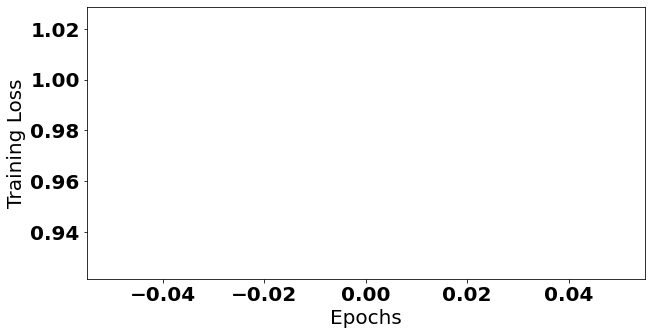

In [26]:
loss = history2.history['loss']
ep = np.arange(len(loss))
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

# Cifar Sub-Model 3

In [27]:

inputs3 = Input((128))
x3 = BatchNormalization()(inputs3)
x3 = Dense(64, activation = 'relu')(x3)
x3 = Dropout(0.5)(x3)
x3 = Dense(32, activation = 'relu' )(x3)
x3 = Dropout(0.5)(x3)
x3 = Dense(16, activation = 'relu' )(x3)
output3 = Dense(10, activation ='softmax')(x3)
model3 = tf.keras.Model(inputs = inputs3, outputs = output3)

In [28]:
model3.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
              loss = 'categorical_crossentropy', metrics = ['acc'])

In [29]:
model3.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)              

In [30]:
history3 = model3.fit(train_feat1[hold_in_train_class_idx],trainY[hold_in_train_class_idx],
                      callbacks= mycallbacks, epochs = 1, verbose = 1,
                      validation_data = (test_feat1[hold_in_test_class_idx], 
                                         testY[hold_in_test_class_idx]) 
                     )
model3.evaluate(test_feat1[hold_in_test_class_idx],testY[hold_in_test_class_idx])

157/157 [==============================] - 0s 1ms/step - loss: 0.1684 - acc: 0.9658


[0.16841557621955872, 0.9657999873161316]

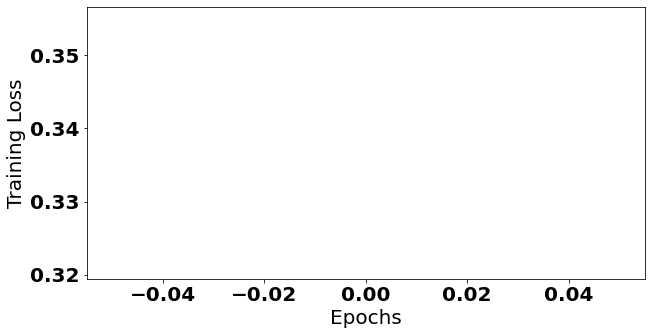

In [31]:
loss = history3.history['loss']
ep = np.arange(len(loss))
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

In [32]:
model3.evaluate(test_feat1[hold_in_test_class_idx],testY[hold_in_test_class_idx])
model.save("Models/en_model3.h5")
print("Model is Saved!")

157/157 [==============================] - 0s 1ms/step - loss: 0.1684 - acc: 0.9658
Model is Saved!


# Cifar Sub-Model 4

In [33]:
inputs4 = Input((128))
x4 = BatchNormalization()(inputs4)
x4 = Dense(64, activation = 'relu')(x4)
x4 = Dropout(0.7)(x4)
x4 = Dense(32, activation = 'relu' )(x4)
output4 = Dense(10, activation ='softmax')(x4)
model4 = tf.keras.Model(inputs = inputs4, outputs = output4)

In [34]:
model4.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
              loss = 'categorical_crossentropy', metrics = ['acc'])

In [35]:
model4.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                330       
Total params: 11,178
Trainable params: 10,922
Non-trainable params: 256
_______________________________________________

In [36]:
history4 = model4.fit(train_feat1[hold_in_train_class_idx],trainY[hold_in_train_class_idx], 
                      callbacks= mycallbacks,epochs = 1, verbose = 1, 
                  validation_data = (test_feat1[hold_in_test_class_idx], 
                                                      testY[hold_in_test_class_idx])
                     )

782/782 [==============================] - 1s 2ms/step - loss: 0.2316 - acc: 0.9354 - val_loss: 0.1533 - val_acc: 0.9674


In [37]:
model4.evaluate(test_feat1[hold_in_test_class_idx],testY[hold_in_test_class_idx])
model.save("Models/en_model4.h5")
print("Model is Saved!")

157/157 [==============================] - 0s 1ms/step - loss: 0.1533 - acc: 0.9674
Model is Saved!


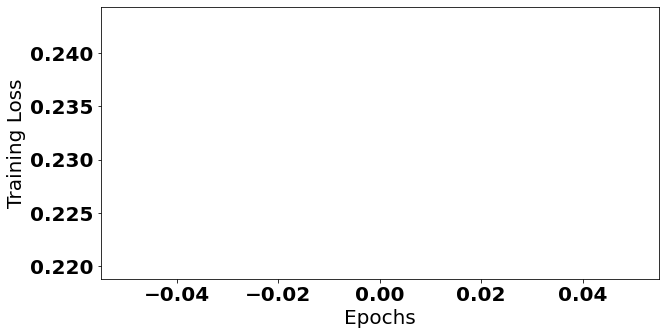

In [38]:
loss = history4.history['loss']
ep = np.arange(len(loss))
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

## Cifar10 old Classes 

In [39]:
### get Predictions
from scipy.stats import mode
MODELS = [model1,model1,model2,model3,model4]
preds = []
for m in MODELS:
    preds.append(m.predict(test_feat1[hold_in_test_class_idx], verbose = 1))
p1 =np.vstack([np.argmax(p, axis = 1) for p in preds]).T
pred,c =mode(p1, axis = 1)

157/157 [==============================] - 0s 632us/step


In [40]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

groundTruth = np.argmax(testY[hold_in_test_class_idx],axis = 1)
f1 = f1_score(groundTruth, pred, average = "macro")
acc = accuracy_score(groundTruth, pred)
recall = recall_score(groundTruth, pred,average = "macro")
precision =precision_score(groundTruth, pred, average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(groundTruth, num_classes = 5), 
                tf.keras.utils.to_categorical(pred, num_classes = 5))

print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 1.2019494186401367
Accuracy: 0.9652
F1 Score: 0.9651530879269707
recall Score: 0.9652
Precision Score: 0.9653057496873417


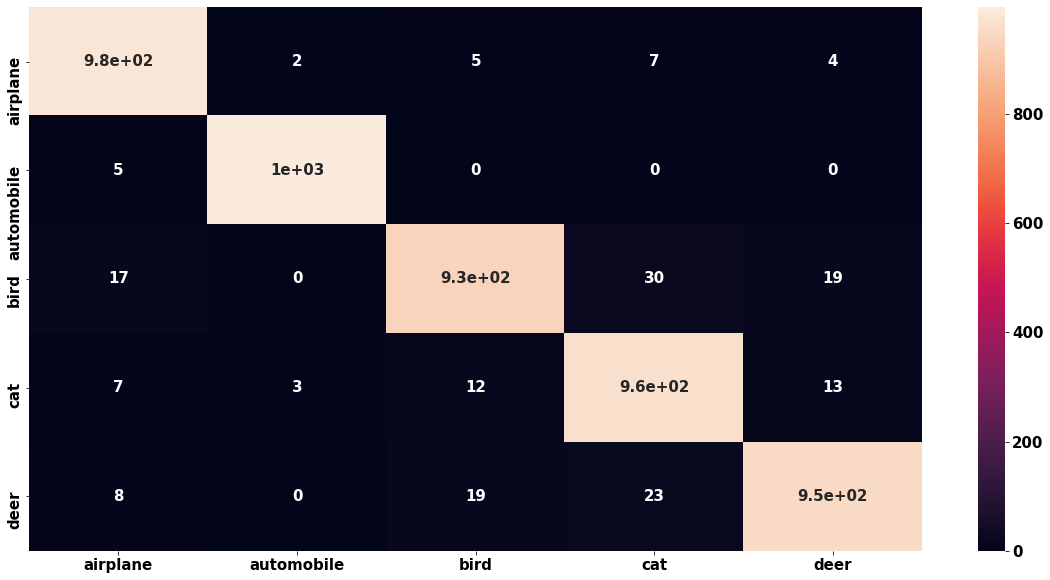

In [41]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,pred)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

labels_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
               'truck'][:5]
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('saveed_figures/en_cnn/enconf1Cifar10 old Classes.png', dpi =200)
plt.savefig('saveed_figures/en_cnn/enconf1Cifar10 old Classes.pdf', dpi = 200)

<ipython-input-42-4f5dc0addcd6>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


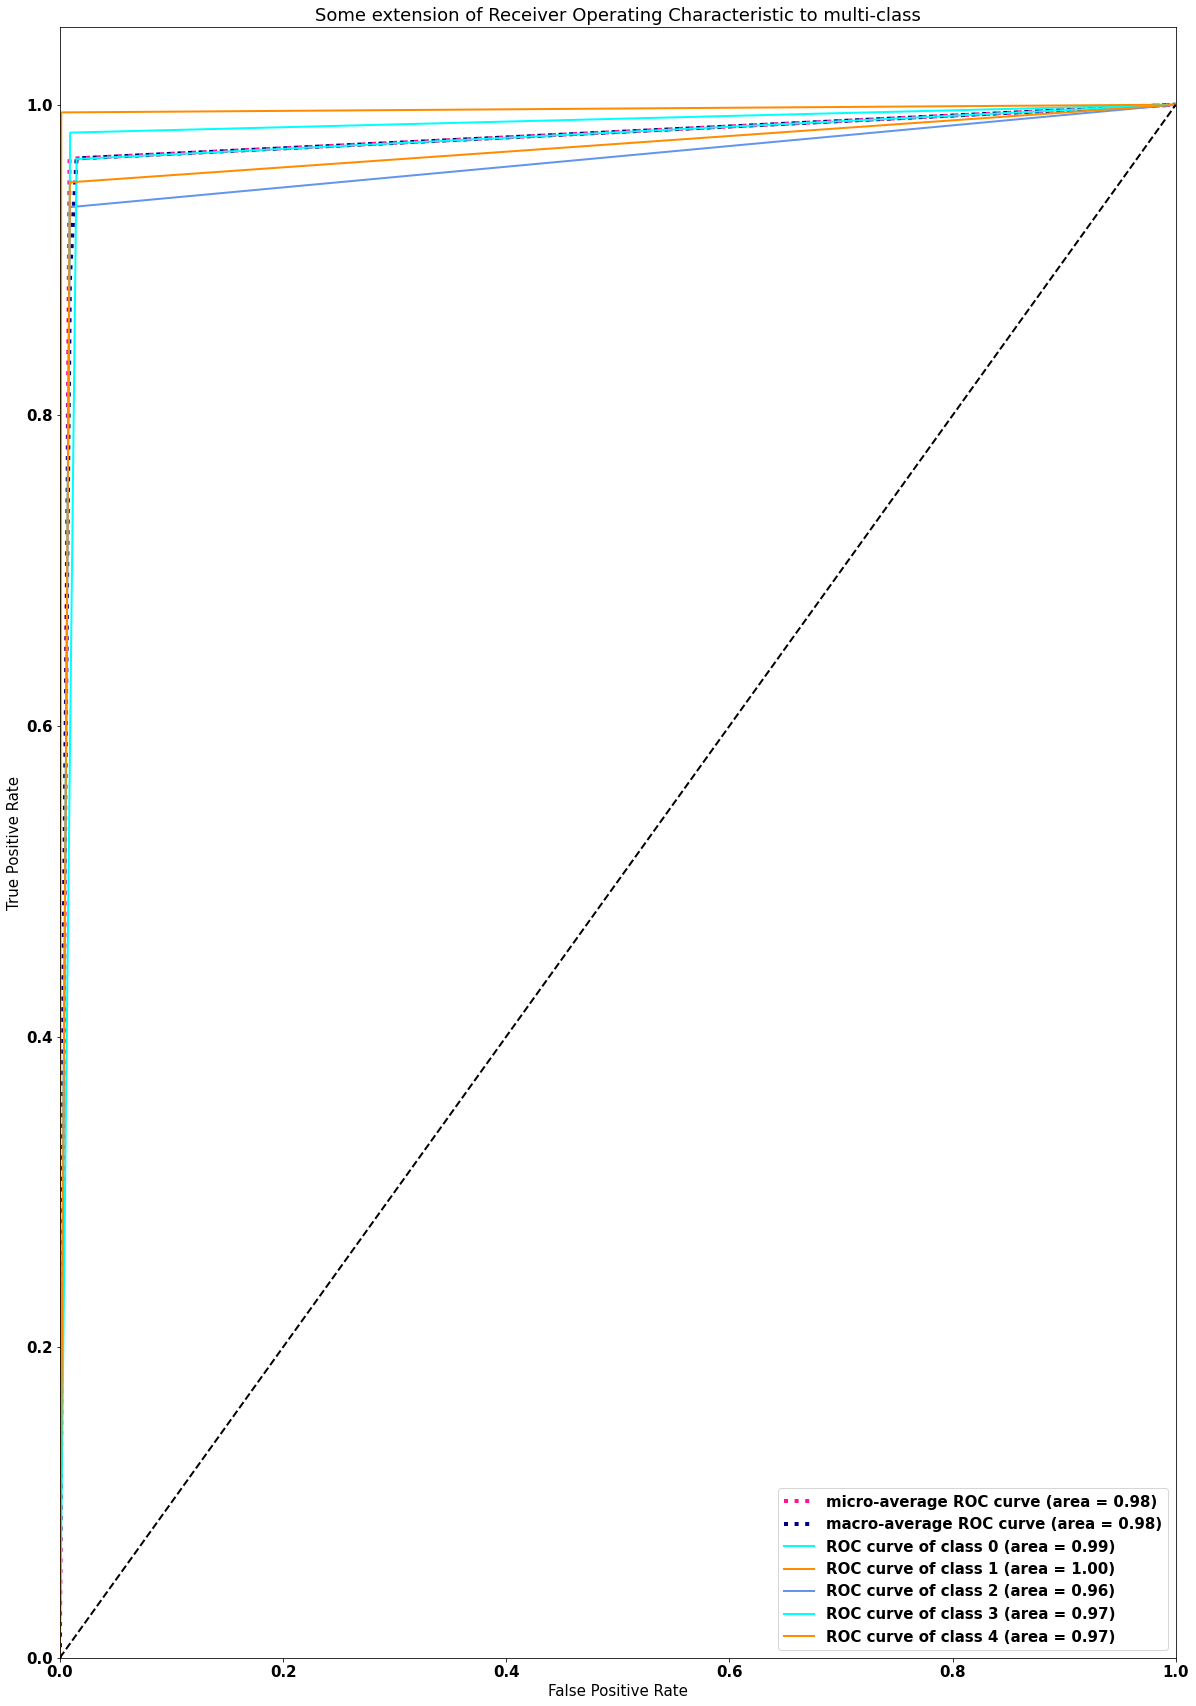

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(groundTruth, num_classes = 5))
y_score = np.copy(tf.keras.utils.to_categorical(pred))
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('saveed_figures/en_cnn/enroc1Cifar10 old Classes.png', dpi = 200)
plt.savefig('saveed_figures/en_cnn/enroc1Cifar10 old Classes.pdf', dpi = 200)
plt.show()


In [43]:
%matplotlib inline
def plot_class_predictions(preds,idx, classes):
    
    print("Class #{}".format(idx))
    c, f = np.unique(preds, return_counts = True)
    fig = plt.figure( figsize = (30,20))
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
    matplotlib.rc('font', **font)
    ax = fig.add_axes([0,0,1,1 ])
    ax.set_title("{} Predictions".format(classes[idx]))
    ax.set_xlabel("Clases")
    ax.set_ylabel("Frequecy Of Predictions")
    ax.set_xticks(c)
    ax.bar(c,f)
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

In [44]:
cclasses = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
               'truck'][:5]

Class #0


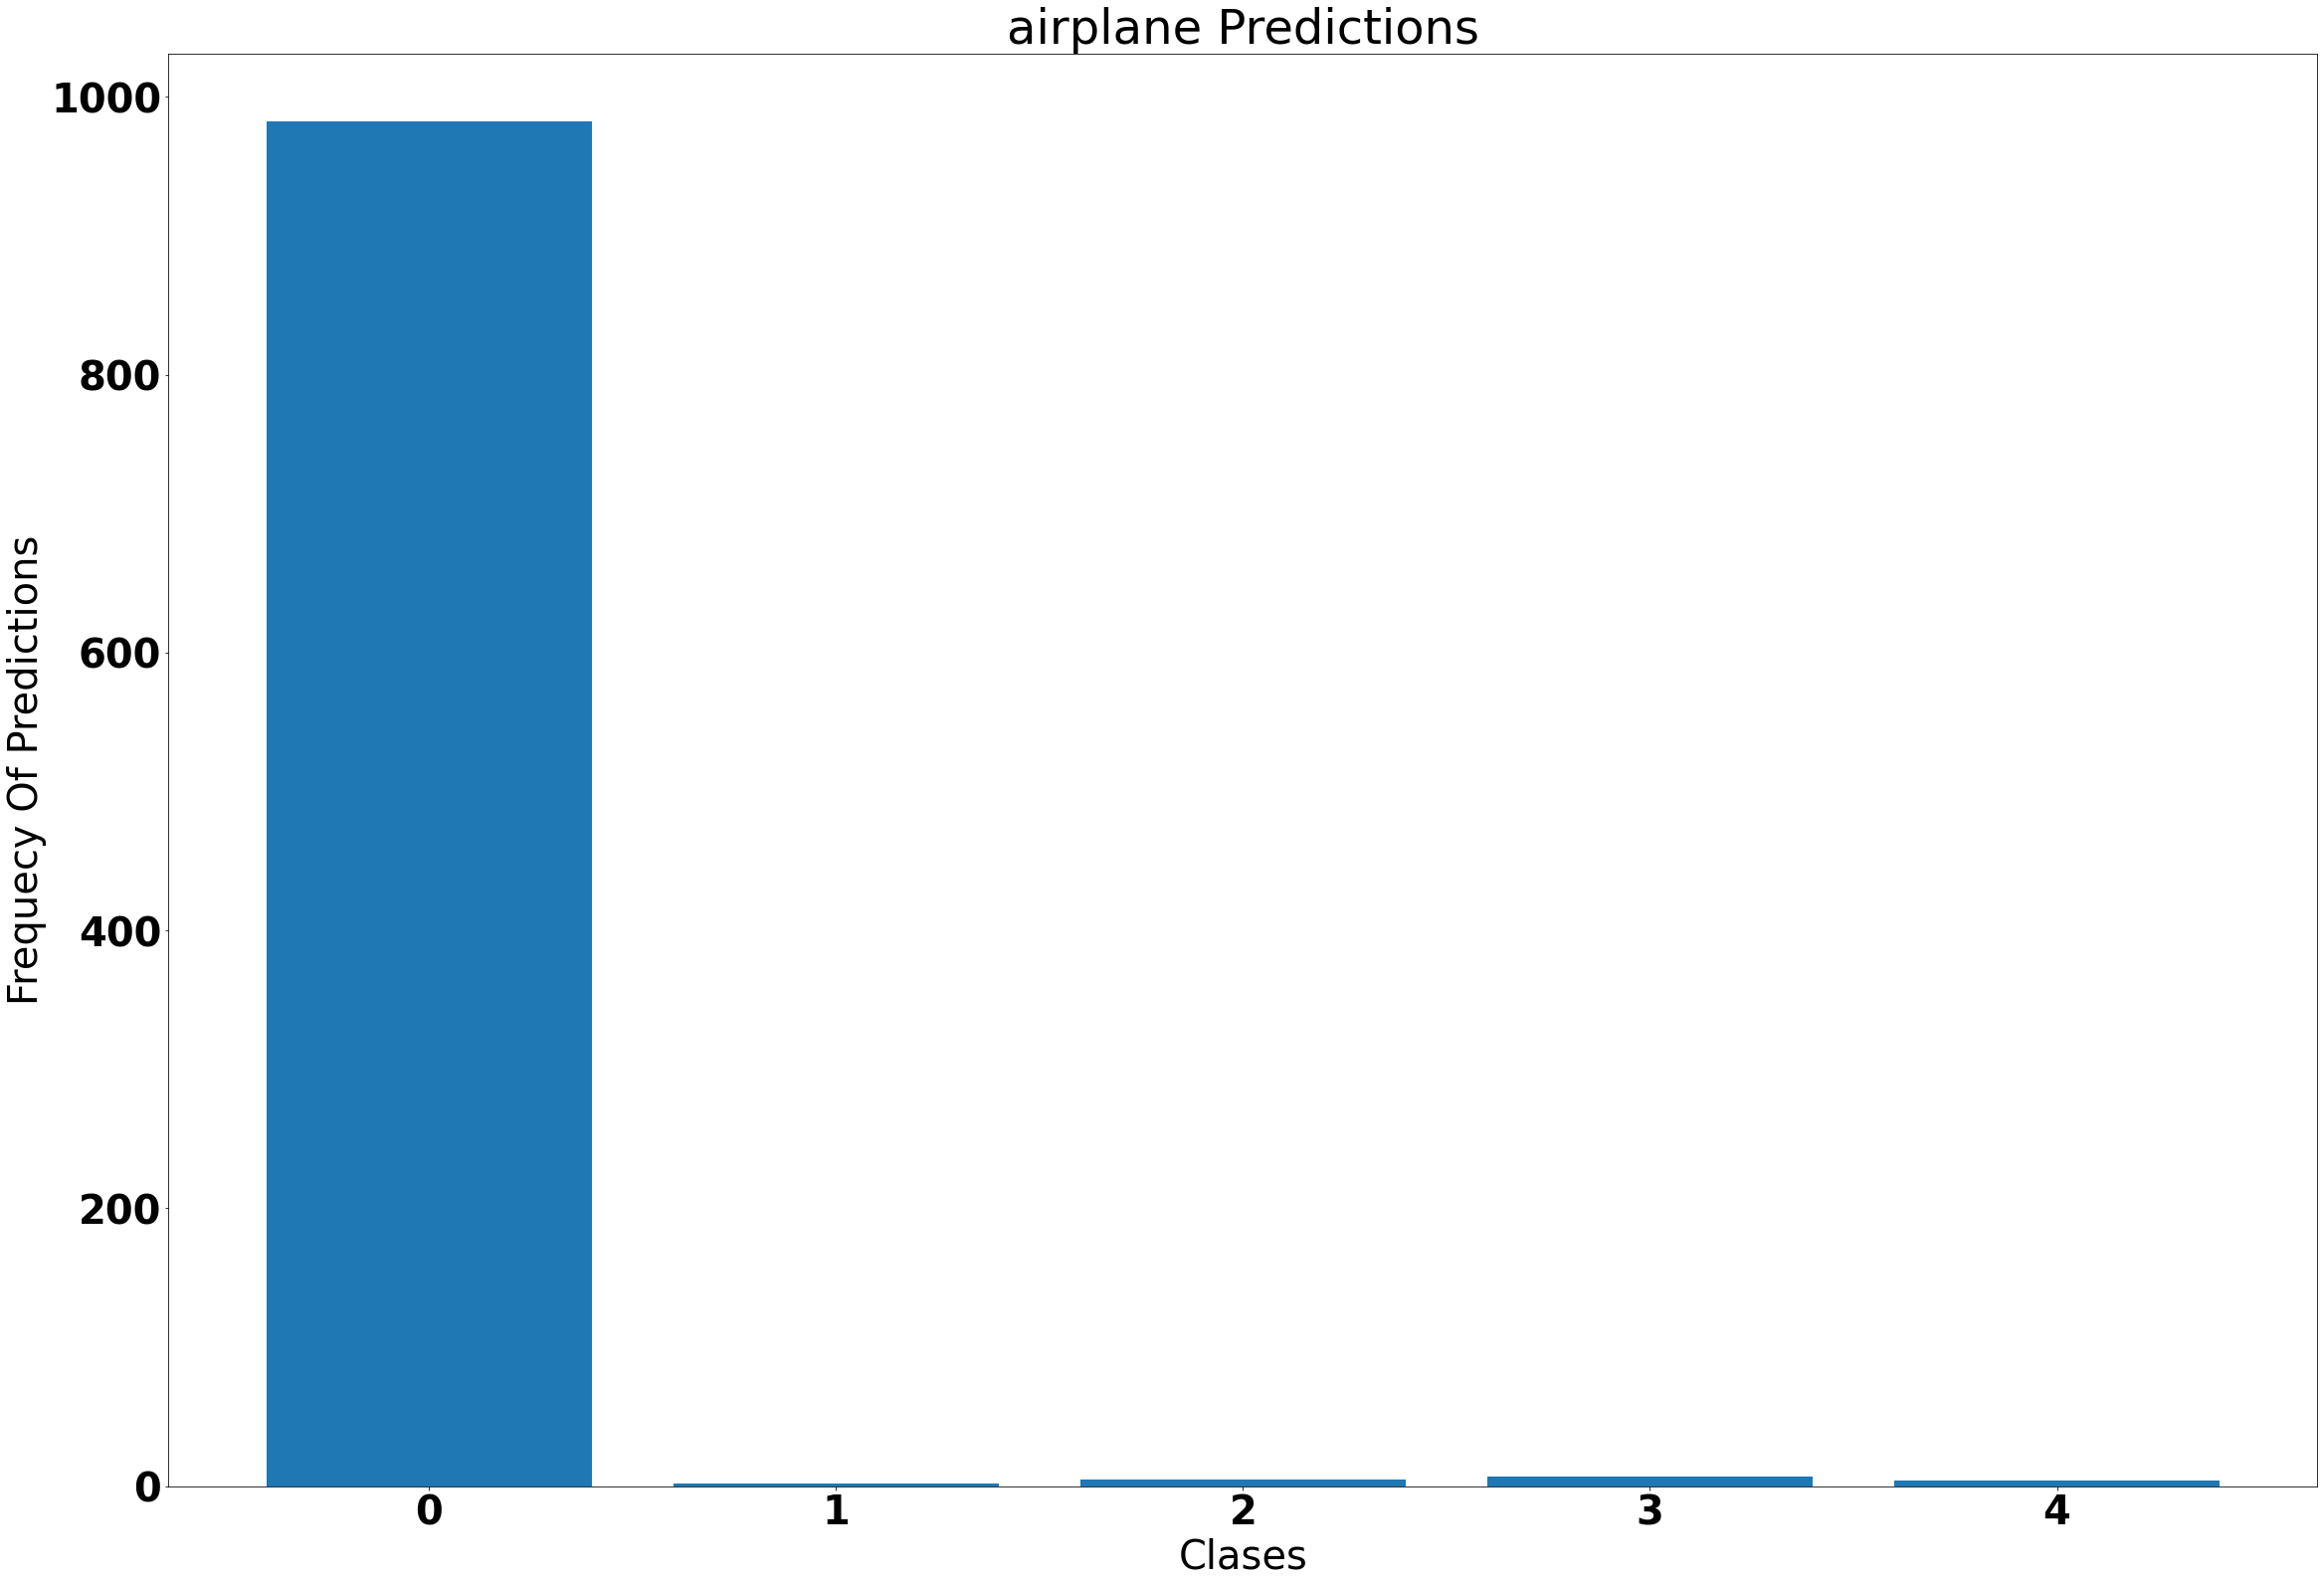

In [45]:
idx = 0
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

Class #1


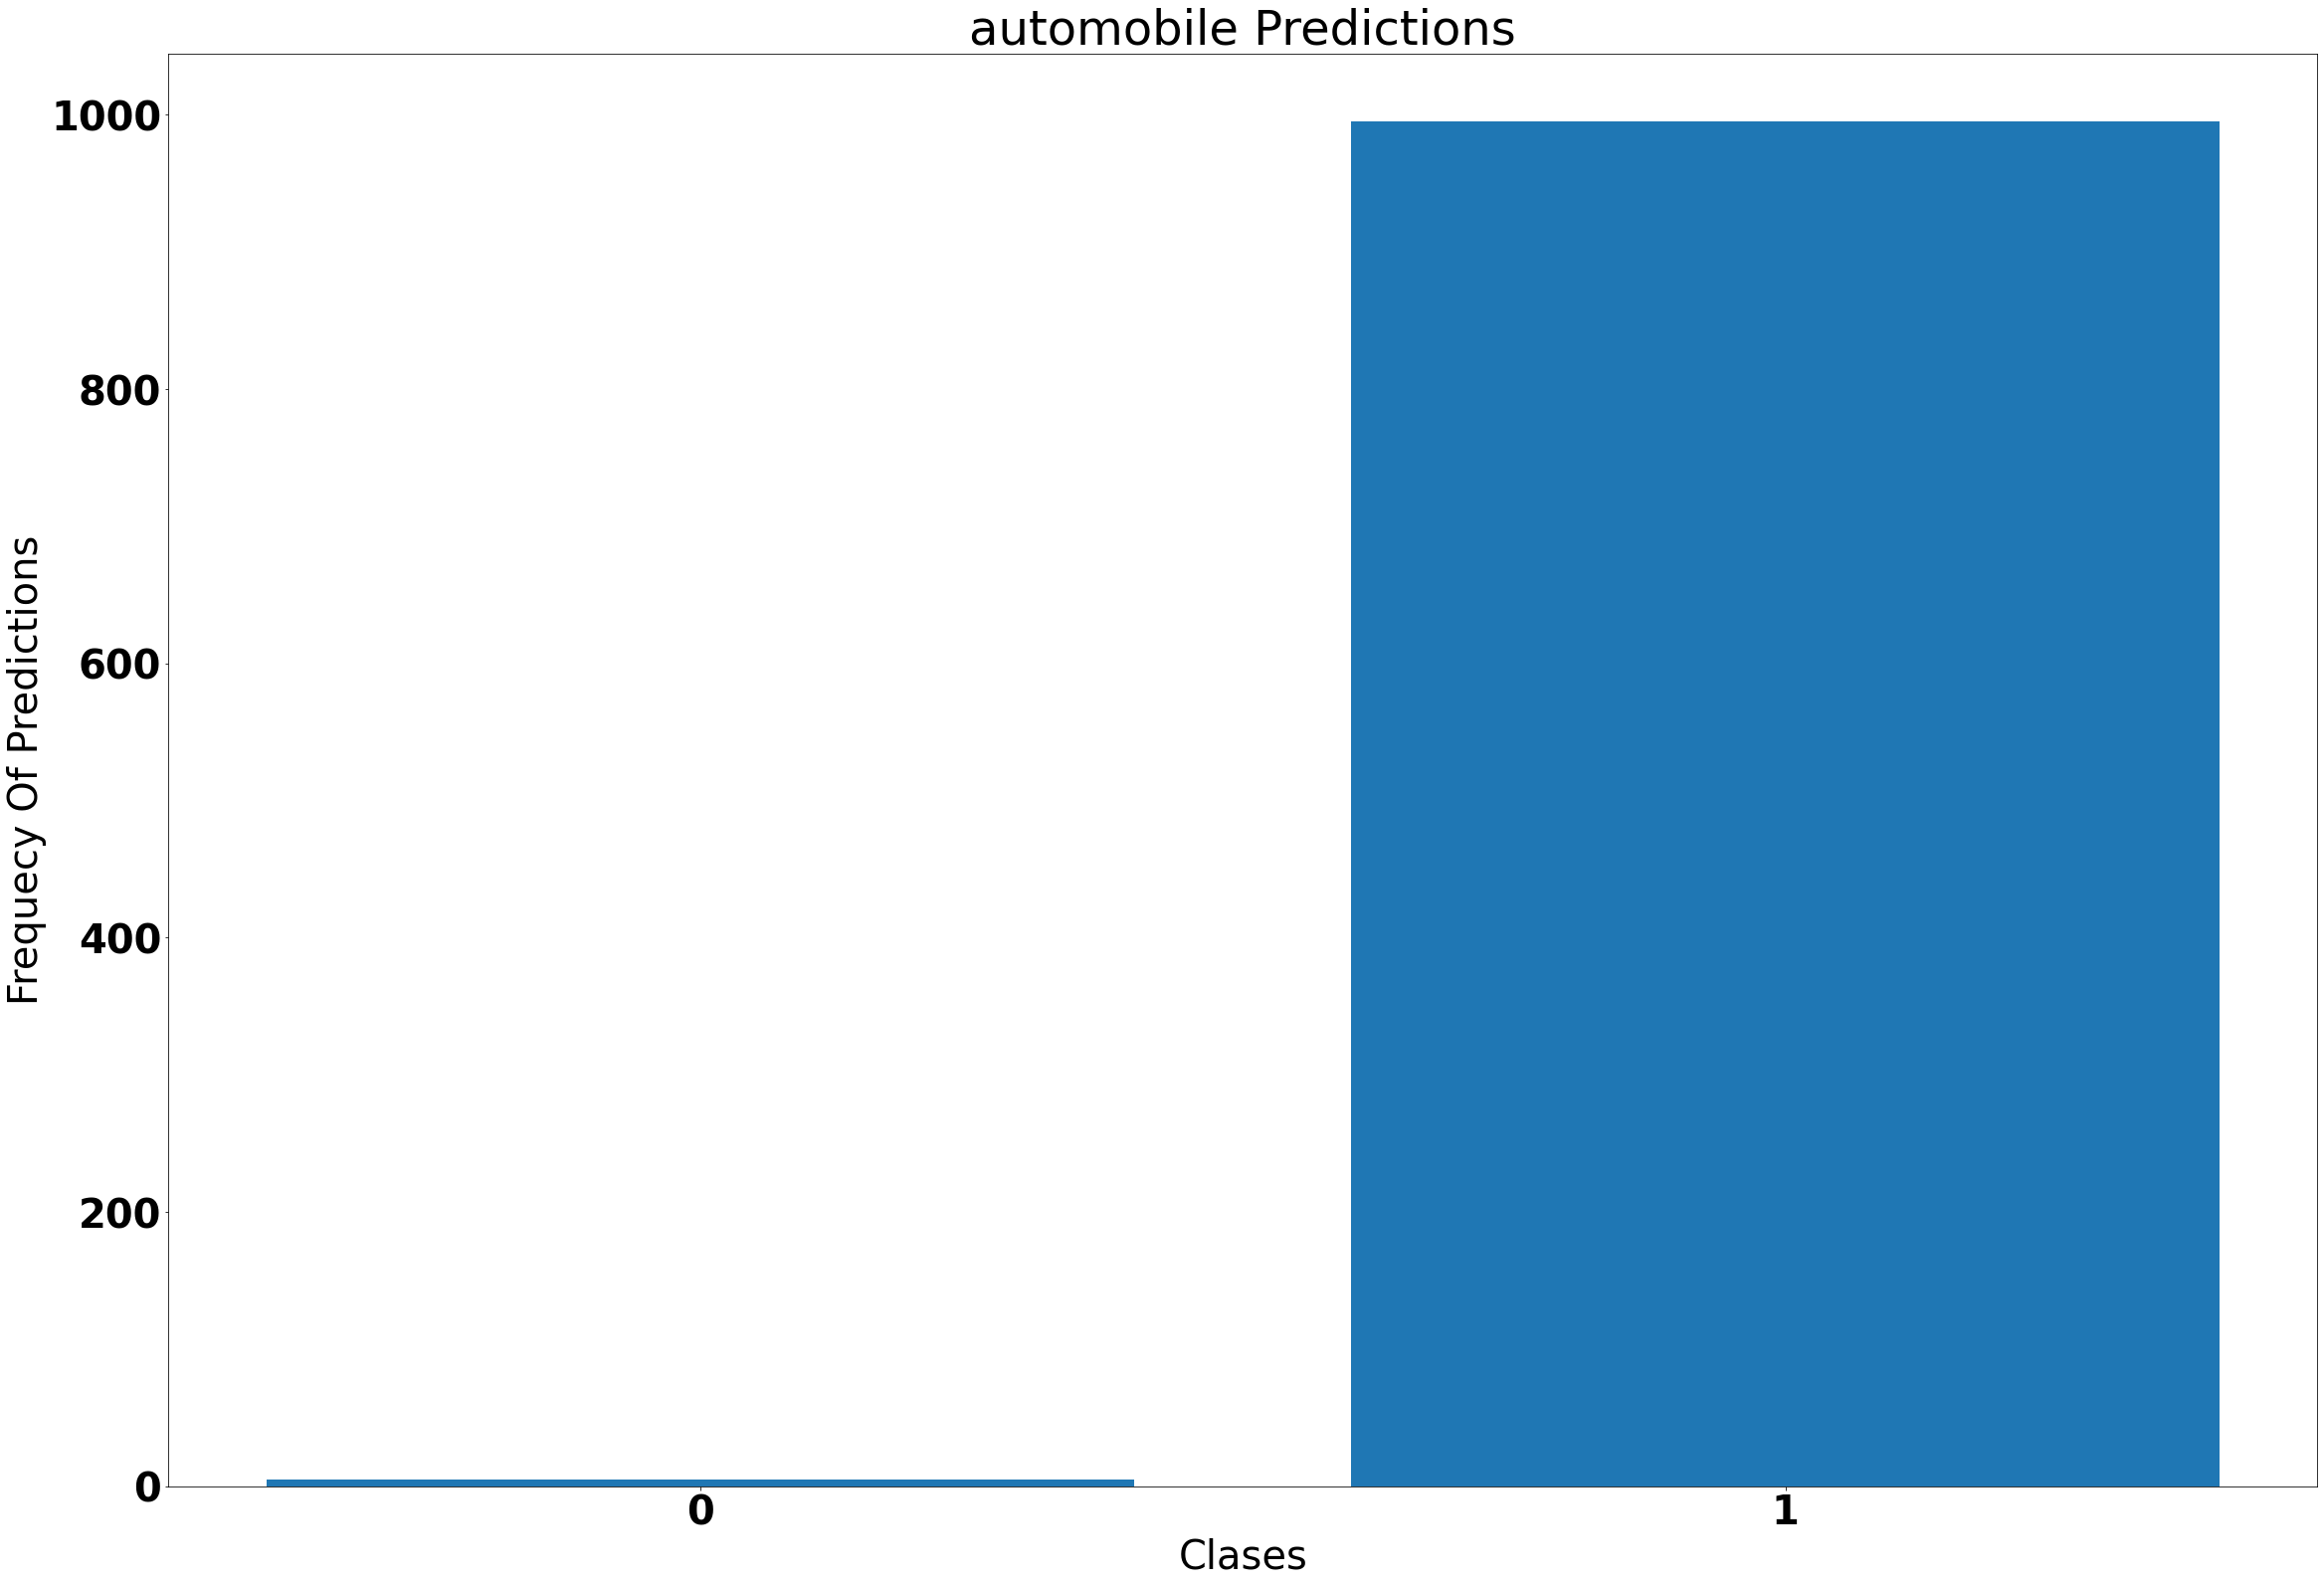

In [46]:
idx = 1
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

Class #2


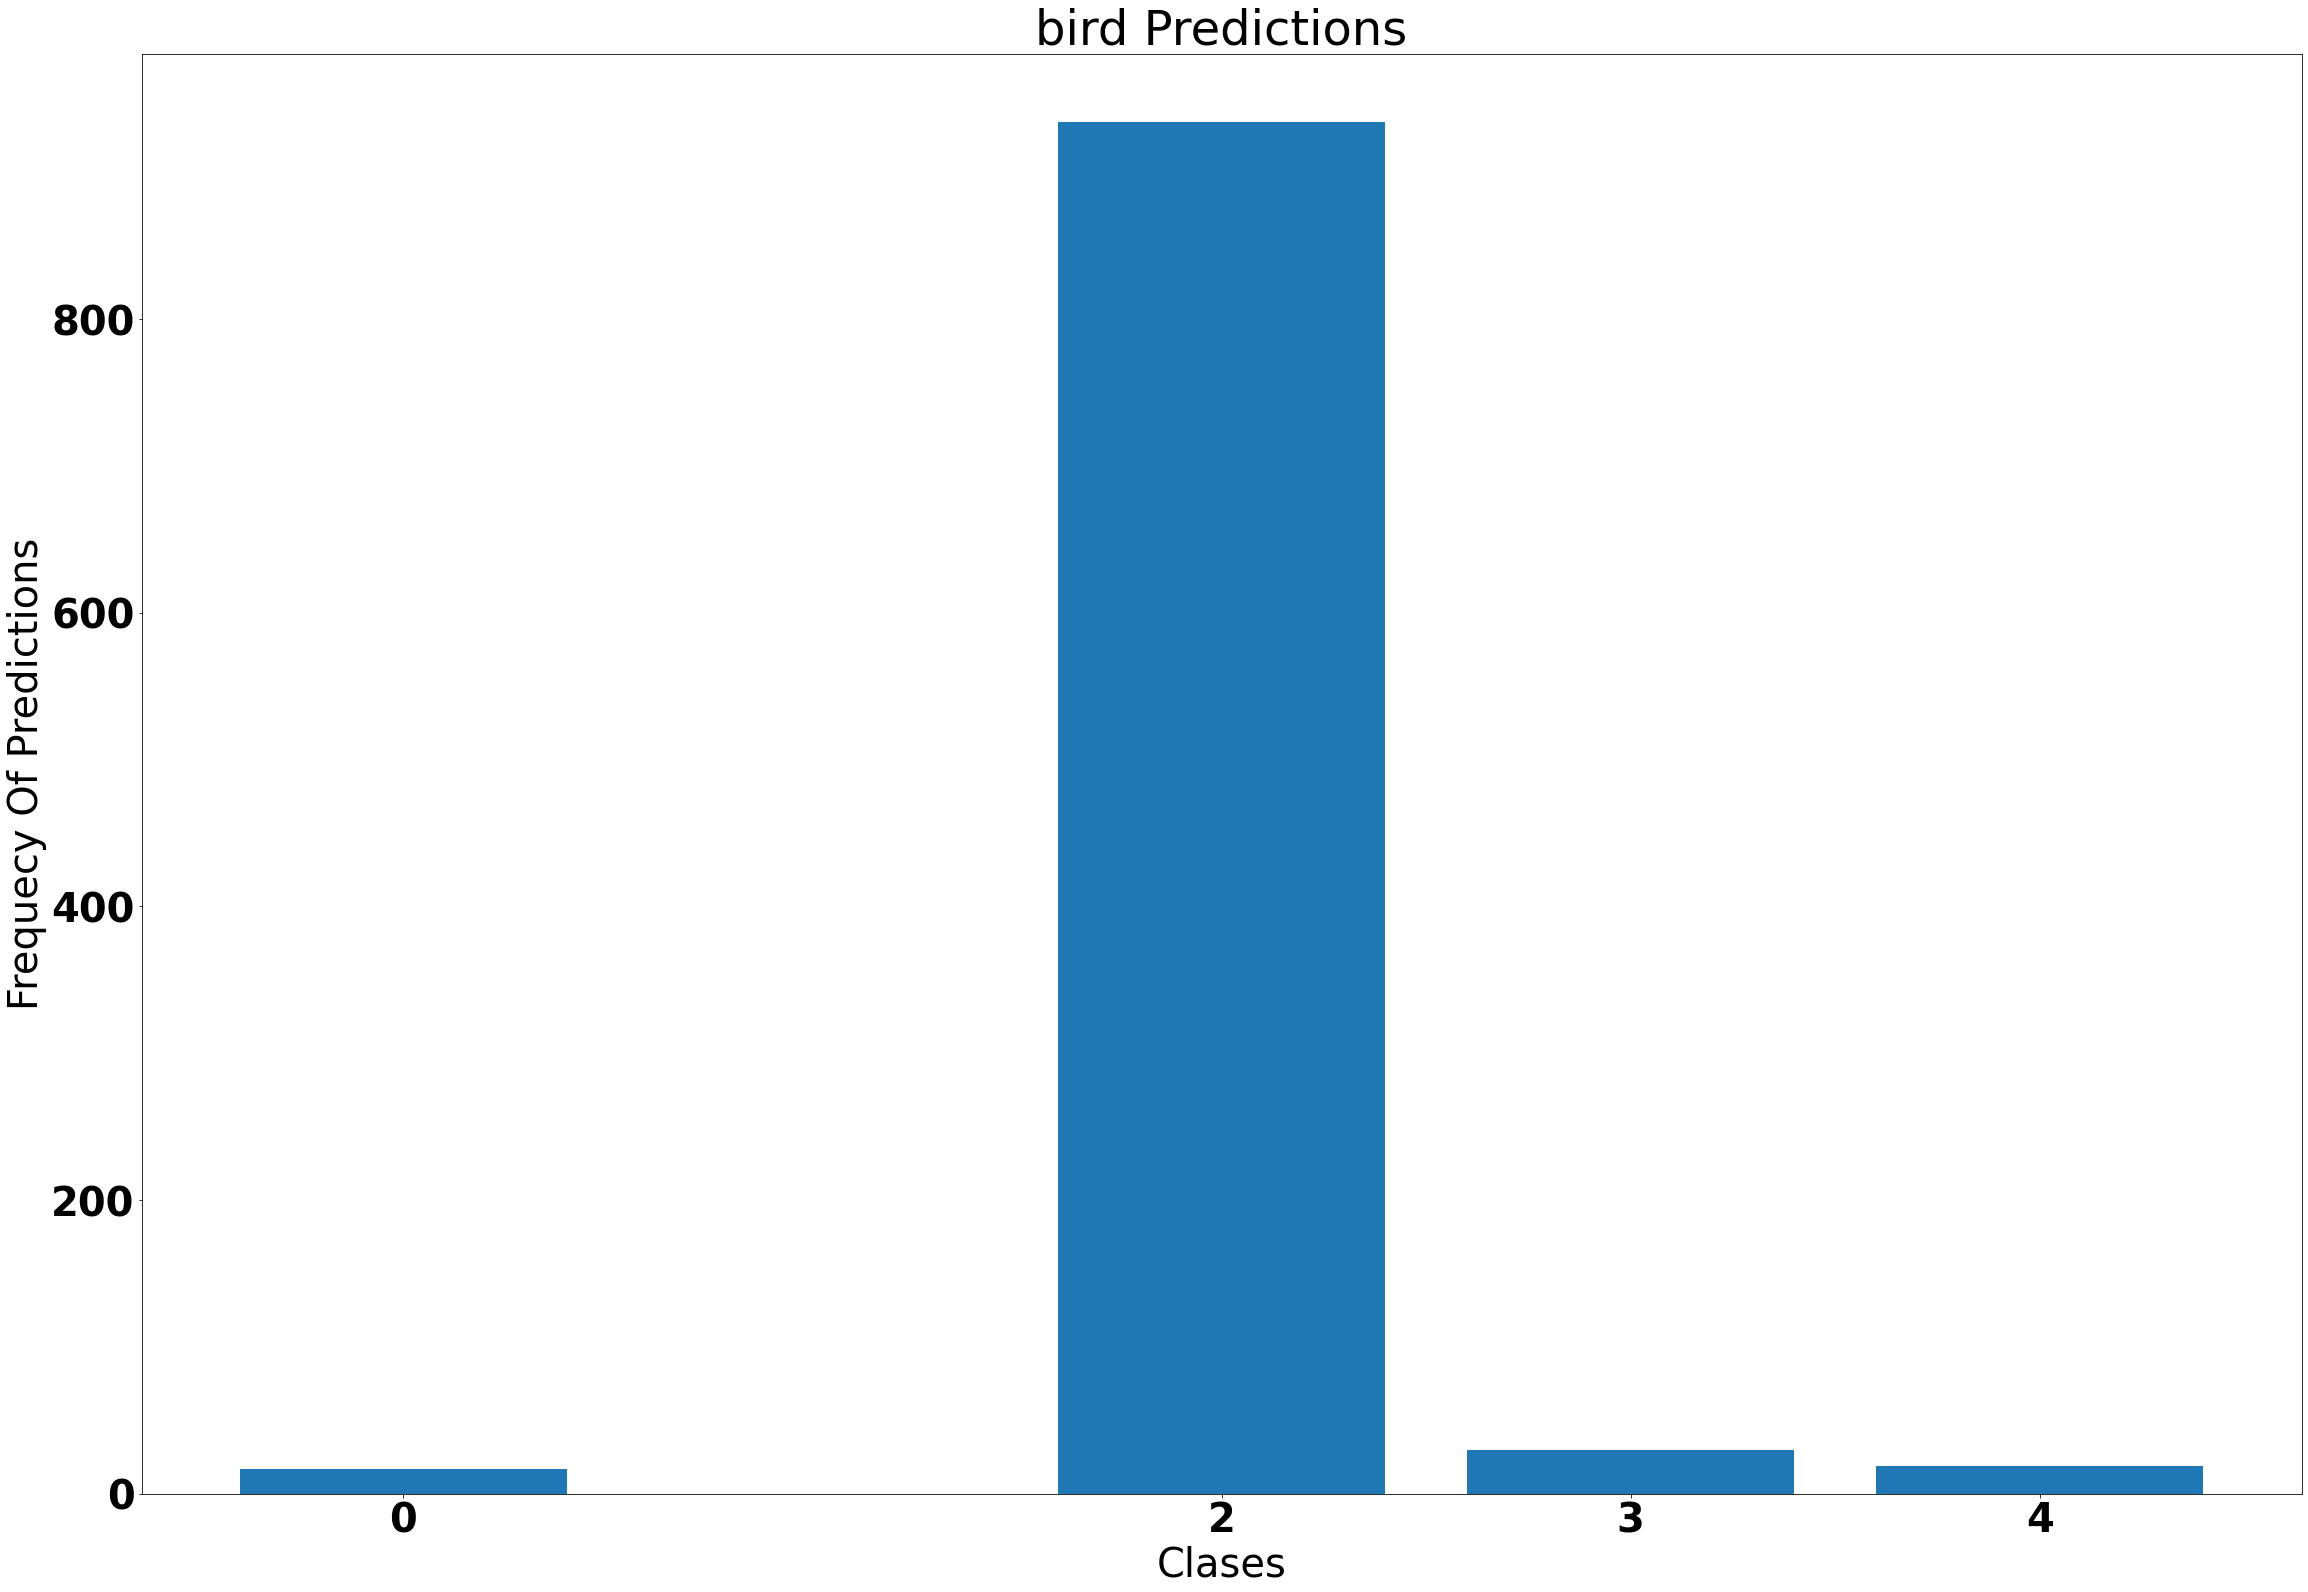

In [47]:
idx = 2
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

Class #3


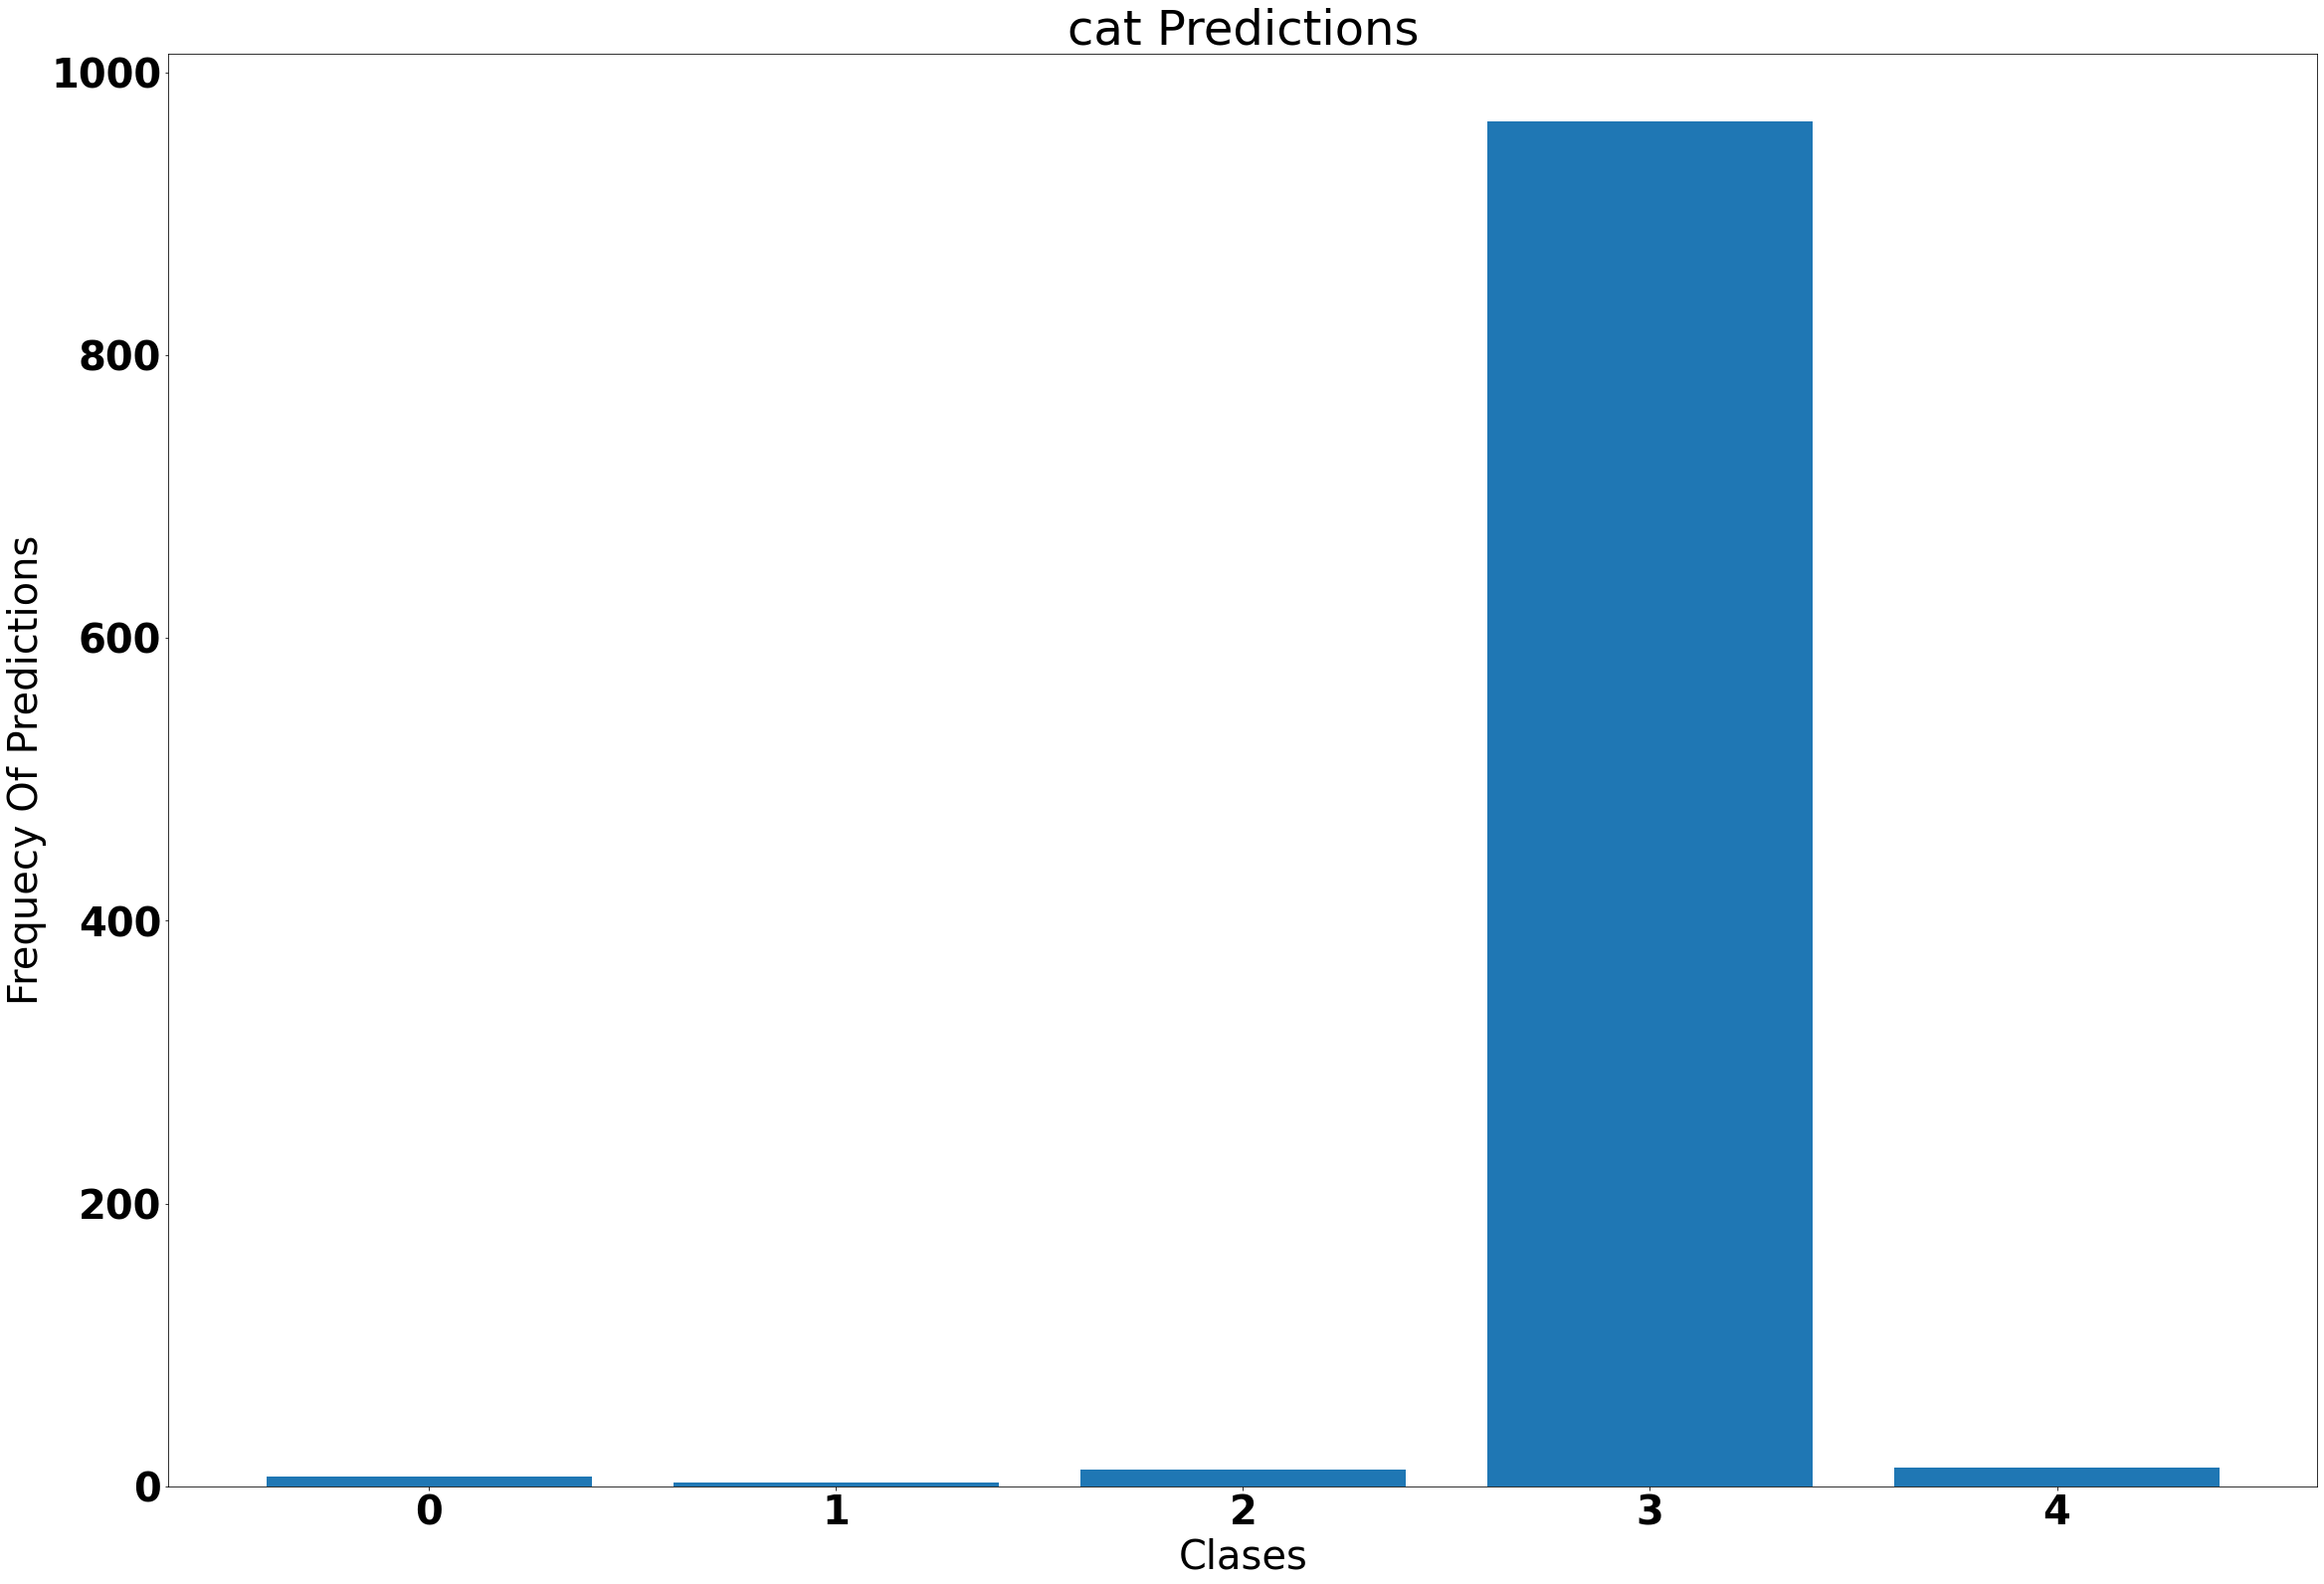

In [48]:
idx = 3
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

Class #4


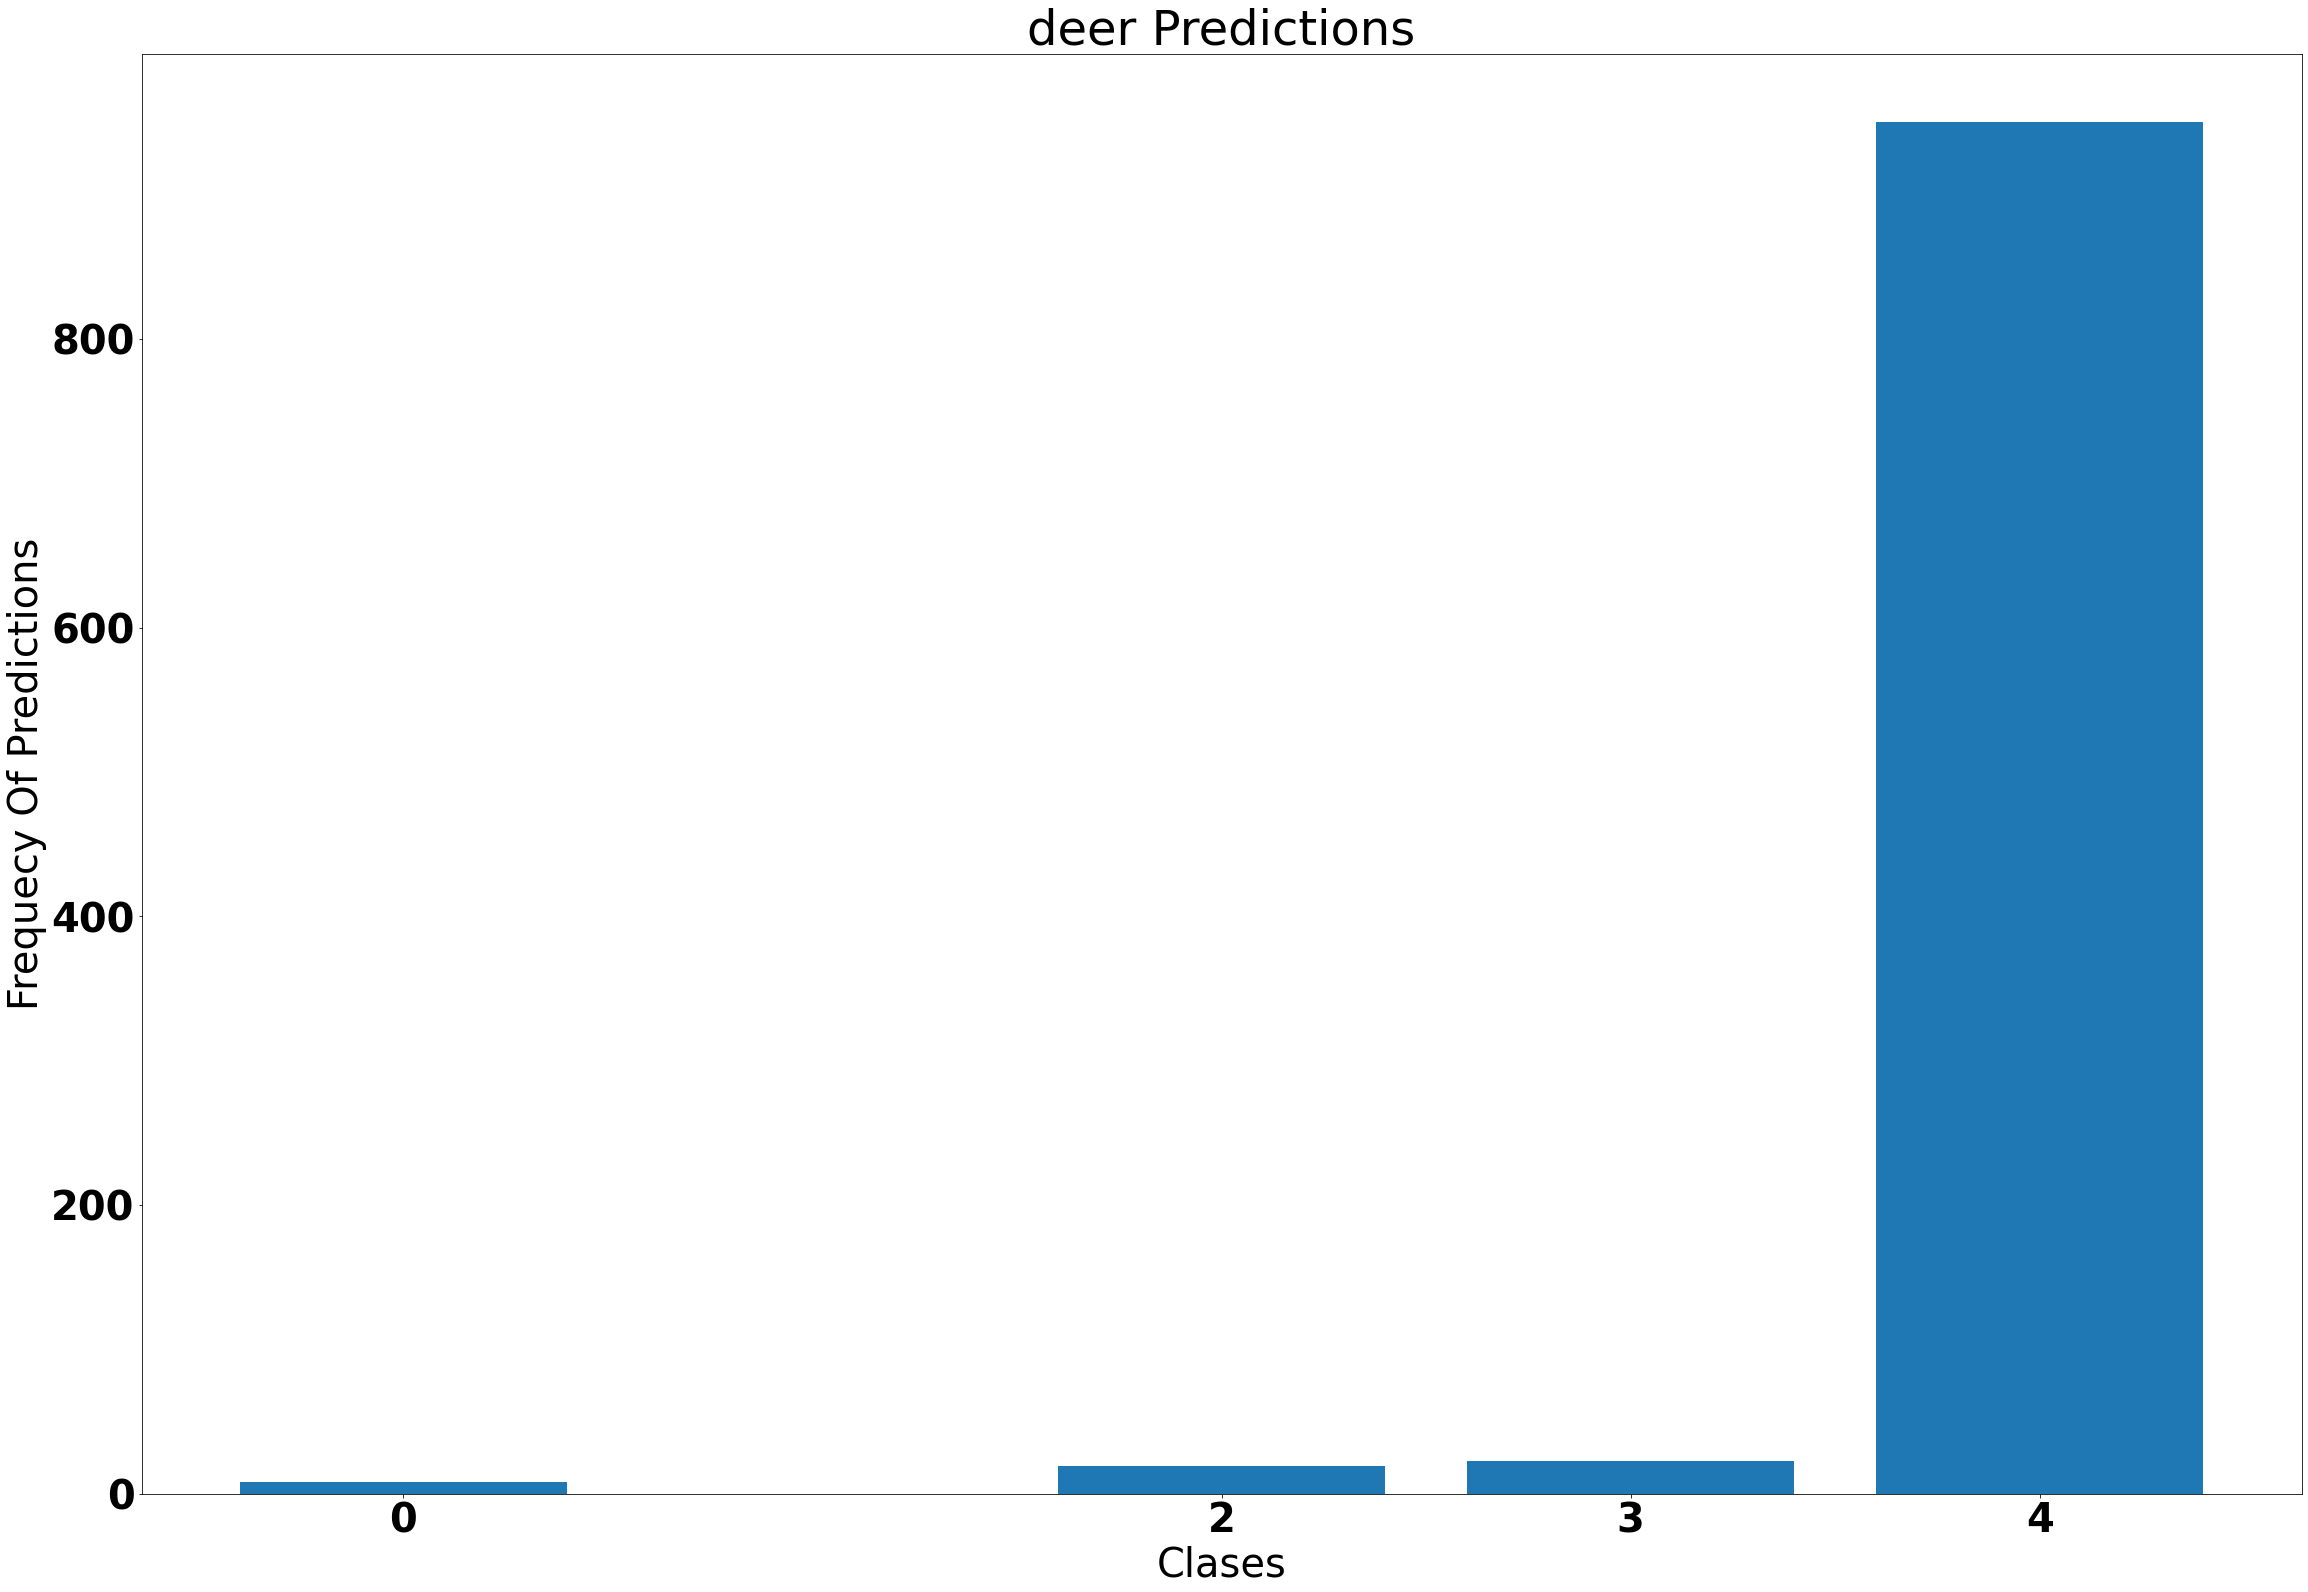

In [49]:
idx = 4
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

## CIFAR 10 NEW CLASSES

In [50]:
### Selecting the classes
hold_in_train_class = [5,6,7,8,9]
hold_in_train_class_idx = []
for i in hold_in_train_class:
    hold_in_train_class_idx = hold_in_train_class_idx + returnClassIndex(trainY,i)

In [51]:
### Selecting the classes
hold_in_test_class = [5,6,7,8,9]
hold_in_test_class_idx = []
for i in hold_in_test_class:
    hold_in_test_class_idx = hold_in_test_class_idx + returnClassIndex(testY,i)

In [52]:
### get Predictions
from scipy.stats import mode
MODELS = [model1,model1,model2,model3,model4]
preds = []
for m in MODELS:
    preds.append(m.predict(test_feat1[hold_in_test_class_idx], verbose = 1))
p1 =np.vstack([np.argmax(p, axis = 1) for p in preds]).T
pred,c =mode(p1, axis = 1)

157/157 [==============================] - 0s 750us/step


In [53]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

groundTruth = np.argmax(testY[hold_in_test_class_idx],axis = 1) -5
f1 = f1_score(groundTruth, pred, average = "macro")
acc = accuracy_score(groundTruth, pred)
recall = recall_score(groundTruth, pred,average = "macro")
precision =precision_score(groundTruth, pred, average = "macro")
loss = log_loss(tf.keras.utils.to_categorical(groundTruth, num_classes = 5), 
                tf.keras.utils.to_categorical(pred, num_classes = 5))

print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 33.41281228713989
Accuracy: 0.0326
F1 Score: 0.0312168190745463
recall Score: 0.032600000000000004
Precision Score: 0.029955826014400843


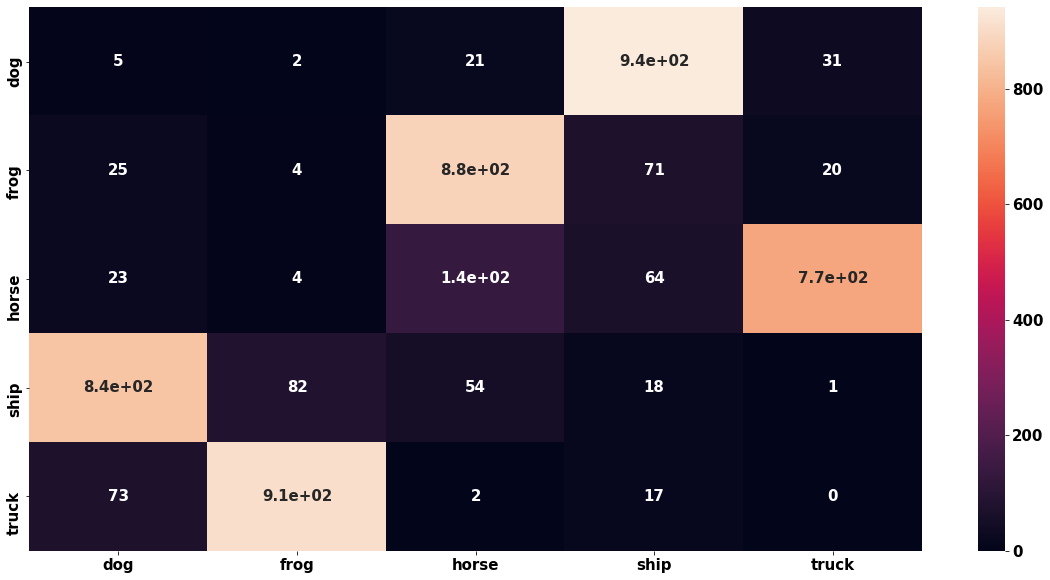

In [54]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(groundTruth,pred)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

labels_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
               'truck'][-5:]
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('saveed_figures/en_cnn/enconf2CIFAR 10 NEW CLASSES.png', dpi = 200)
plt.savefig('saveed_figures/en_cnn/enconf2CIFAR 10 NEW CLASSES.pdf', dpi = 200)

<ipython-input-55-e9a6b0930b59>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


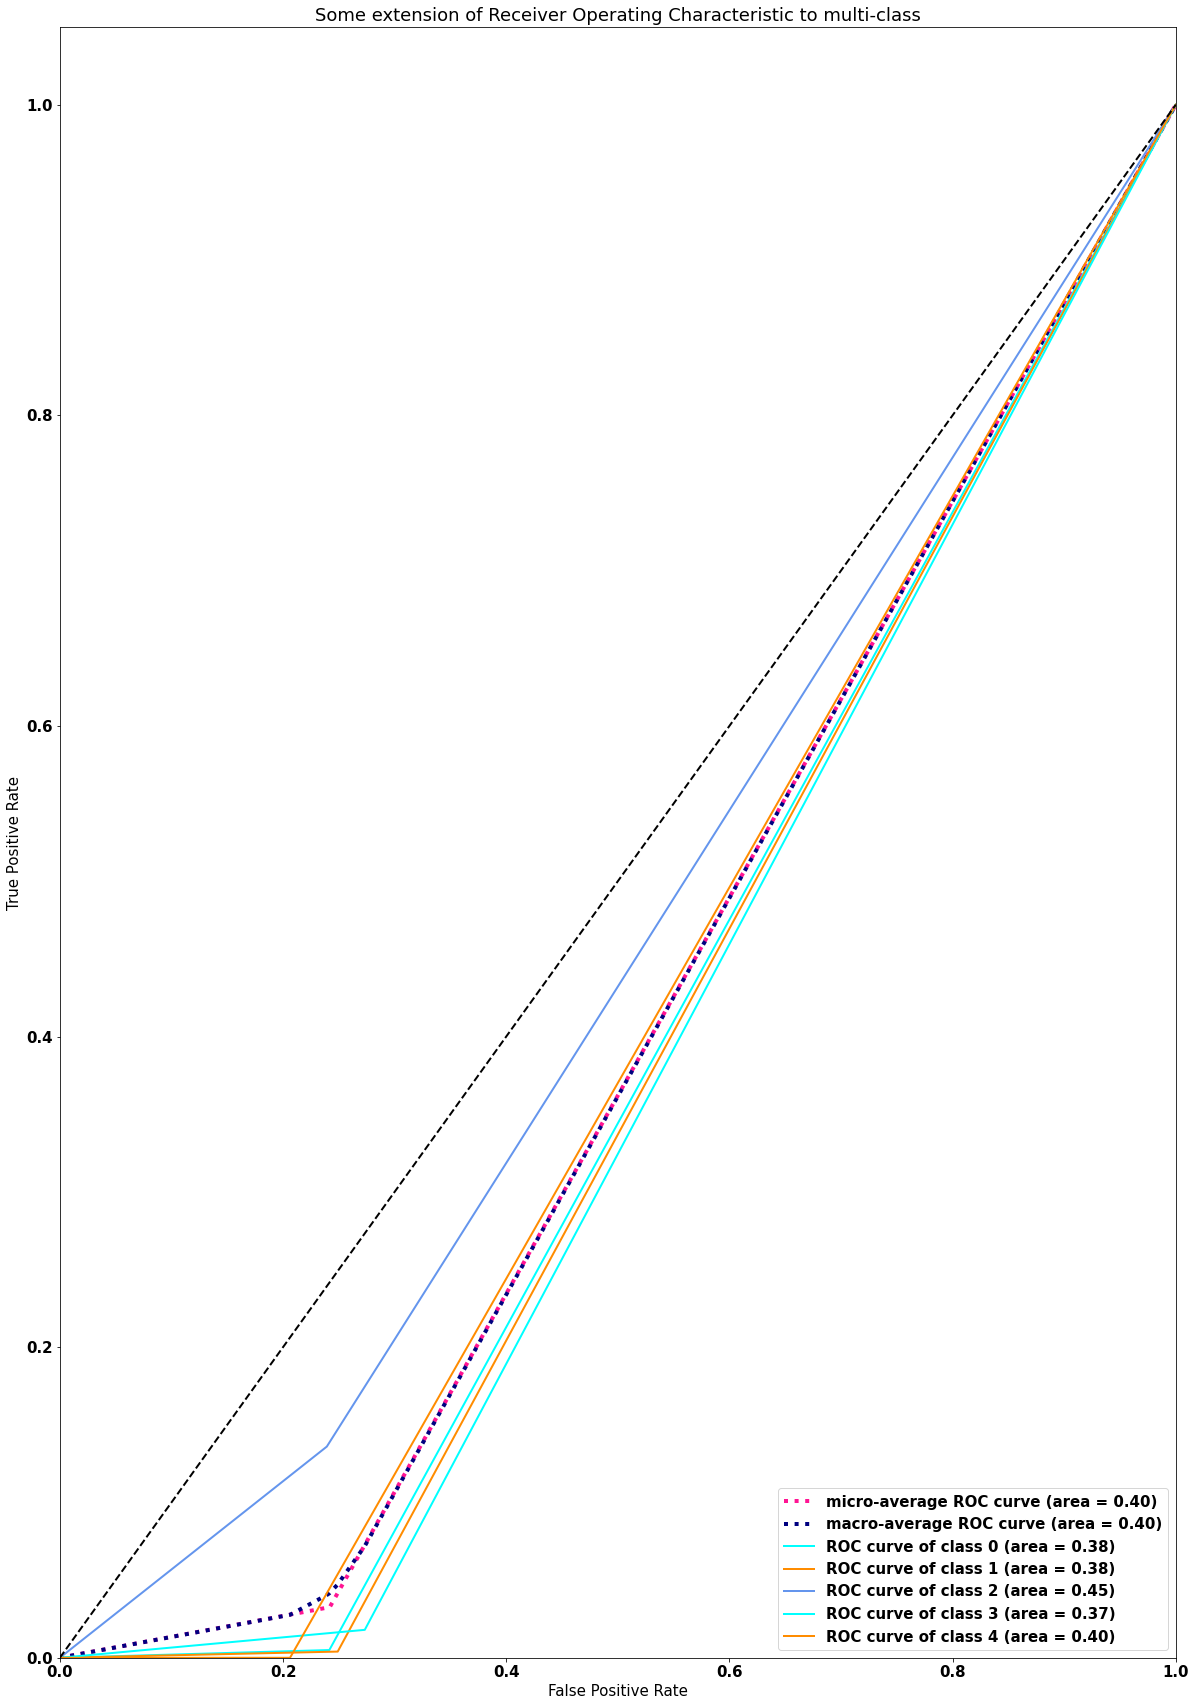

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(groundTruth, num_classes = 5))
y_score = np.copy(tf.keras.utils.to_categorical(pred))
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('saveed_figures/en_cnn/enroc2CIFAR 10 NEW CLASSES.png', dpi = 200)
plt.savefig('saveed_figures/en_cnn/enroc2CIFAR 10 NEW CLASSES.pdf', dpi = 200)
plt.show()

In [56]:
%matplotlib inline
def plot_class_predictions(preds,idx, classes):
    
    print("Class #{}".format(idx))
    c, f = np.unique(preds, return_counts = True)
    fig = plt.figure( figsize = (30,20))
    font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
    matplotlib.rc('font', **font)
    ax = fig.add_axes([0,0,1,1 ])
    ax.set_title("{} Predictions".format(classes[idx]))
    ax.set_xlabel("Clases")
    ax.set_ylabel("Frequecy Of Predictions")
    ax.set_xticks(c)
    ax.bar(c,f)
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

In [57]:
cclasses = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship',
               'truck'][:5]

Class #0


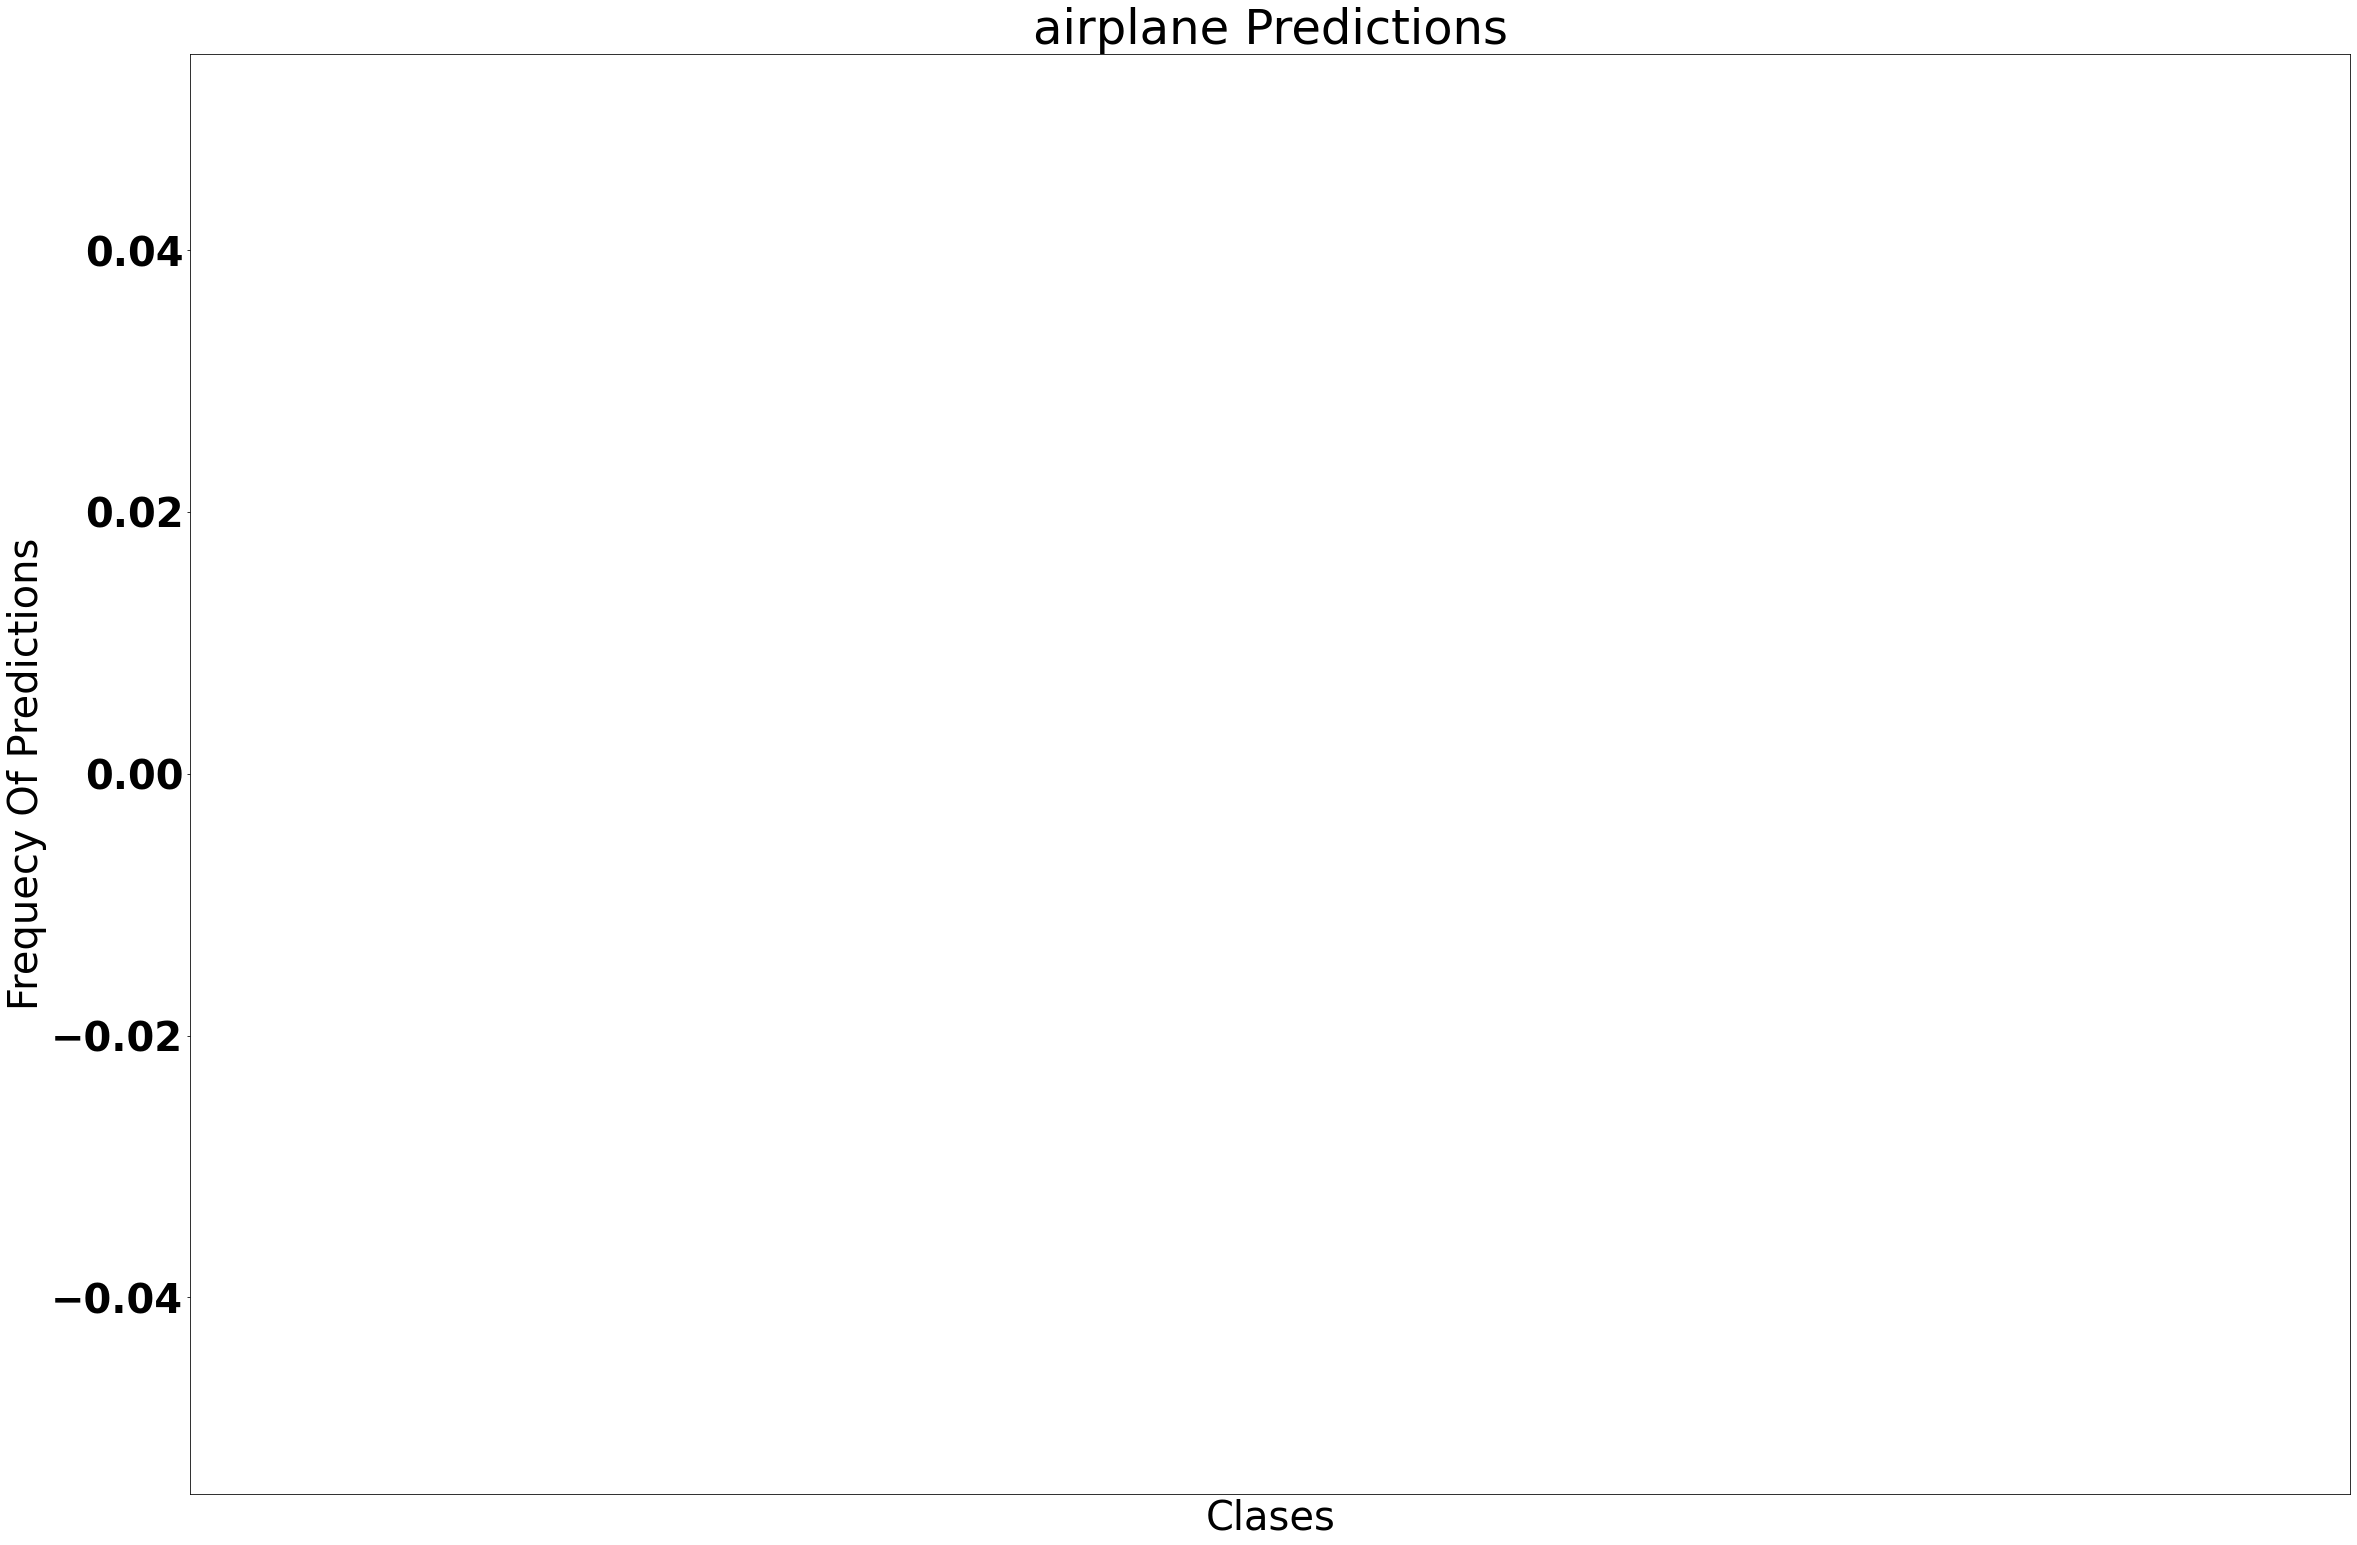

In [58]:
idx = 0
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

Class #1


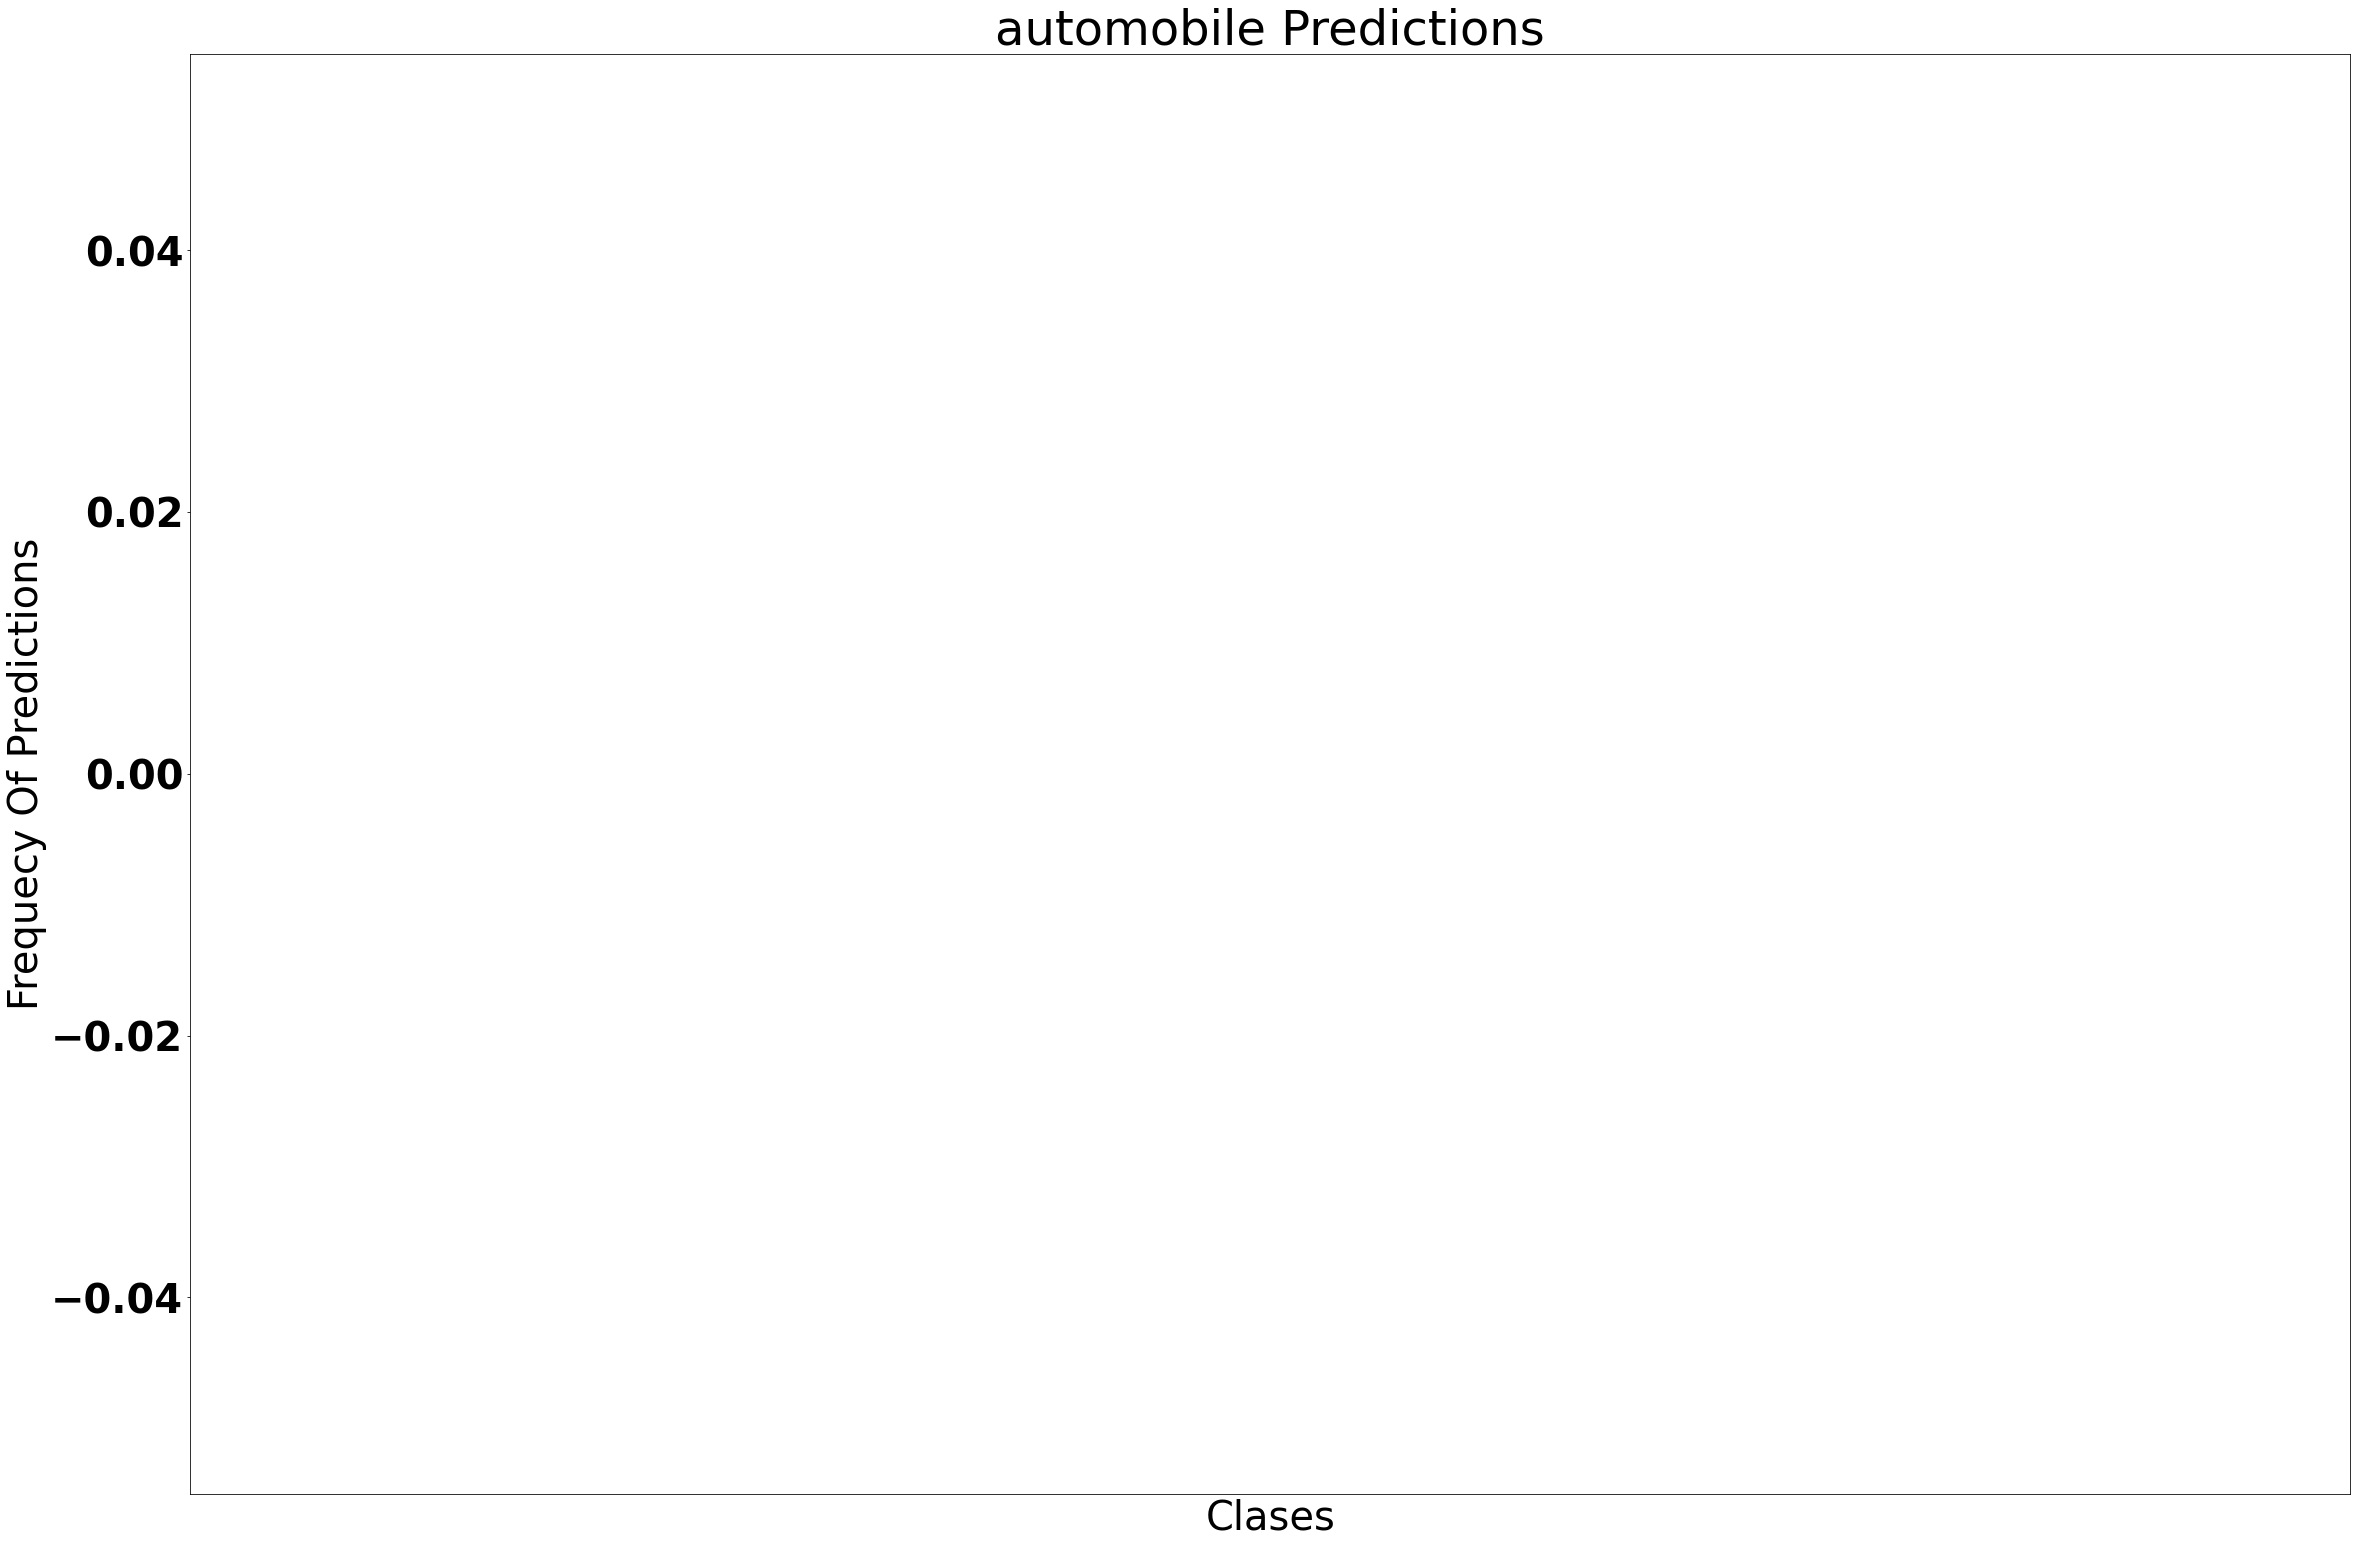

In [59]:
idx = 1
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

Class #2


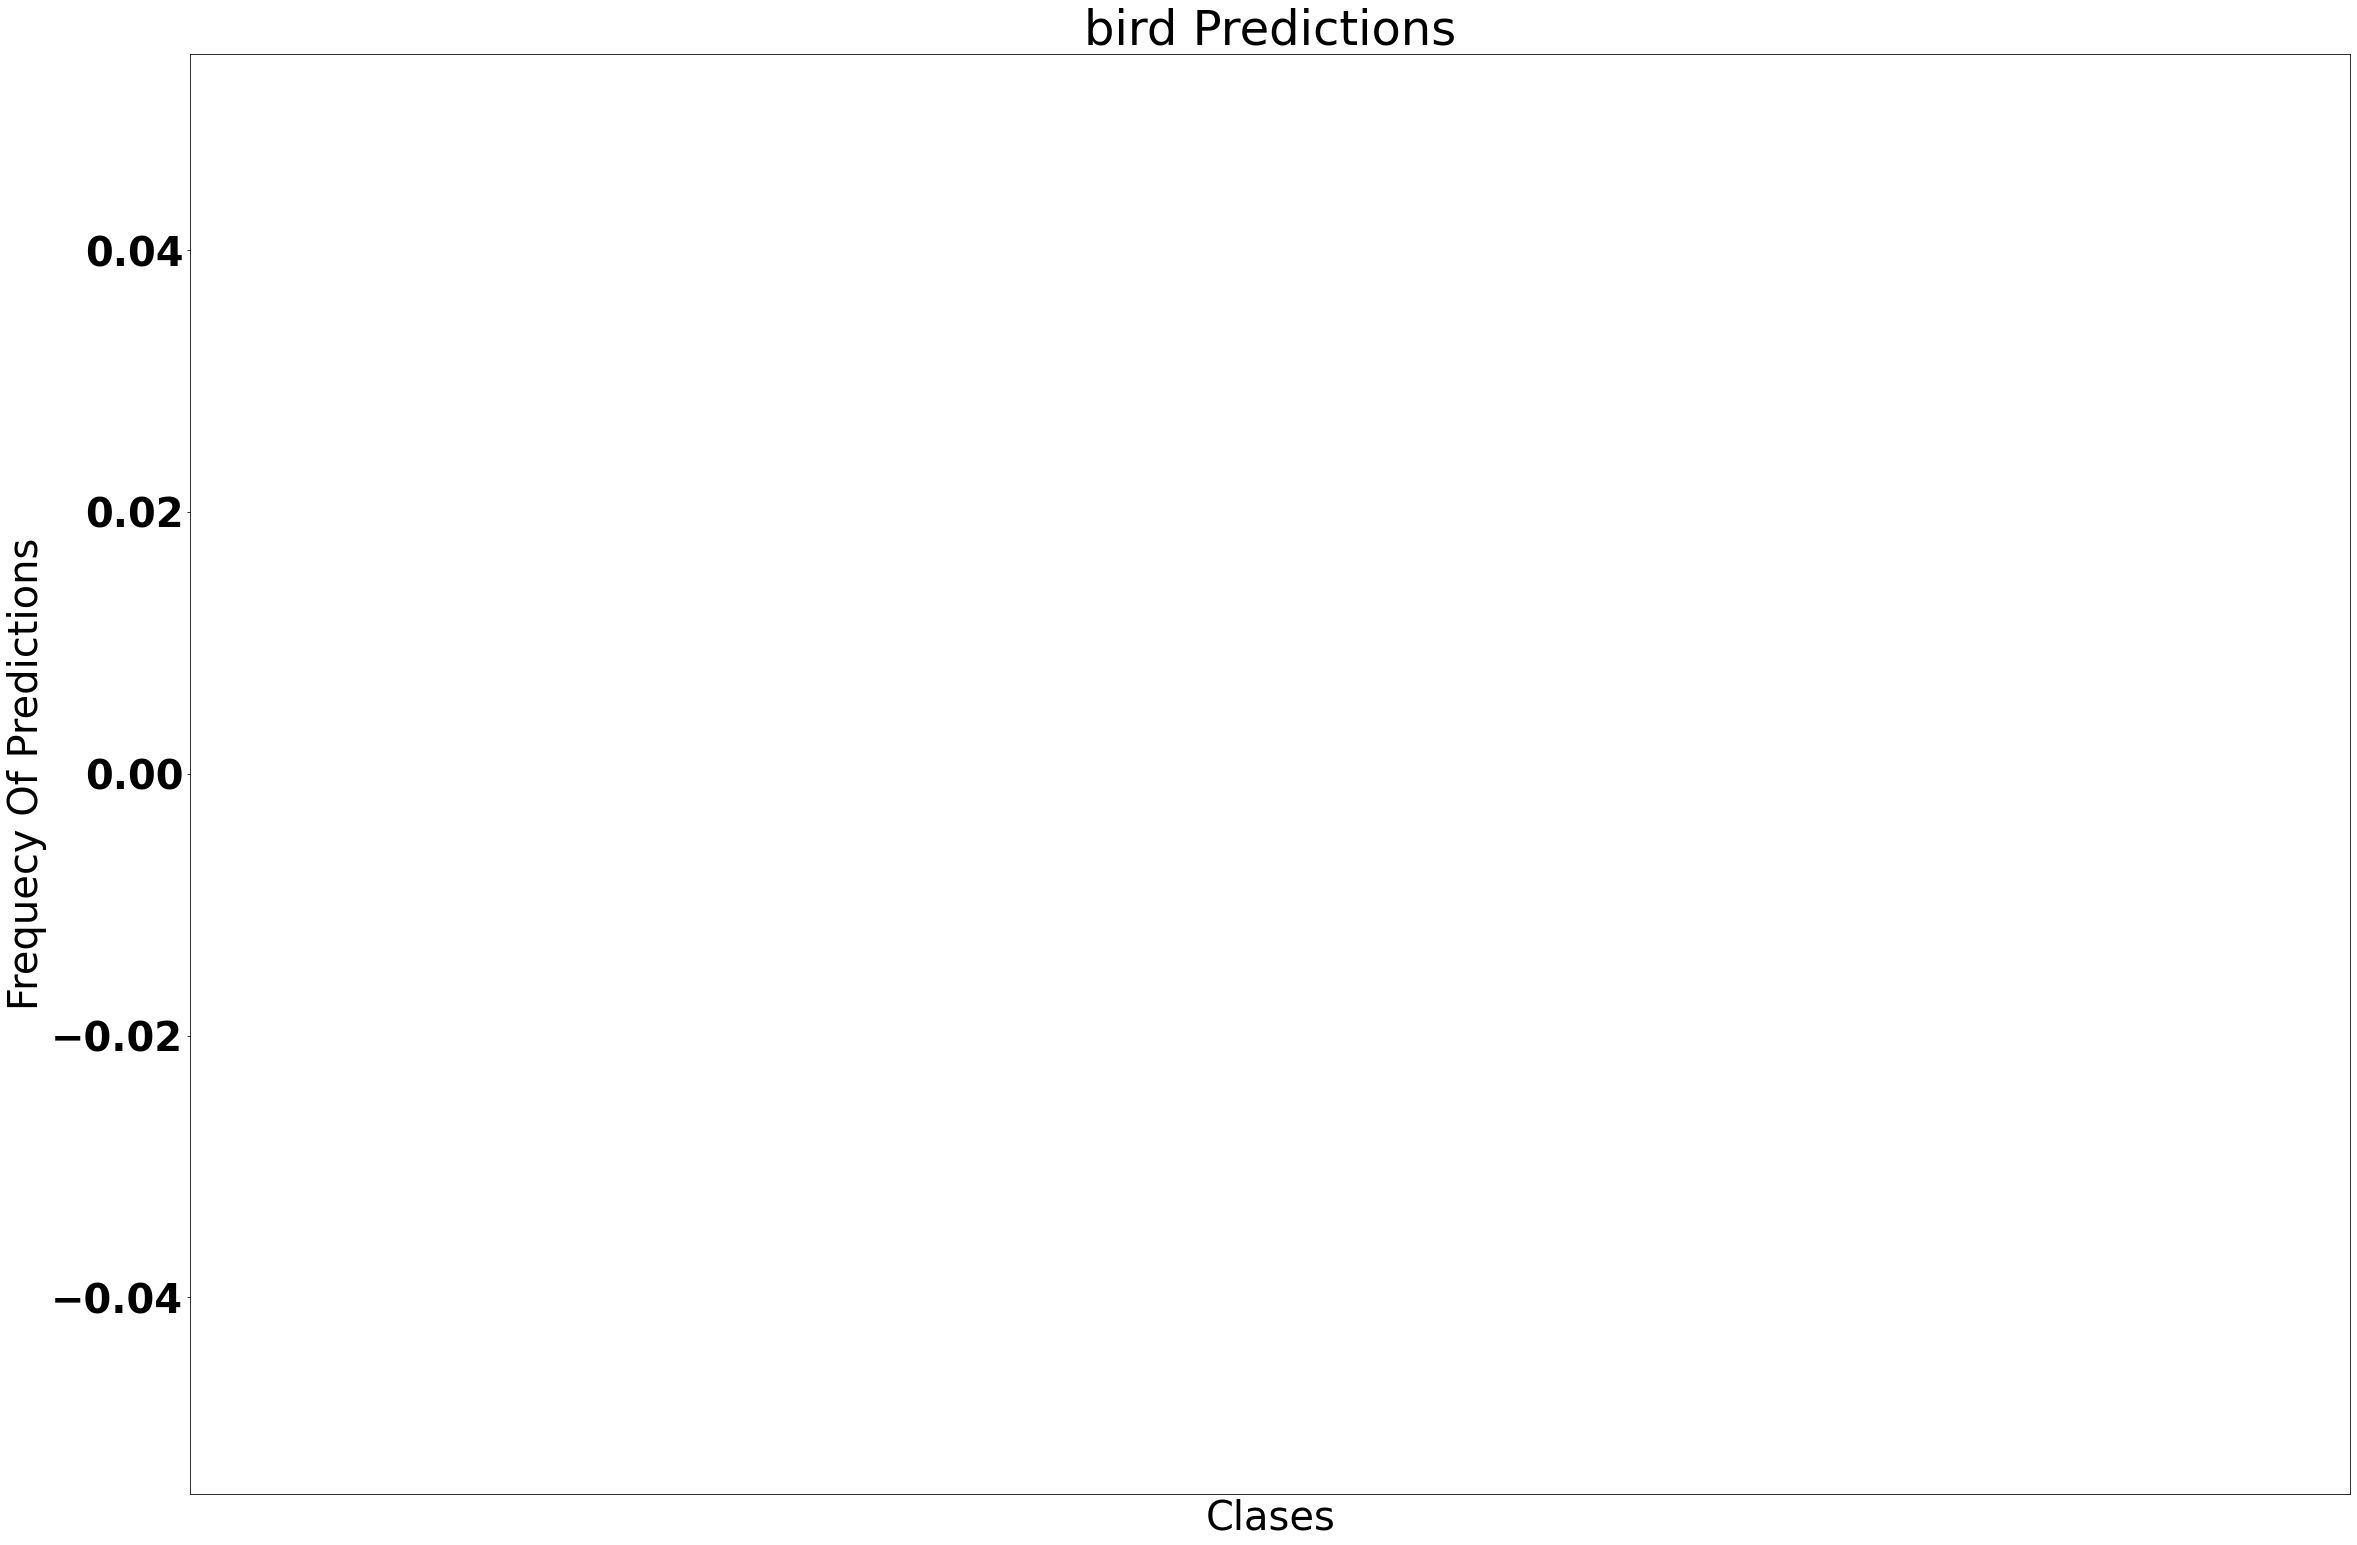

In [60]:
idx = 2
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

Class #3


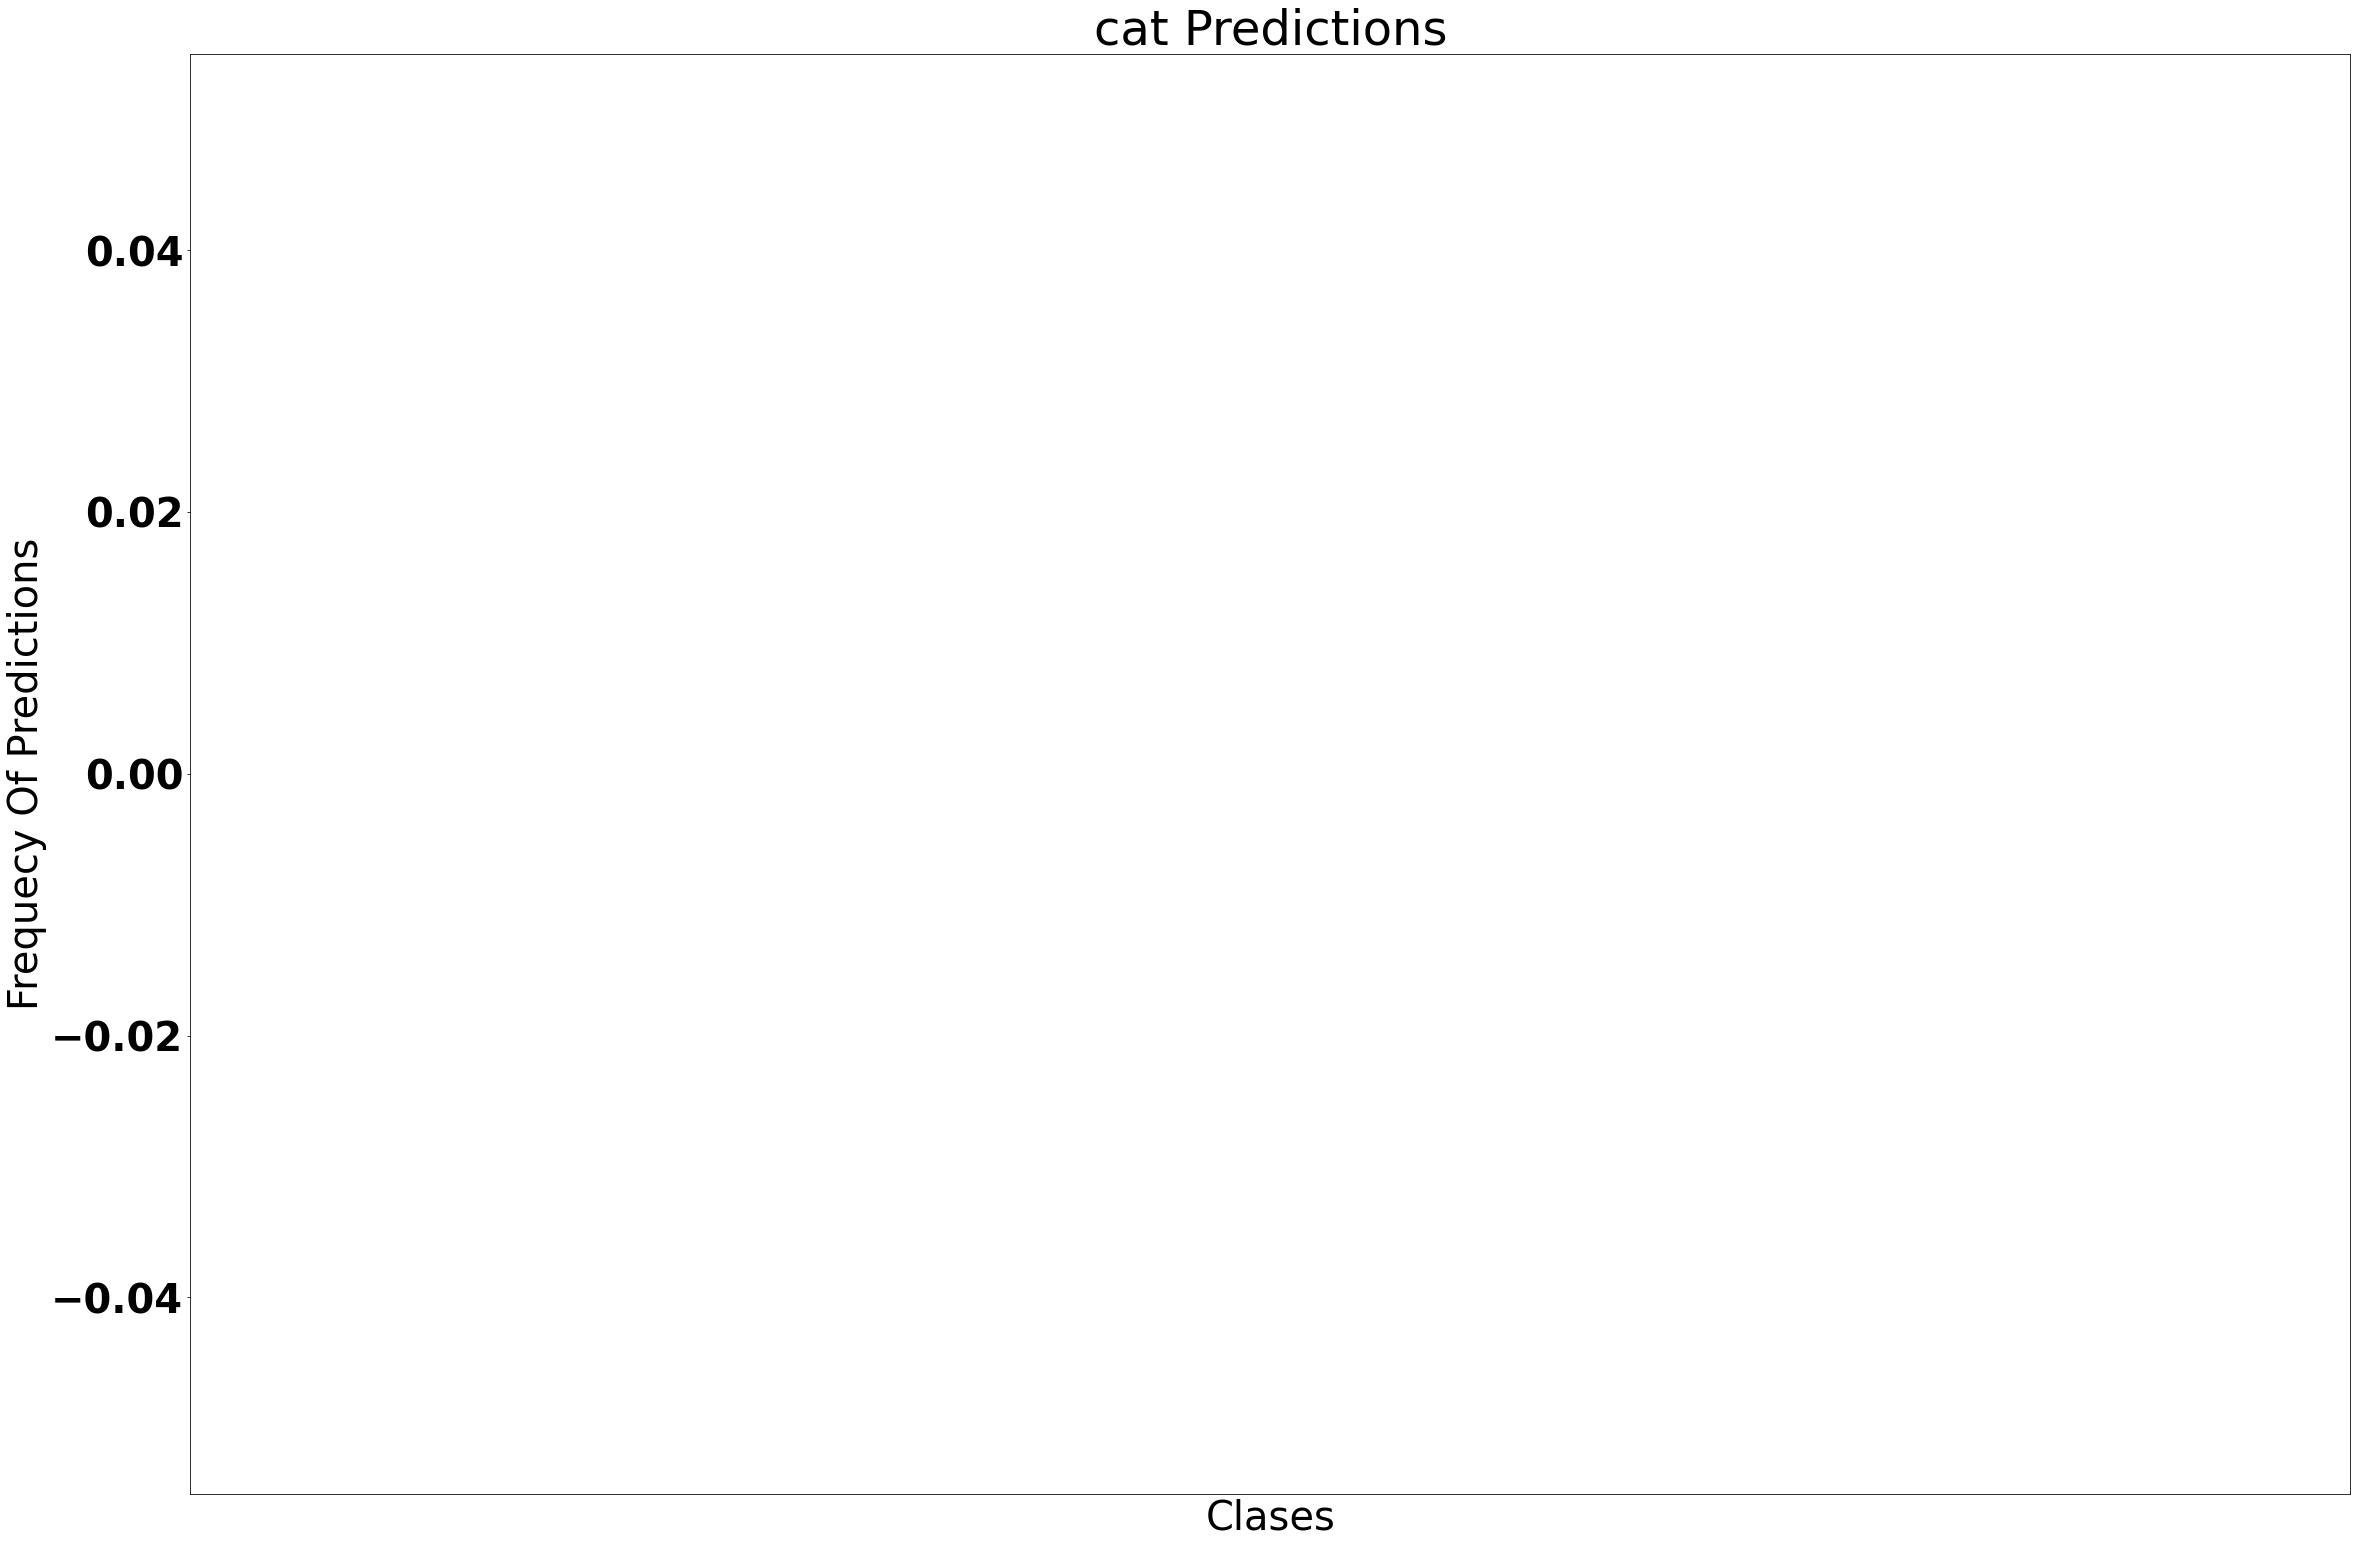

In [61]:
idx = 3
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

Class #4


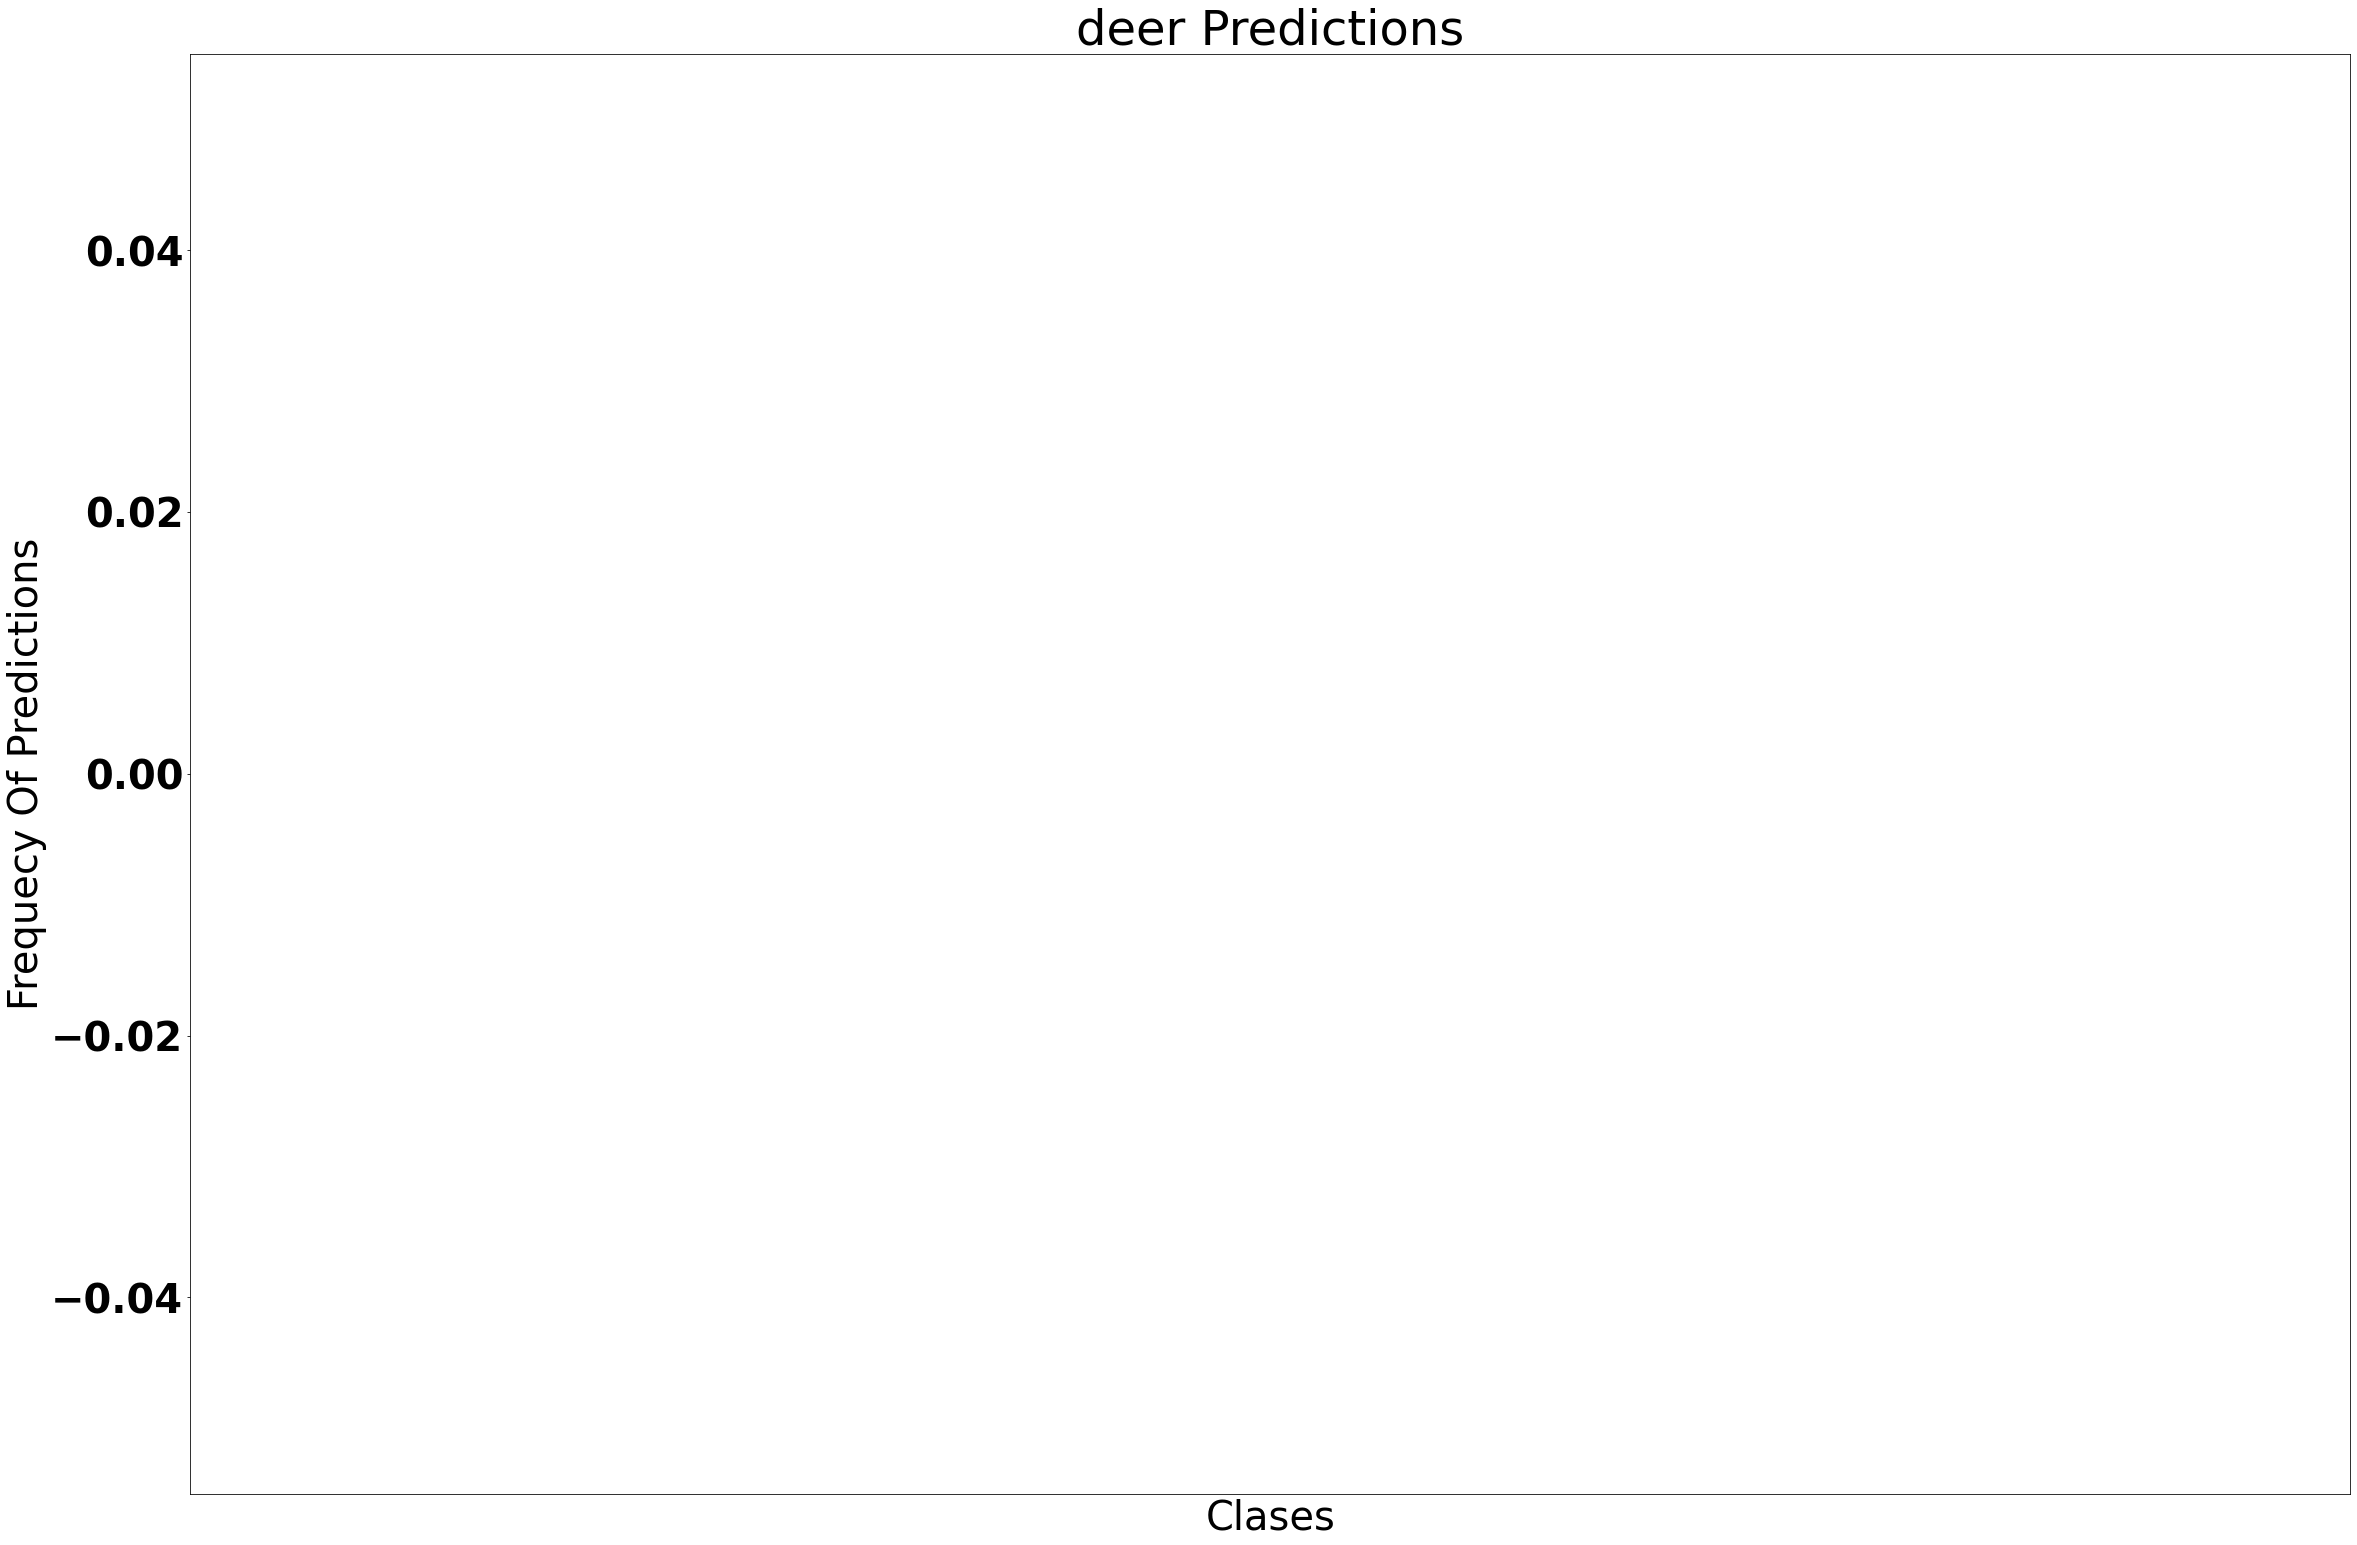

In [62]:
idx = 4
c = returnClassIndex(testY[hold_in_test_class_idx],idx)
plot_class_predictions(pred[c], idx,cclasses)

# Ensemble CNN The Skin Disease Dataset

In [63]:
gnd_truth = pd.read_csv("data/SkinDiseaseDataset/ISIC_2019_Training_GroundTruth.csv")
#aug_df = pd.read_csv("data/augmentImageNameLabels.csv")
gnd_truth.head()

IMG_NAMES = gnd_truth['image']
TRAIN_IMG_RT_PATH = 'data/ISIC_2019_Training_Input/'
TEST_IMG_RT_PATH = 'data/ISIC_2019_Test_Input'
### No Examples of UNK so drop it
labels = np.array(gnd_truth.drop(columns = ["image", "UNK"]))


## Dataset Summary

# of occurences
[ 4522 12875  3323   867  2624   239   253   628]
Classes
[0 1 2 3 4 5 6 7]


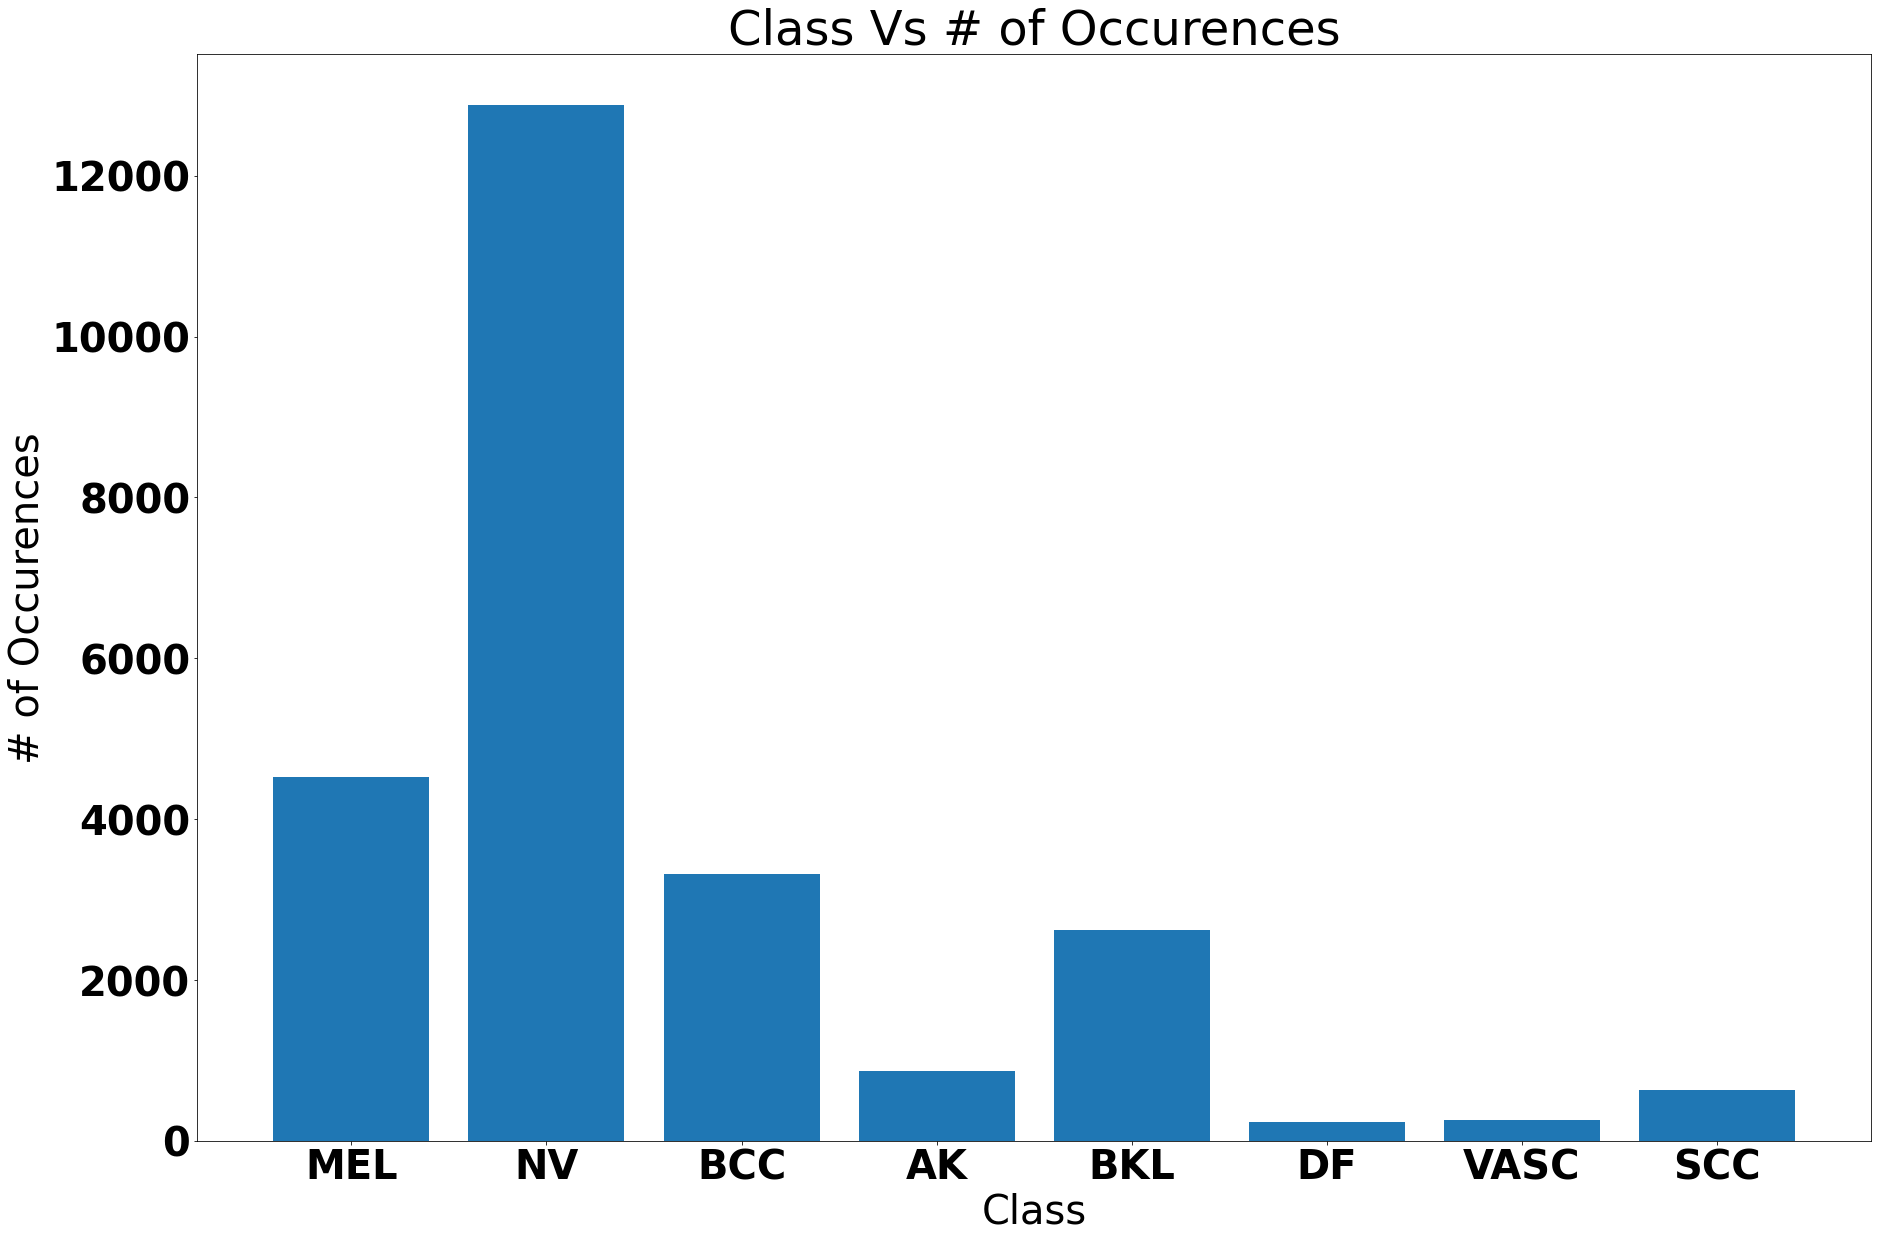

In [64]:
font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 40}
matplotlib.rc('font', **font)
fig = plt.figure( figsize = (30,20))
c, freq = np.unique(np.argmax(labels, axis= 1), return_counts = True)
plt.xlabel("Class")
plt.ylabel("# of Occurences")
plt.title("Class Vs # of Occurences")
plt.bar(gnd_truth.columns[1:-1],freq)
print("# of occurences")
print(freq)
print("Classes")
print(c)

In [65]:
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]


### Randomly Balance Sample from classes  
smpl_test_idxs = []
smpl_train_idxs = []
for i in range(len(labels[1])):
    idxs = np.array(returnClassIndex(labels, i))
    sel = np.random.RandomState(seed = 42).permutation(len(idxs))
    #print(len(idxs))
    ### Shuffle
    train_sel = list(sel[:int(0.75*len(idxs))])
    test_sel = list(sel[int(0.75*len(idxs)):])
    smpl_train_idxs += list(idxs[train_sel])
    smpl_test_idxs += list(idxs[test_sel])
paths = np.array([TRAIN_IMG_RT_PATH + m +'.jpg' for m in IMG_NAMES ])

In [66]:
im_size =200
channels = 3
num_classes = 8
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0
keep_prob =  0
batch_size = 16

In [67]:
### Dataframes for Generator
train_df = pd.DataFrame({"filename":paths[smpl_train_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_train_idxs].astype(str)})
test_df = pd.DataFrame({"filename":paths[smpl_test_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_test_idxs].astype(str)})

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True,
        vertical_flip = True,
        shear_range=0.5,
        zoom_range=0.5,
        rotation_range = 30
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size)
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size)
)

Found 18996 validated image filenames belonging to 8 classes.
Found 6335 validated image filenames belonging to 8 classes.


In [68]:
skin_trainY = []
skin_feat_train = []
for i in tqdm(range(len(train_generator))):
    tmp = next(train_generator)
    skin_feat_train.append(extractor0.predict(tmp[0]))
    skin_trainY.append(tmp[1])

100%|██████████| 1188/1188 [11:58<00:00,  1.65it/s]


In [69]:
skin_testY = []
skin_feat_test = []
for i in tqdm(range(len(test_generator))):
    tmp = next(test_generator)
    skin_feat_test.append(extractor0.predict(tmp[0]))
    skin_testY.append(tmp[1])

100%|██████████| 396/396 [03:29<00:00,  1.89it/s]


In [70]:
skin_trainY_ = np.vstack(skin_trainY)
skin_train_feat_ = np.vstack(skin_feat_train)
skin_testY_ = np.vstack(skin_testY)
skin_test_feat_ = np.vstack(skin_feat_test)

In [71]:
### Selecting the classes
hold_in_train_class = [0,1,2,3]
hold_in_train_class_idx = []
for i in hold_in_train_class:
    hold_in_train_class_idx = hold_in_train_class_idx + returnClassIndex(skin_trainY_,i)

### Selecting the classes
hold_in_test_class = [0,1,2,3]
hold_in_test_class_idx = []
for i in hold_in_test_class:
    hold_in_test_class_idx = hold_in_test_class_idx + returnClassIndex(skin_testY_,i)

# Skin Sub-Model 0

In [124]:
inputs = Input((128))
x = BatchNormalization()(inputs)
x = Dense(64, activation = tf.keras.layers.LeakyReLU())(x)
x = Dropout(0.5)(x)
x = Dense(32, activation = tf.keras.layers.LeakyReLU())(x)
output = Dense(8, activation ='softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs = output)

In [125]:
op = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
)
model.compile(optimizer = op, 
              loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()


Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dense_32 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 264       
Total params: 11,112
Trainable params: 10,856
Non-trainable params: 256
_______________________________________________

In [126]:
mycallbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True),
    tf.keras.callbacks.TerminateOnNaN()
]
history = model.fit(skin_train_feat_[hold_in_train_class_idx],skin_trainY_[hold_in_train_class_idx],
                    callbacks= mycallbacks, epochs = 1, verbose = 1,
                    validation_data = (skin_test_feat_[hold_in_test_class_idx],
                                       skin_testY_[hold_in_test_class_idx])
                   )

506/506 [==============================] - 1s 2ms/step - loss: 0.8709 - acc: 0.6951 - val_loss: 5.4704 - val_acc: 0.0000e+00


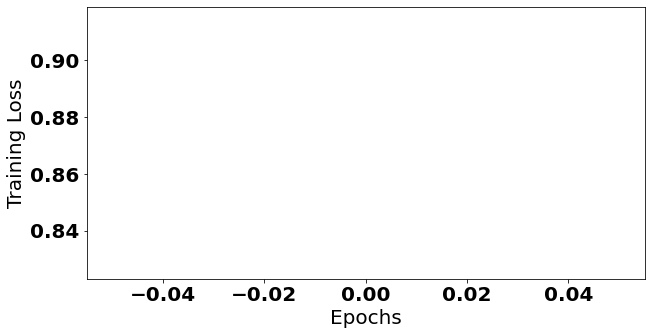

In [127]:
loss = history.history['loss']
ep = np.arange(len(loss))
font = {'family' : 'sans',
            'weight' : 'bold',
            'size'   : 20}
matplotlib.rc('font', **font)

plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

In [128]:
model.evaluate(skin_test_feat_[hold_in_test_class_idx],
               skin_testY_[hold_in_test_class_idx])
model.save("Models/skin_en_model.h5")
print("Model is Saved!")

30/30 [==============================] - 0s 1ms/step - loss: 5.4704 - acc: 0.0000e+00
Model is Saved!


# Skin Sub-Model 1

In [129]:
inputs1 = Input((128))
x1 = BatchNormalization()(inputs1)
x1 = Dense(64, activation = 'elu')(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(32, activation = 'elu' )(x1)
output1 = Dense(8, activation ='softmax')(x1)
model1 = tf.keras.Model(inputs = inputs1, outputs = output1)

In [130]:
op1 = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop"
)
model1.compile(optimizer = op1, 
              loss = 'categorical_crossentropy', metrics = ['acc'])
model1.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 264       
Total params: 11,112
Trainable params: 10,856
Non-trainable params: 256
_______________________________________________

In [131]:
mycallbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True),
    tf.keras.callbacks.TerminateOnNaN()
]
history1 = model1.fit(skin_train_feat_[hold_in_train_class_idx],skin_trainY_[hold_in_train_class_idx],
                      callbacks= mycallbacks, epochs = 1, verbose = 1,
                      validation_data = (skin_test_feat_[hold_in_test_class_idx], 
                                         skin_testY_[hold_in_test_class_idx]) 
                     )

506/506 [==============================] - 1s 2ms/step - loss: 0.7195 - acc: 0.7390 - val_loss: 9.2115 - val_acc: 0.0000e+00


In [132]:
model1.evaluate(skin_test_feat_[hold_in_test_class_idx],
                skin_testY_[hold_in_test_class_idx])
model1.save("Models/skin_en_model1.h5")
print("Model is Saved!")

30/30 [==============================] - 0s 1ms/step - loss: 9.2115 - acc: 0.0000e+00
Model is Saved!


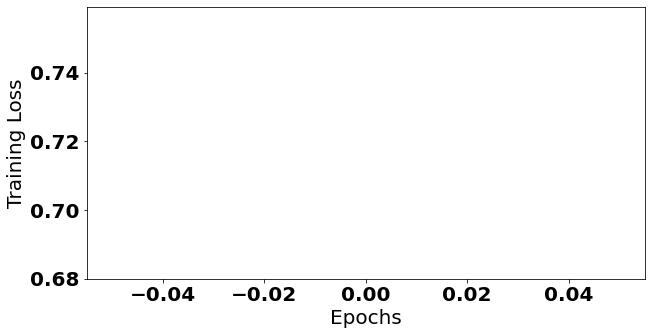

In [133]:
loss = history1.history['loss']
ep = np.arange(len(loss))
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

# Skin Sub-Model 2

In [134]:
inputs2 = Input((128))
x2 = BatchNormalization()(inputs2)
x2 = Dense(64, activation = 'relu')(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(32, activation = 'relu' )(x2)
output2 = Dense(8, activation ='softmax')(x2)
model2 = tf.keras.Model(inputs = inputs2, outputs = output2)

In [135]:
op2 = tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)
model2.compile(optimizer = op2, 
              loss = 'categorical_crossentropy', metrics = ['acc'])

In [136]:
model2.summary()

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 264       
Total params: 11,112
Trainable params: 10,856
Non-trainable params: 256
_______________________________________________

In [137]:
history2 = model2.fit(skin_train_feat_[hold_in_train_class_idx],
                      skin_trainY_[hold_in_train_class_idx],
                      callbacks= mycallbacks, epochs = 1, verbose = 1, 
                      validation_data = (skin_test_feat_[hold_in_test_class_idx], 
                                                      skin_testY_[hold_in_test_class_idx])
                     )
model2.evaluate(skin_test_feat_[hold_in_test_class_idx],
                skin_testY_[hold_in_test_class_idx])

30/30 [==============================] - 0s 938us/step - loss: 8.3955 - acc: 0.0000e+00


[8.395485877990723, 0.0]

In [138]:
model2.evaluate(skin_test_feat_[hold_in_test_class_idx],
                skin_testY_[hold_in_test_class_idx])
model2.save("Models/skin_en_model2.h5")
print("Model is Saved!")

30/30 [==============================] - 0s 1ms/step - loss: 8.3955 - acc: 0.0000e+00
Model is Saved!


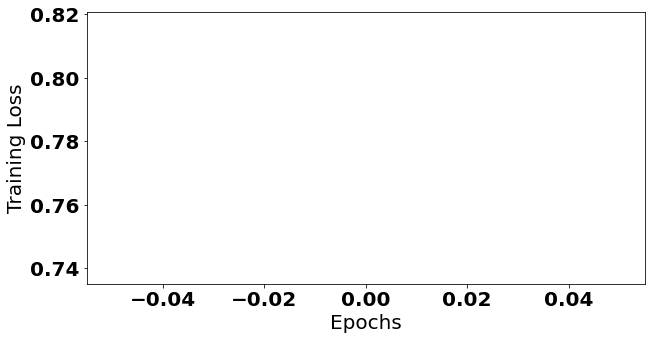

In [139]:
loss = history2.history['loss']
ep = np.arange(len(loss))
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

# Skin Sub-Model 3

In [140]:
inputs3 = Input((128))
x3 = BatchNormalization()(inputs3)
x3 = Dense(64, activation = 'relu')(x3)
x3 = Dropout(0.6)(x3)
x3 = Dense(32, activation = 'relu' )(x3)
x3 = Dropout(0.2)(x3)
x3 = Dense(16, activation = 'relu' )(x3)
output3 = Dense(8, activation ='softmax')(x3)
model3 = tf.keras.Model(inputs = inputs3, outputs = output3)

In [141]:
model3.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
              loss = 'categorical_crossentropy', metrics = ['acc'])

In [142]:
model3.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)              

In [143]:
skin_trainY_[hold_in_train_class_idx].shape

(16189, 8)

In [144]:
history3 = model3.fit(skin_train_feat_[hold_in_train_class_idx],
                      skin_trainY_[hold_in_train_class_idx],
                      callbacks= mycallbacks, epochs = 1, verbose = 1,
                      validation_data = (skin_test_feat_[hold_in_test_class_idx], 
                             skin_testY_[hold_in_test_class_idx])
                     )
model3.evaluate(skin_test_feat_[hold_in_test_class_idx],
                skin_testY_[hold_in_test_class_idx]
               )

30/30 [==============================] - 0s 987us/step - loss: 8.3925 - acc: 0.0000e+00


[8.392491340637207, 0.0]

In [145]:
model3.save("Models/skin_en_model3.h5")
print("Model is Saved!")

Model is Saved!


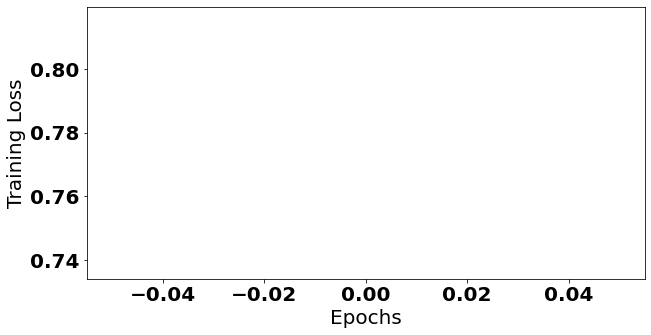

In [146]:
loss = history3.history['loss']
ep = np.arange(len(loss))
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

# Skin Sub-Model 4

In [147]:
inputs4 = Input((128))
x4 = BatchNormalization()(inputs4)
x4 = Dense(64, activation = 'relu')(x4)
x4 = Dense(32, activation = 'relu' )(x4)
output4 = Dense(8, activation ='softmax')(x4)
model4 = tf.keras.Model(inputs = inputs4, outputs = output4)

In [148]:
op4 = tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad"
)
model4.compile(optimizer = op4, 
              loss = 'categorical_crossentropy', metrics = ['acc'])

In [149]:
model4.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
_________________________________________________________________
dense_45 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_47 (Dense)             (None, 8)                 264       
Total params: 11,112
Trainable params: 10,856
Non-trainable params: 256
_________________________________________________________________


In [150]:
history4 = model4.fit(skin_train_feat_[hold_in_train_class_idx],
                      skin_trainY_[hold_in_train_class_idx], 
                      callbacks= mycallbacks,epochs = 2, verbose = 1, 
                      validation_data = (skin_test_feat_[hold_in_test_class_idx],
                                                      skin_testY_[hold_in_test_class_idx])
                     )
model4.evaluate(skin_test_feat_[hold_in_test_class_idx],
                skin_testY_[hold_in_test_class_idx]
               )

Epoch 1/2
506/506 [==============================] - 1s 2ms/step - loss: 1.4501 - acc: 0.5210 - val_loss: 2.6357 - val_acc: 0.0064
Epoch 2/2
30/30 [==============================] - 0s 1ms/step - loss: 3.2815 - acc: 0.0000e+00


[3.281529426574707, 0.0]

In [151]:
model4.save("Models/skin_en_model4.h5")
print("Model is Saved!")

Model is Saved!


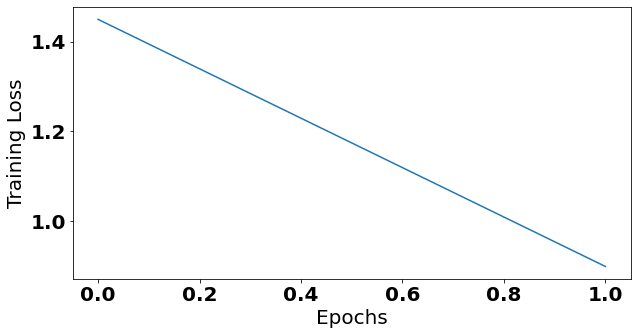

In [152]:
loss = history4.history['loss']
ep = np.arange(len(loss))
plt.figure(figsize =(10,5))
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(ep, loss)

## Skin Disease No new class

In [153]:
hold_in_test_class = [0,1,2,3]
hold_in_test_class_idx = []
for i in hold_in_test_class:
    hold_in_test_class_idx = hold_in_test_class_idx + returnClassIndex(skin_testY_,i)

In [154]:
print("Performing Predictions")
### get Predictions
from scipy.stats import mode
MODELS = [model1,model1,model2,model3,model4]
preds = []
for m in MODELS:
    preds.append(m.predict(skin_test_feat_[hold_in_test_class_idx], verbose = 1))
p1 =np.vstack([np.argmax(p, axis = 1) for p in preds]).T
s_pred,c =mode(p1, axis = 1)
s_groundTruth = np.argmax(skin_testY_[hold_in_test_class_idx], axis = 1)

Performing Predictions
169/169 [==============================] - 0s 587us/step


In [155]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(s_groundTruth, s_pred, average = "macro")
acc = accuracy_score(s_groundTruth, s_pred)
recall = recall_score(s_groundTruth, s_pred,   average = "macro")

precision =precision_score(s_groundTruth, s_pred, average = "macro")
loss = log_loss(skin_testY_[hold_in_test_class_idx], tf.keras.utils.to_categorical(s_pred, num_classes =8 ))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 12.374581984653876
Accuracy: 0.6417191552426825
F1 Score: 0.3105894180568608
recall Score: 0.32041261880674304
Precision Score: 0.4935749373799678


/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


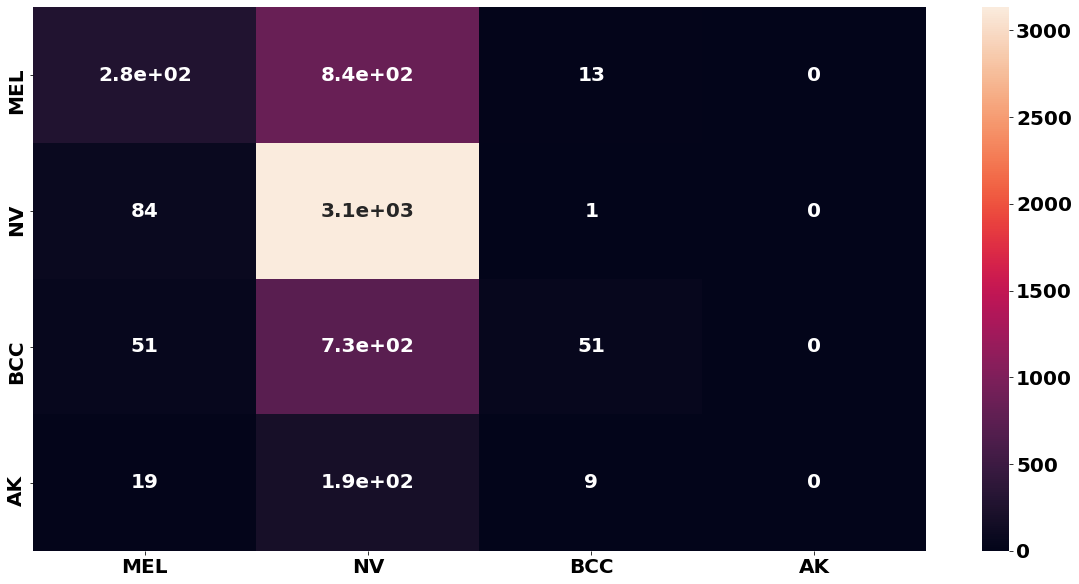

In [156]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(s_groundTruth,s_pred)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
labels_names = list(gnd_truth.columns[1:-1])[:4]
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('saveed_figures/en_cnn/enconf1_skin_dis_no_newclass.png', dpi = 200)
plt.savefig('saveed_figures/en_cnn/enconf1_skin_dis_no_newclass.pdf', dpi = 200)

/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
<ipython-input-157-8a614d8c1ffc>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


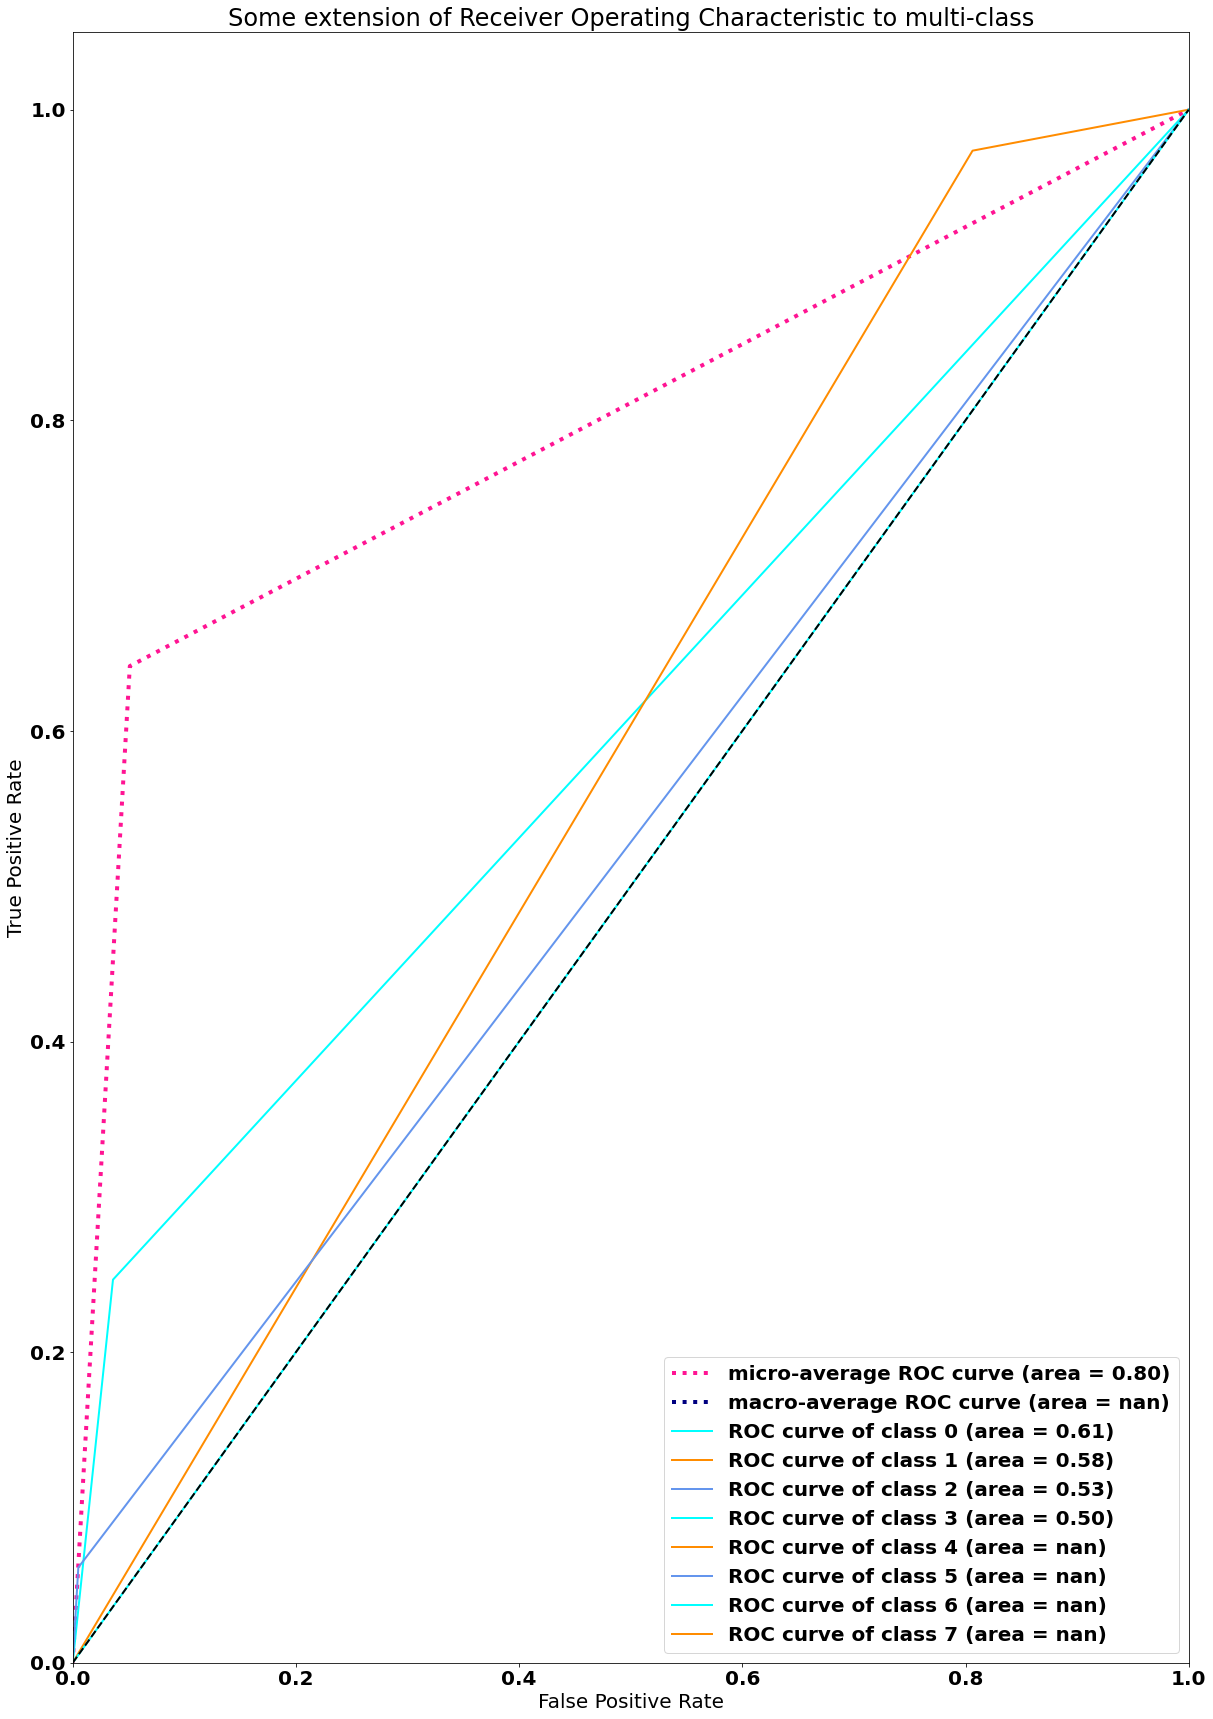

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(skin_testY_[hold_in_test_class_idx])
y_score = np.copy(tf.keras.utils.to_categorical(s_pred, num_classes =8))
n_classes =  8
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('saveed_figures/en_cnn/enrocf_skin_dis_no_newclass.png', dpi = 200)
plt.savefig('saveed_figures/en_cnn/enrocf_skin_dis_no_newclass.pdf', dpi = 200)
plt.show()


In [158]:
sclasses =list(gnd_truth.columns[1:-1])[:4]

Missing classes on the bar chart indicate that there are no prediction for them

Class #0


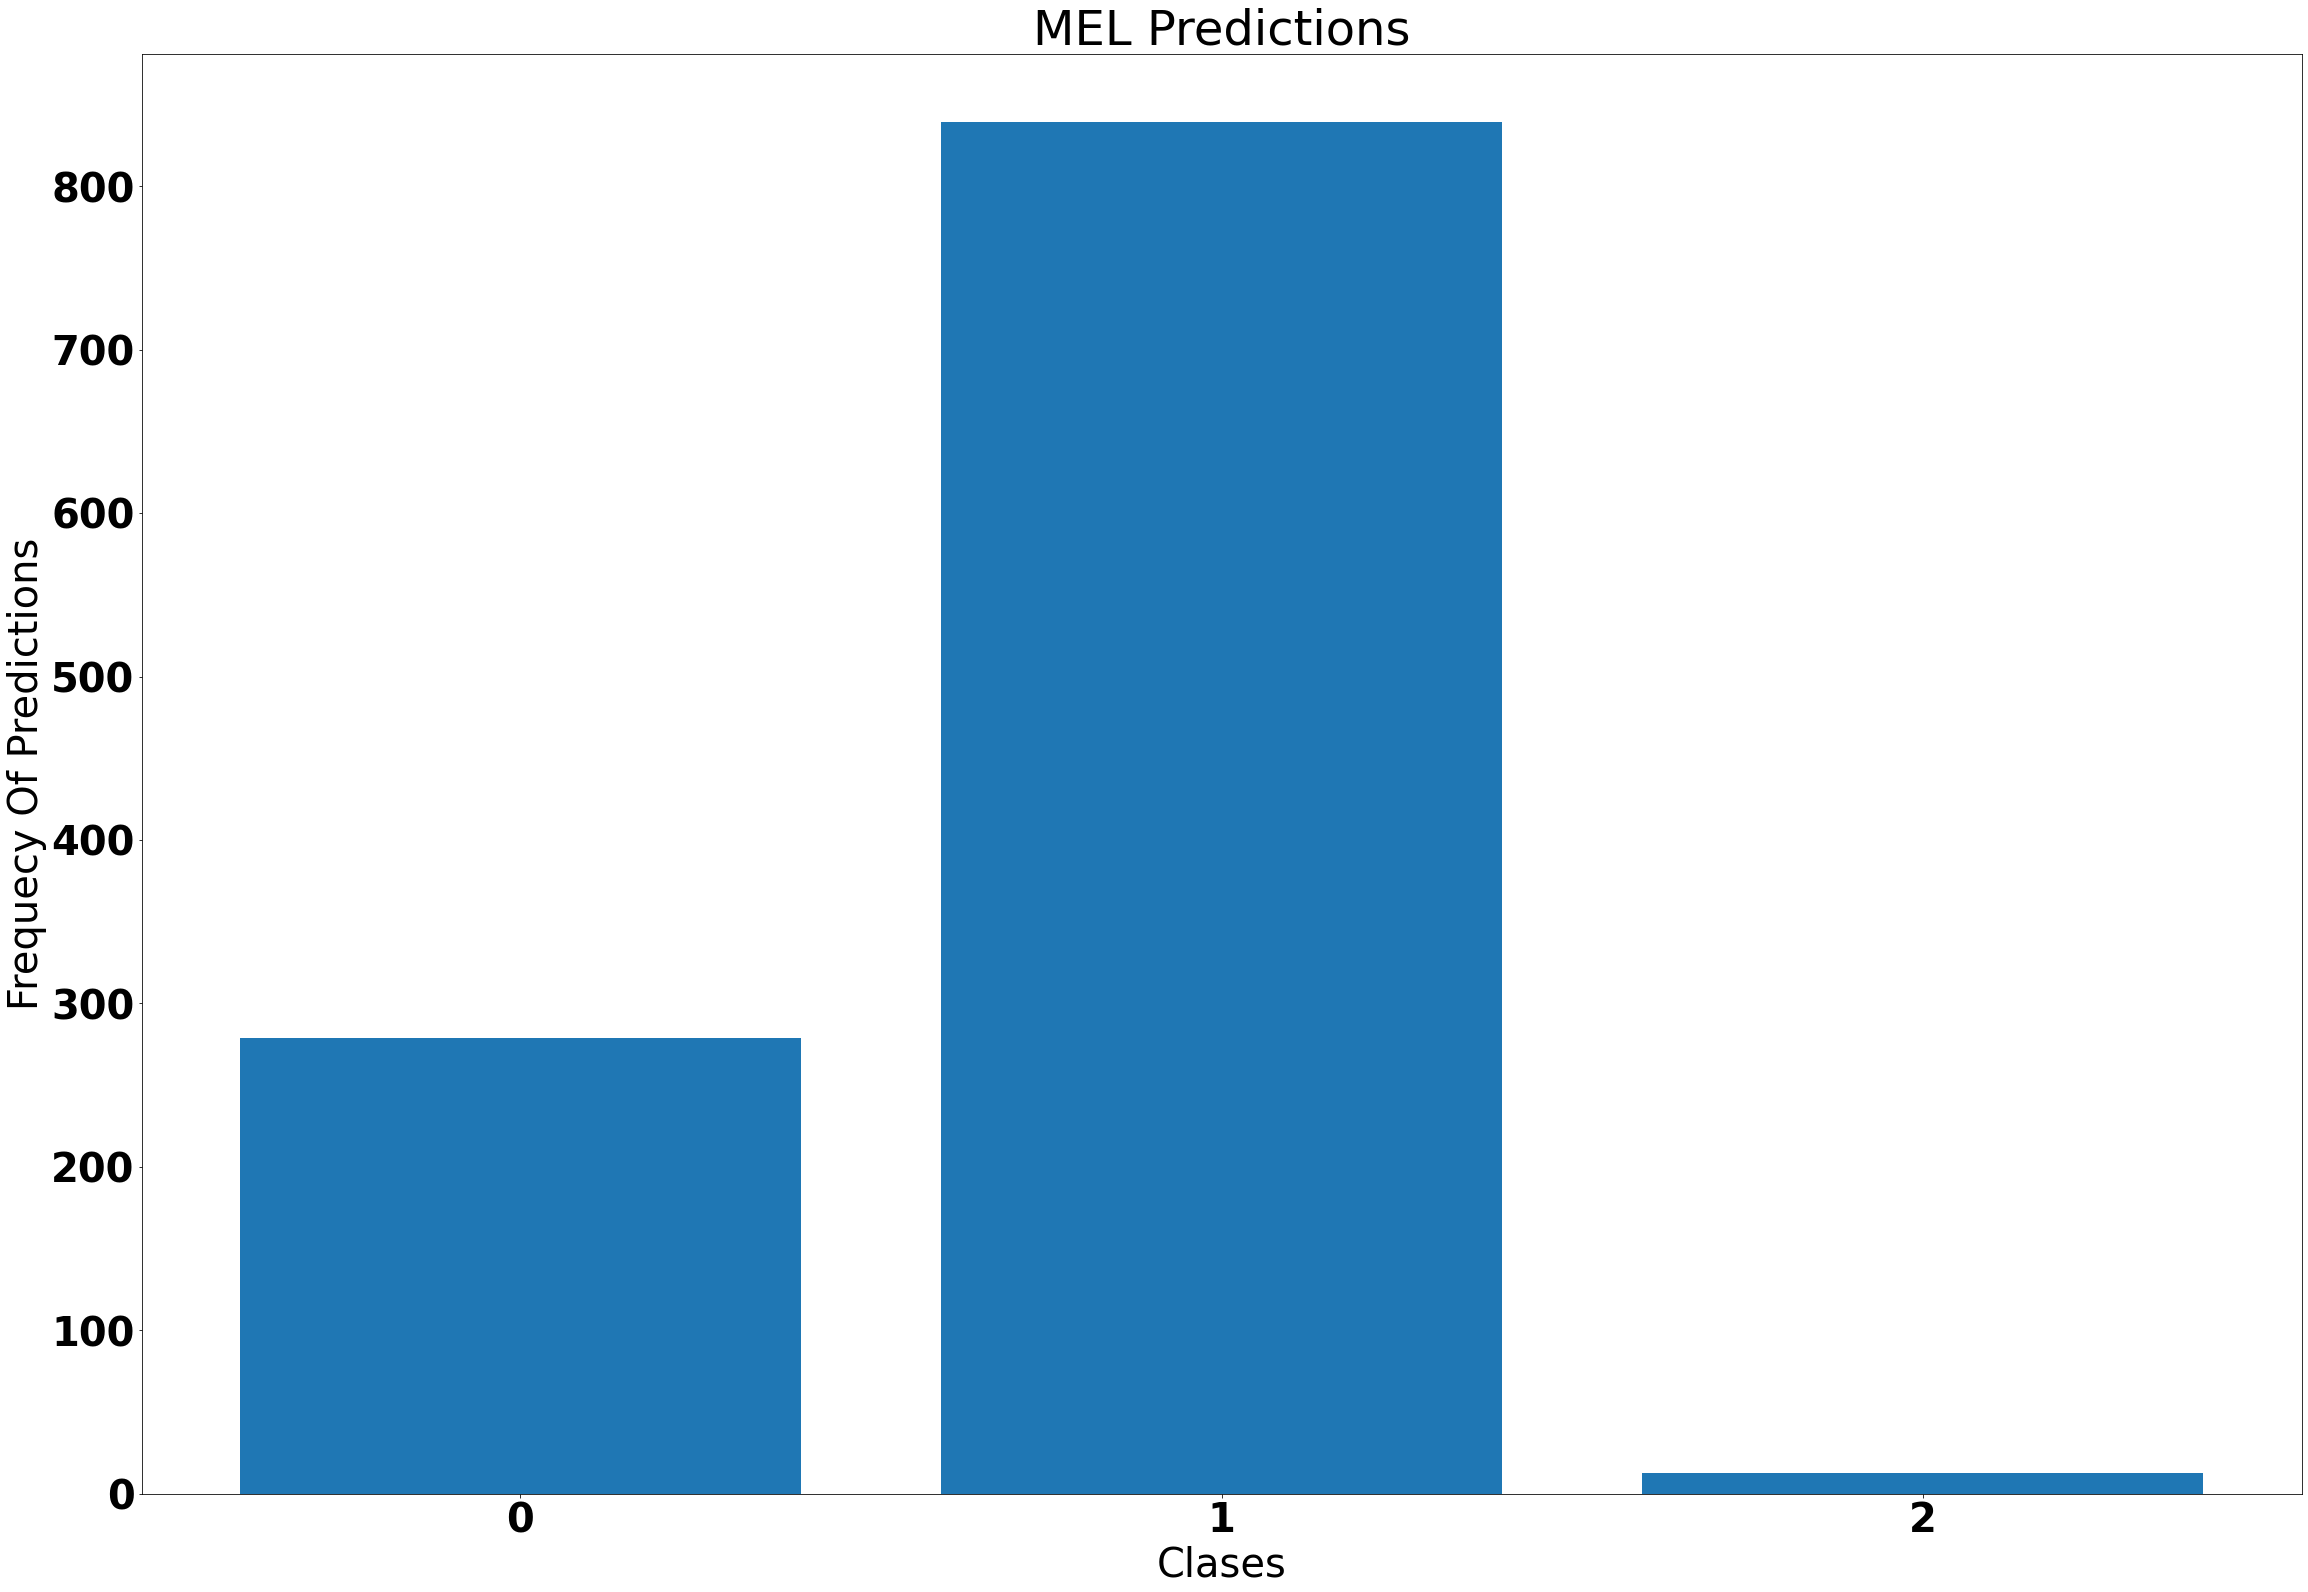

In [159]:
idx = 0
c = returnClassIndex(skin_testY_[hold_in_test_class_idx],idx)
plot_class_predictions(s_pred[c], idx,sclasses)

Class #1


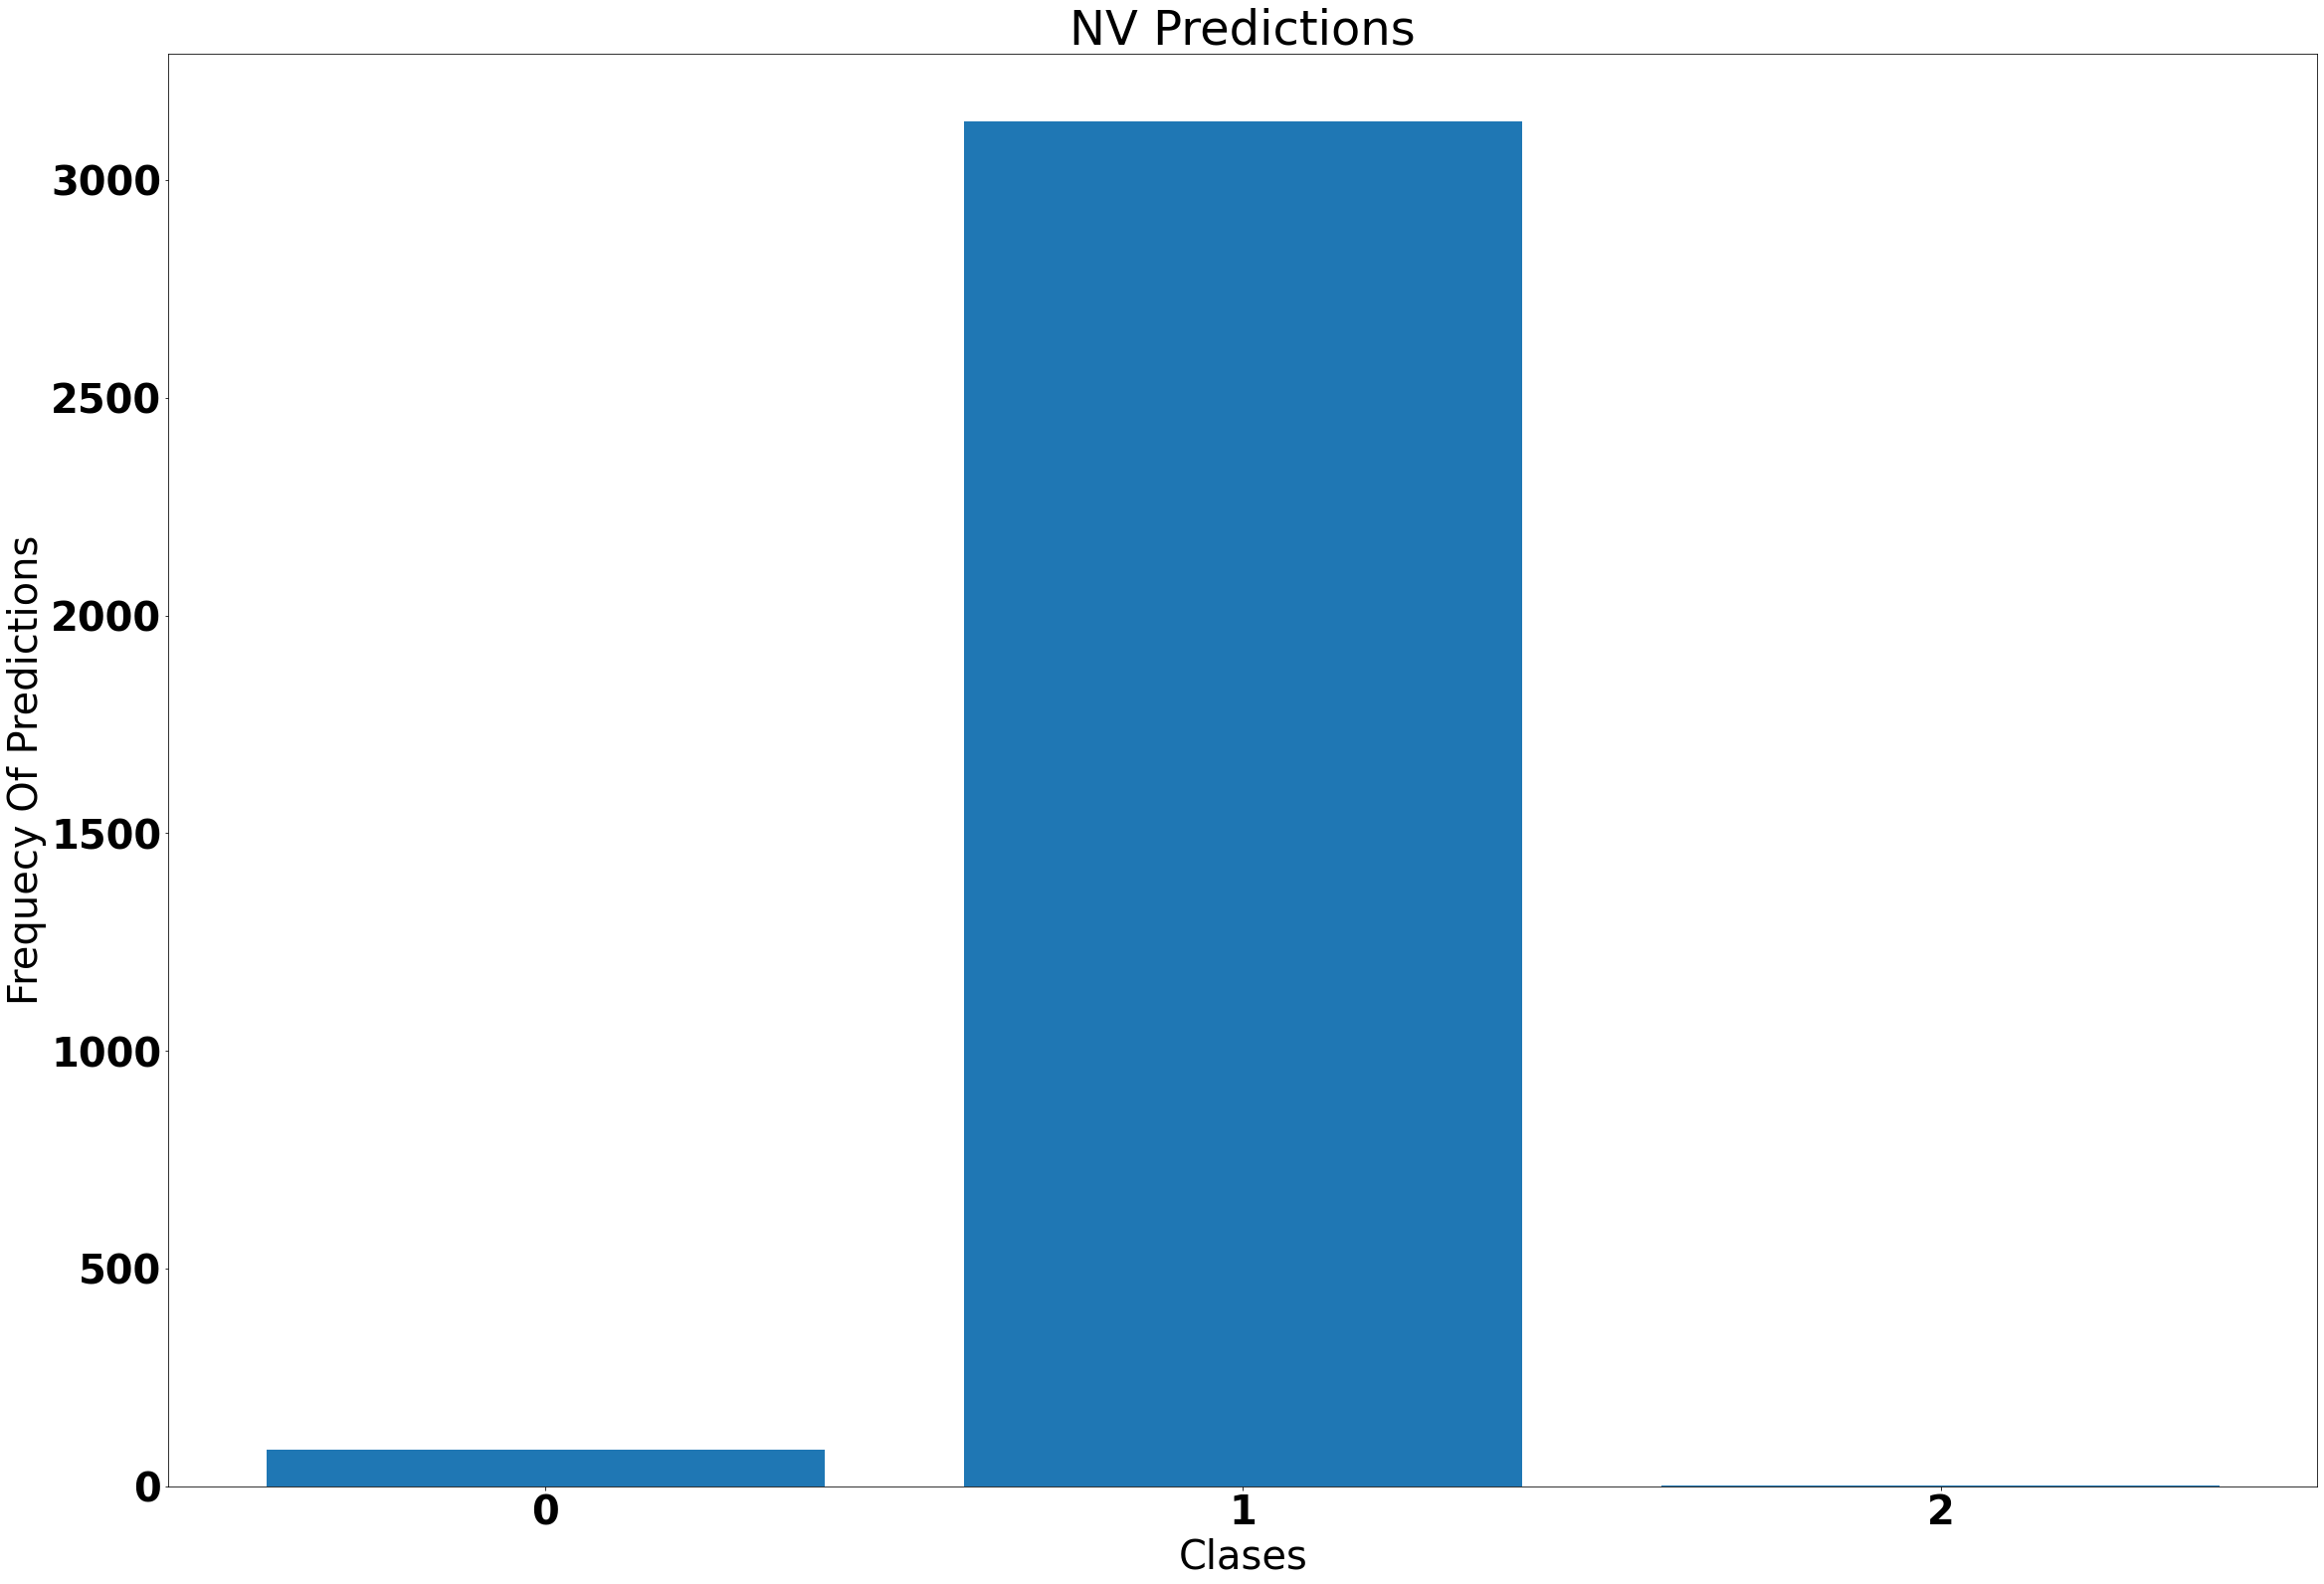

In [160]:
idx = 1
c = returnClassIndex(skin_testY_[hold_in_test_class_idx],idx)
plot_class_predictions(s_pred[c], idx,sclasses)

Class #2


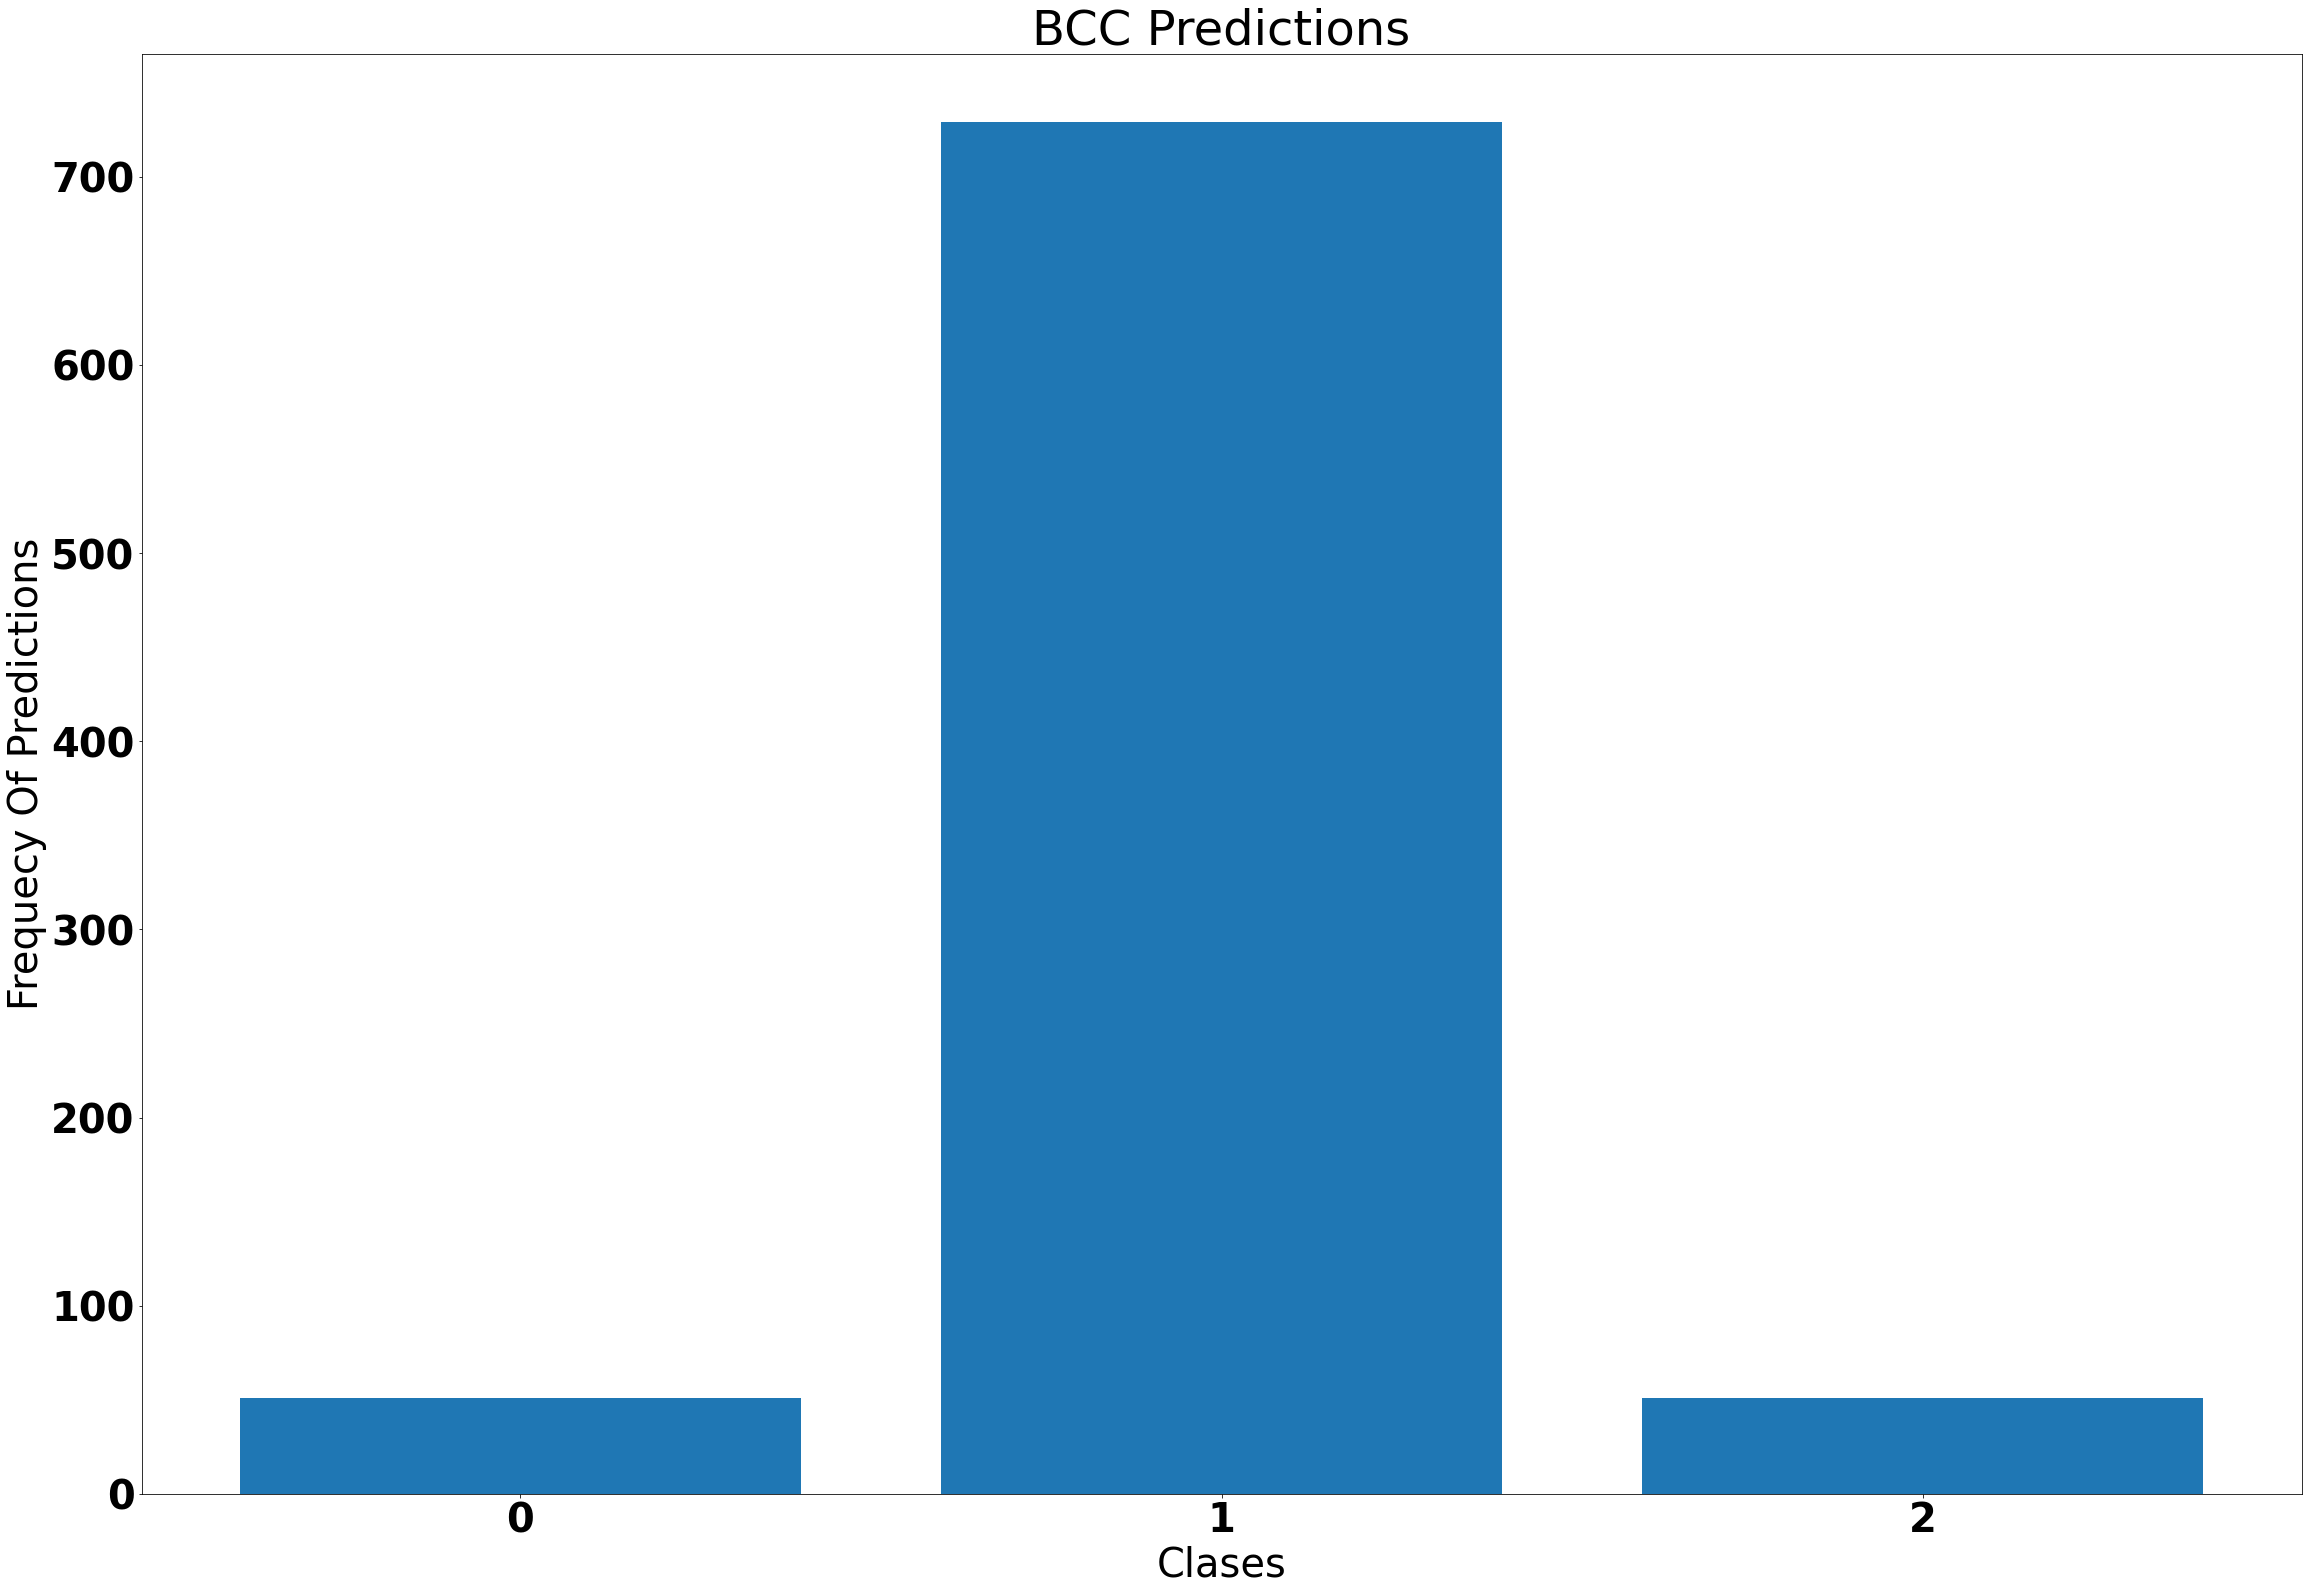

In [161]:
idx = 2
c = returnClassIndex(skin_testY_[hold_in_test_class_idx],idx)
plot_class_predictions(s_pred[c], idx,sclasses)

Class #3


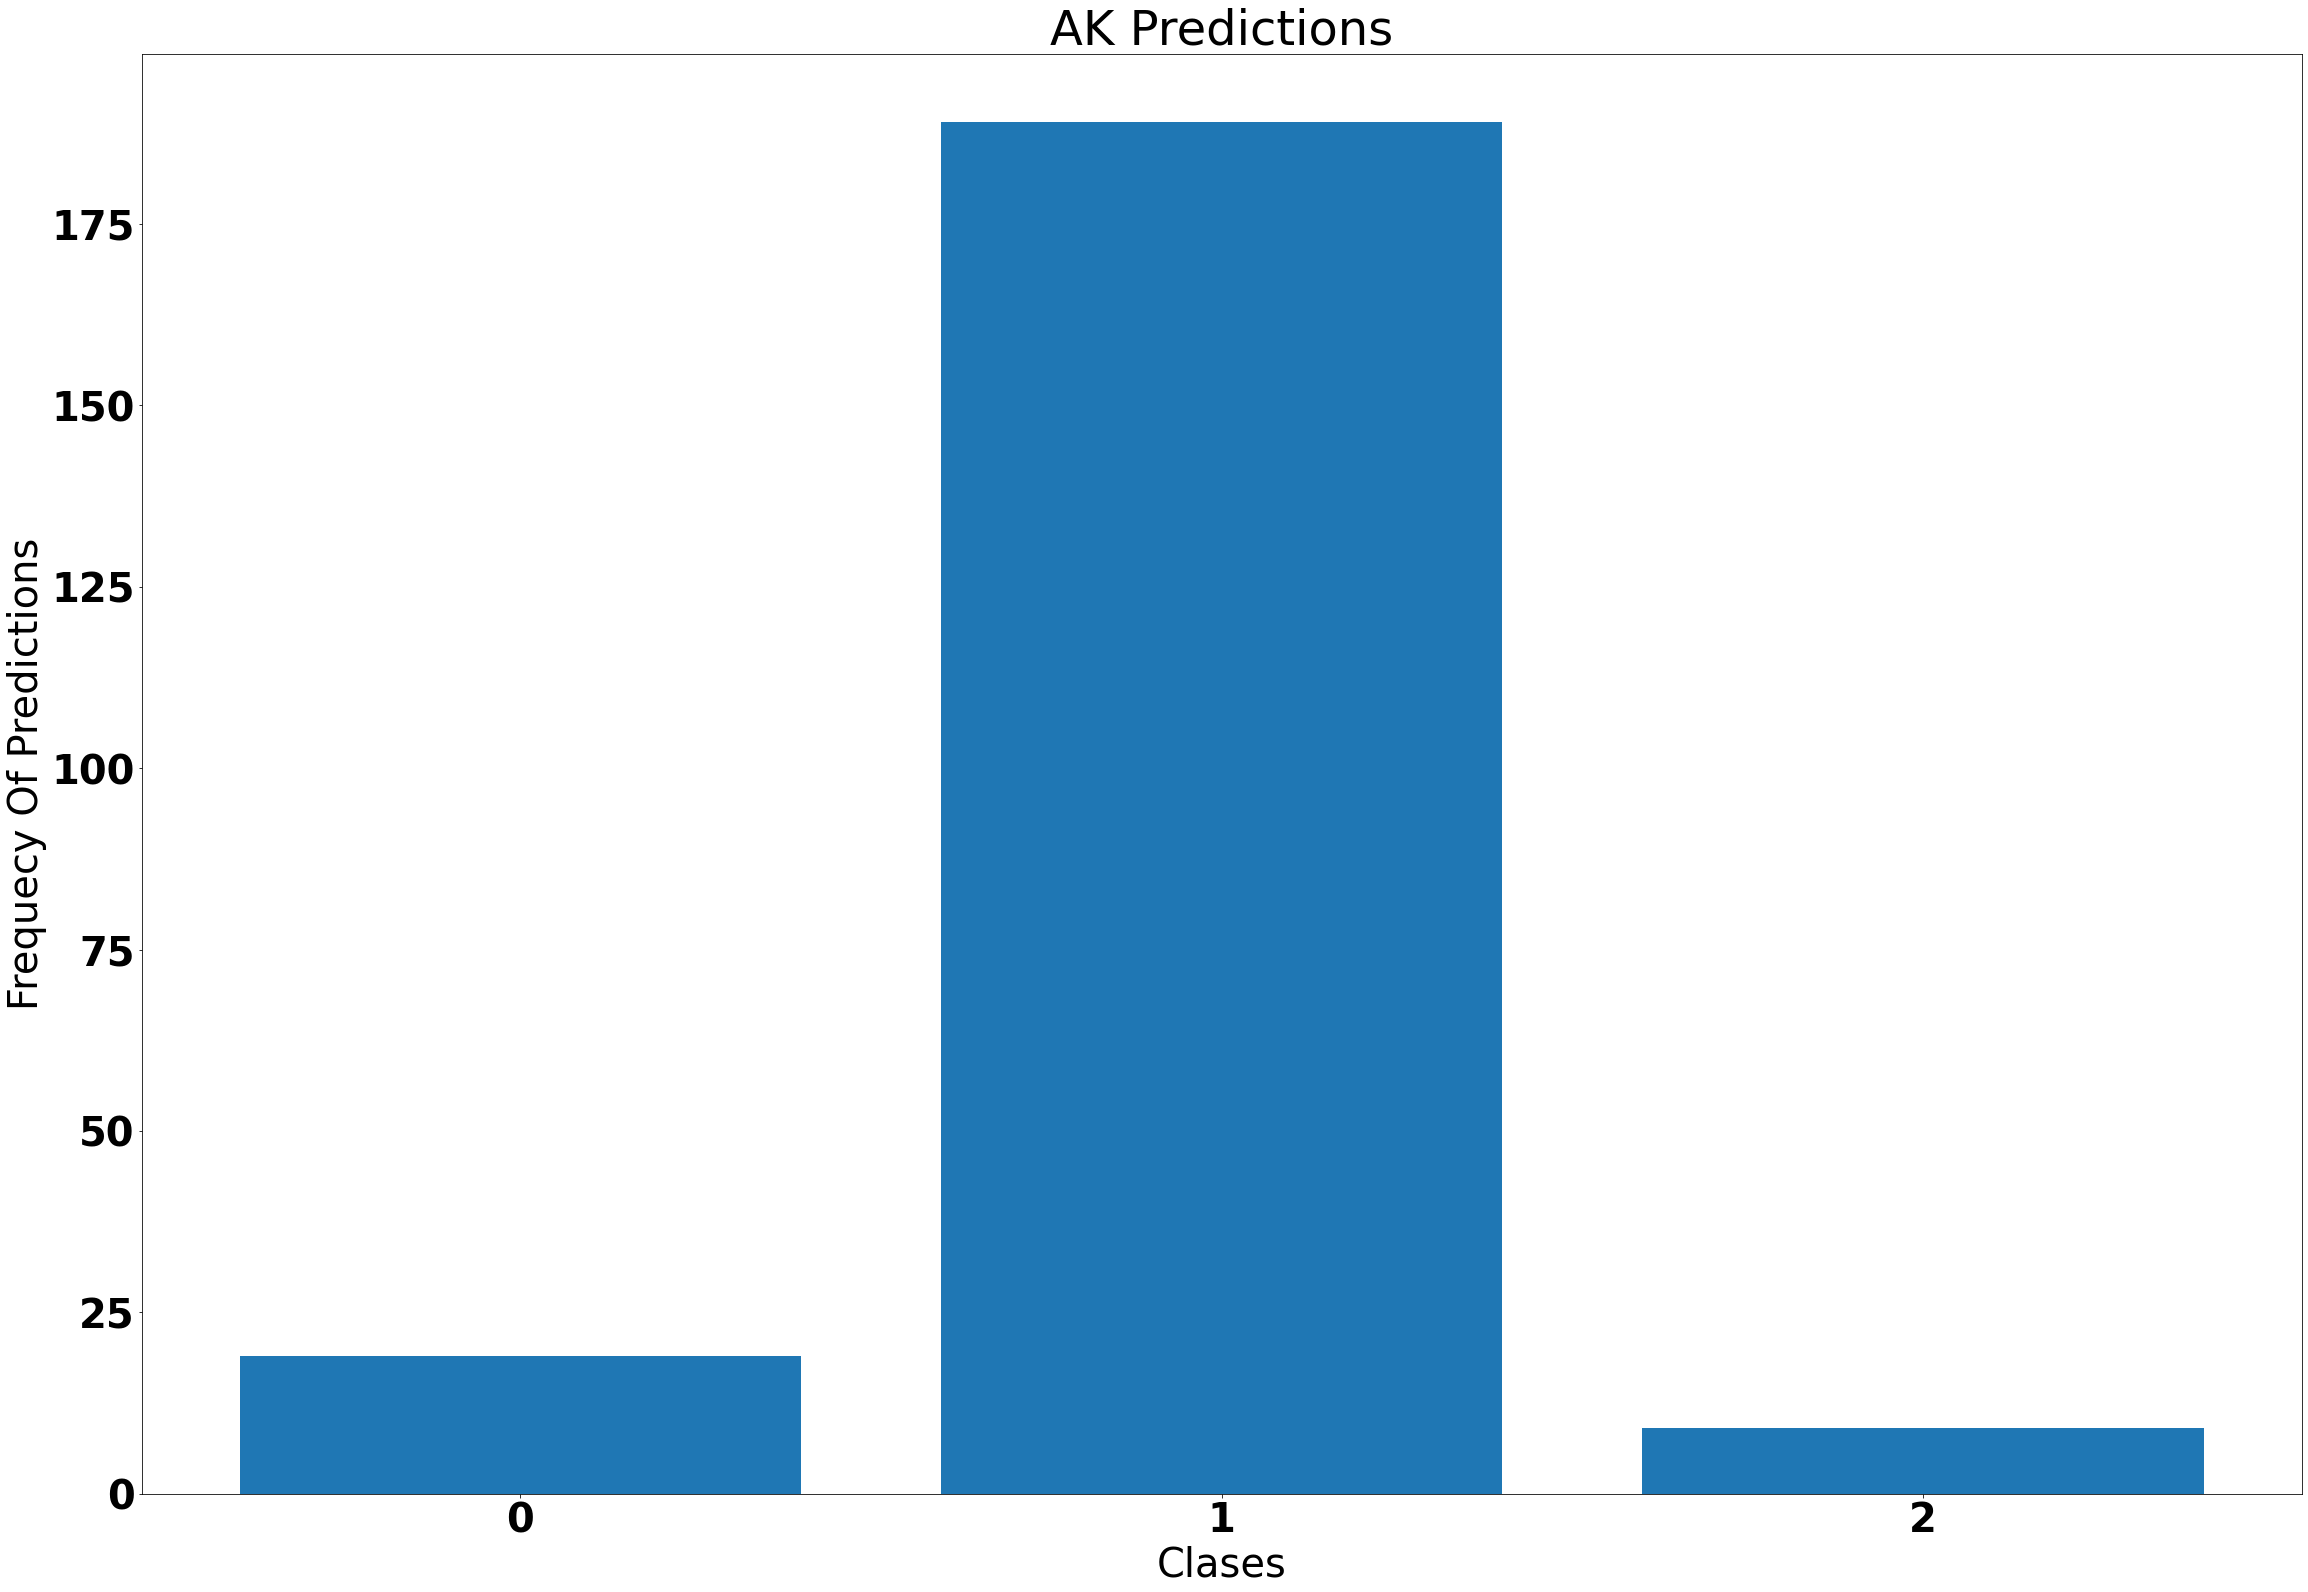

In [162]:
idx = 3
c = returnClassIndex(skin_testY_[hold_in_test_class_idx],idx)
plot_class_predictions(s_pred[c], idx,sclasses)

## Skin Disease new clases

In [163]:
hold_in_test_class = [4,5,6,7]
hold_in_test_class_idx = []
for i in hold_in_test_class:
    hold_in_test_class_idx = hold_in_test_class_idx + returnClassIndex(skin_testY_,i)

In [164]:
print("Performing Predictions")
### get Predictions
from scipy.stats import mode
MODELS = [model1,model1,model2,model3,model4]
preds = []
for m in MODELS:
    preds.append(m.predict(skin_test_feat_[hold_in_test_class_idx], verbose = 1))
p1 =np.vstack([np.argmax(p, axis = 1) for p in preds]).T
s_pred,c =mode(p1, axis = 1)
s_groundTruth = np.argmax(skin_testY_[hold_in_test_class_idx], axis = 1)

Performing Predictions
30/30 [==============================] - 0s 732us/step


In [165]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import log_loss, roc_curve

f1 = f1_score(s_groundTruth, s_pred, average = "macro")
acc = accuracy_score(s_groundTruth, s_pred)
recall = recall_score(s_groundTruth, s_pred,   average = "macro")

precision =precision_score(s_groundTruth, s_pred, average = "macro")
loss = log_loss(skin_testY_[hold_in_test_class_idx], tf.keras.utils.to_categorical(s_pred, num_classes =8 ))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))
print("F1 Score: {}".format(f1))
print("recall Score: {}".format(recall))
print("Precision Score: {}".format(precision))

Loss: 34.53877639770508
Accuracy: 0.0
F1 Score: 0.0
recall Score: 0.0
Precision Score: 0.0


/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
list(gnd_truth.columns[1:-1])[:4]

['MEL', 'NV', 'BCC', 'AK']

In [167]:
labels_names[-4:]

['MEL', 'NV', 'BCC', 'AK']

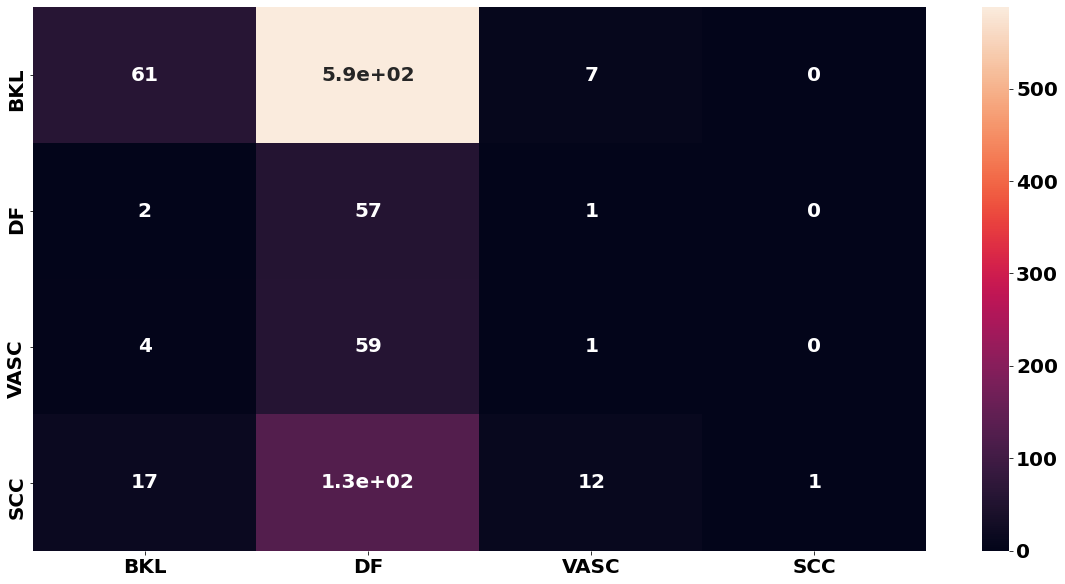

In [168]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf = tf.math.confusion_matrix(s_groundTruth-4,s_pred)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
labels_names = list(gnd_truth.columns[1:-1])[-4:]
df_cm = pd.DataFrame(np.array(conf), index = [i for i in labels_names],
                  columns = [i for i in labels_names])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('saveed_figures/en_cnn/enconf_skin_dis_newclass.png', dpi = 200)
plt.savefig('saveed_figures/en_cnn/enconf_skin_dis_newclass.pdf', dpi = 200)

/home/trex/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
<ipython-input-169-15ebbe7b1471>:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


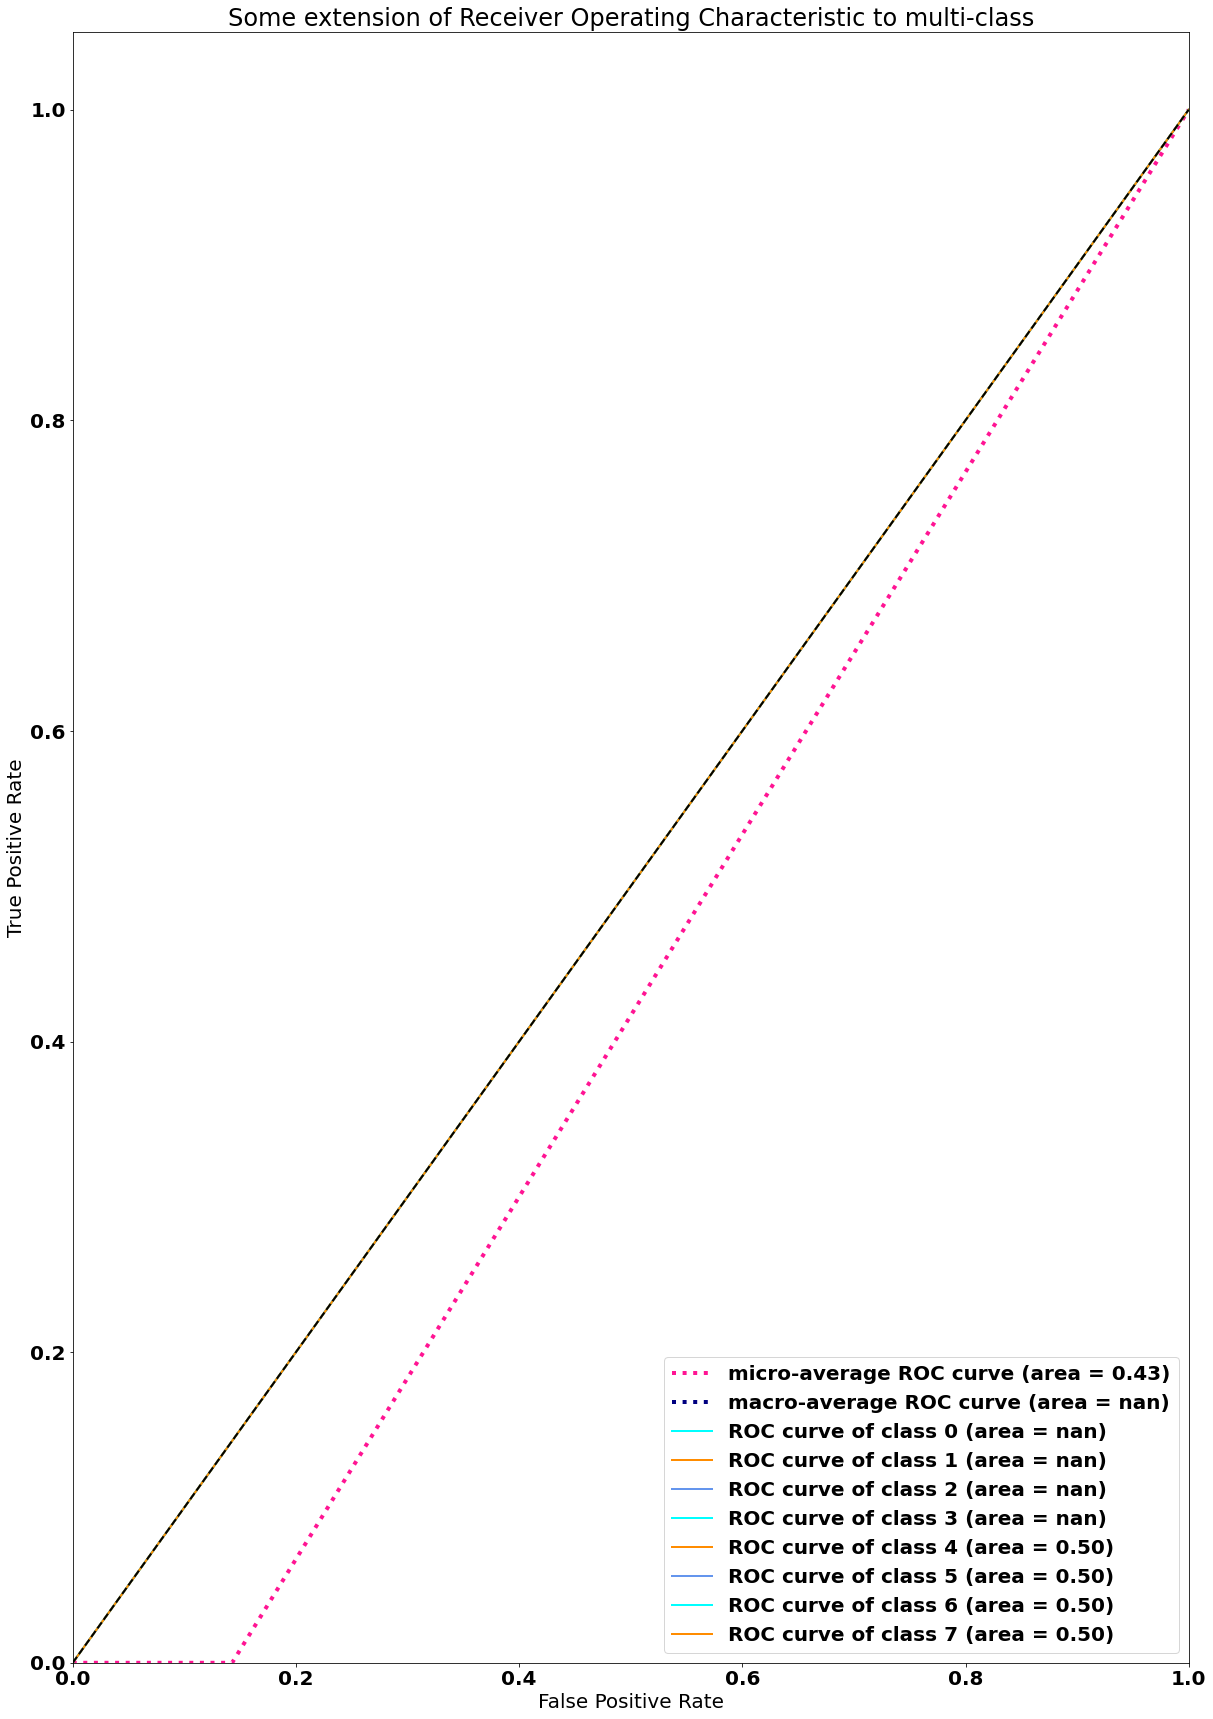

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(skin_testY_[hold_in_test_class_idx])
y_score = np.copy(tf.keras.utils.to_categorical(s_pred, num_classes =8 ))
n_classes =  8
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('saveed_figures/en_cnn/enrocf_skin_dis_newclass.png', dpi = 200)
plt.savefig('saveed_figures/en_cnn/enrocf_skin_dis_newclass.pdf', dpi = 200)
plt.show()

In [170]:
sclasses =list(gnd_truth.columns[1:-1])[:4]

Missing classes on the bar chart indicate that there are no prediction for them

Class #0


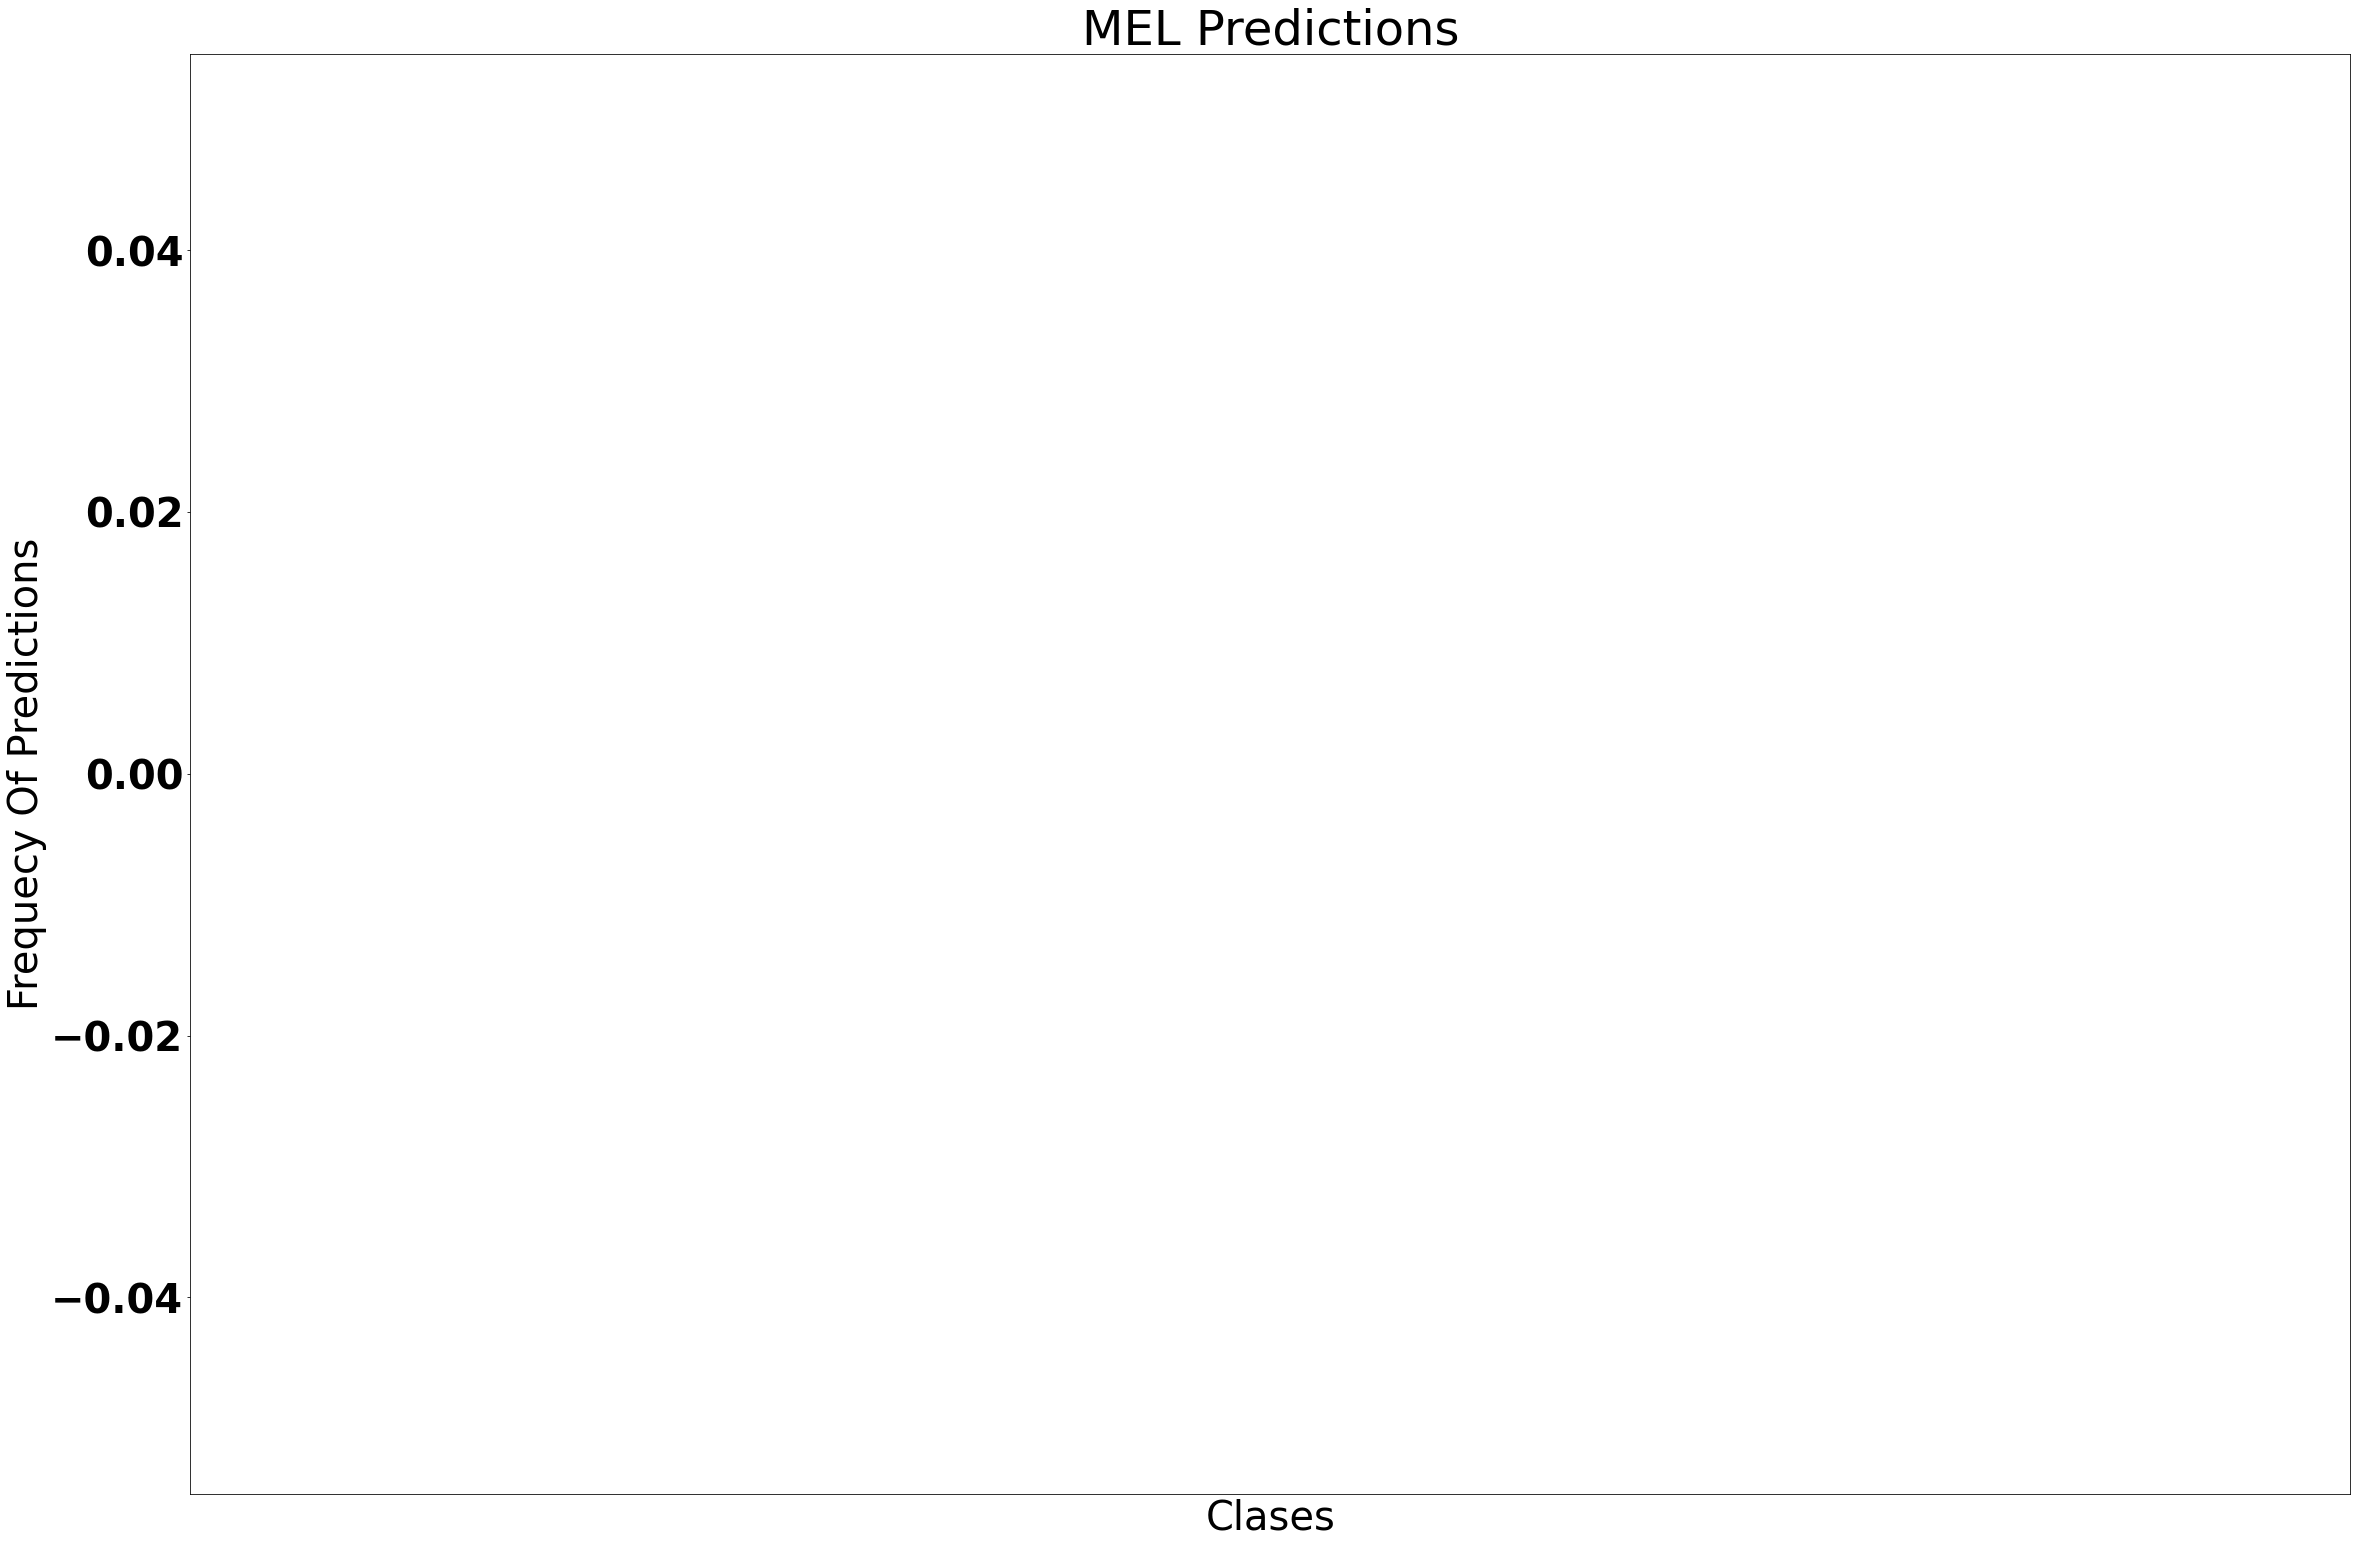

In [248]:
idx = 0
c = returnClassIndex(skin_testY_[hold_in_test_class_idx],idx)
plot_class_predictions(s_pred[c], idx,sclasses)

Class #1


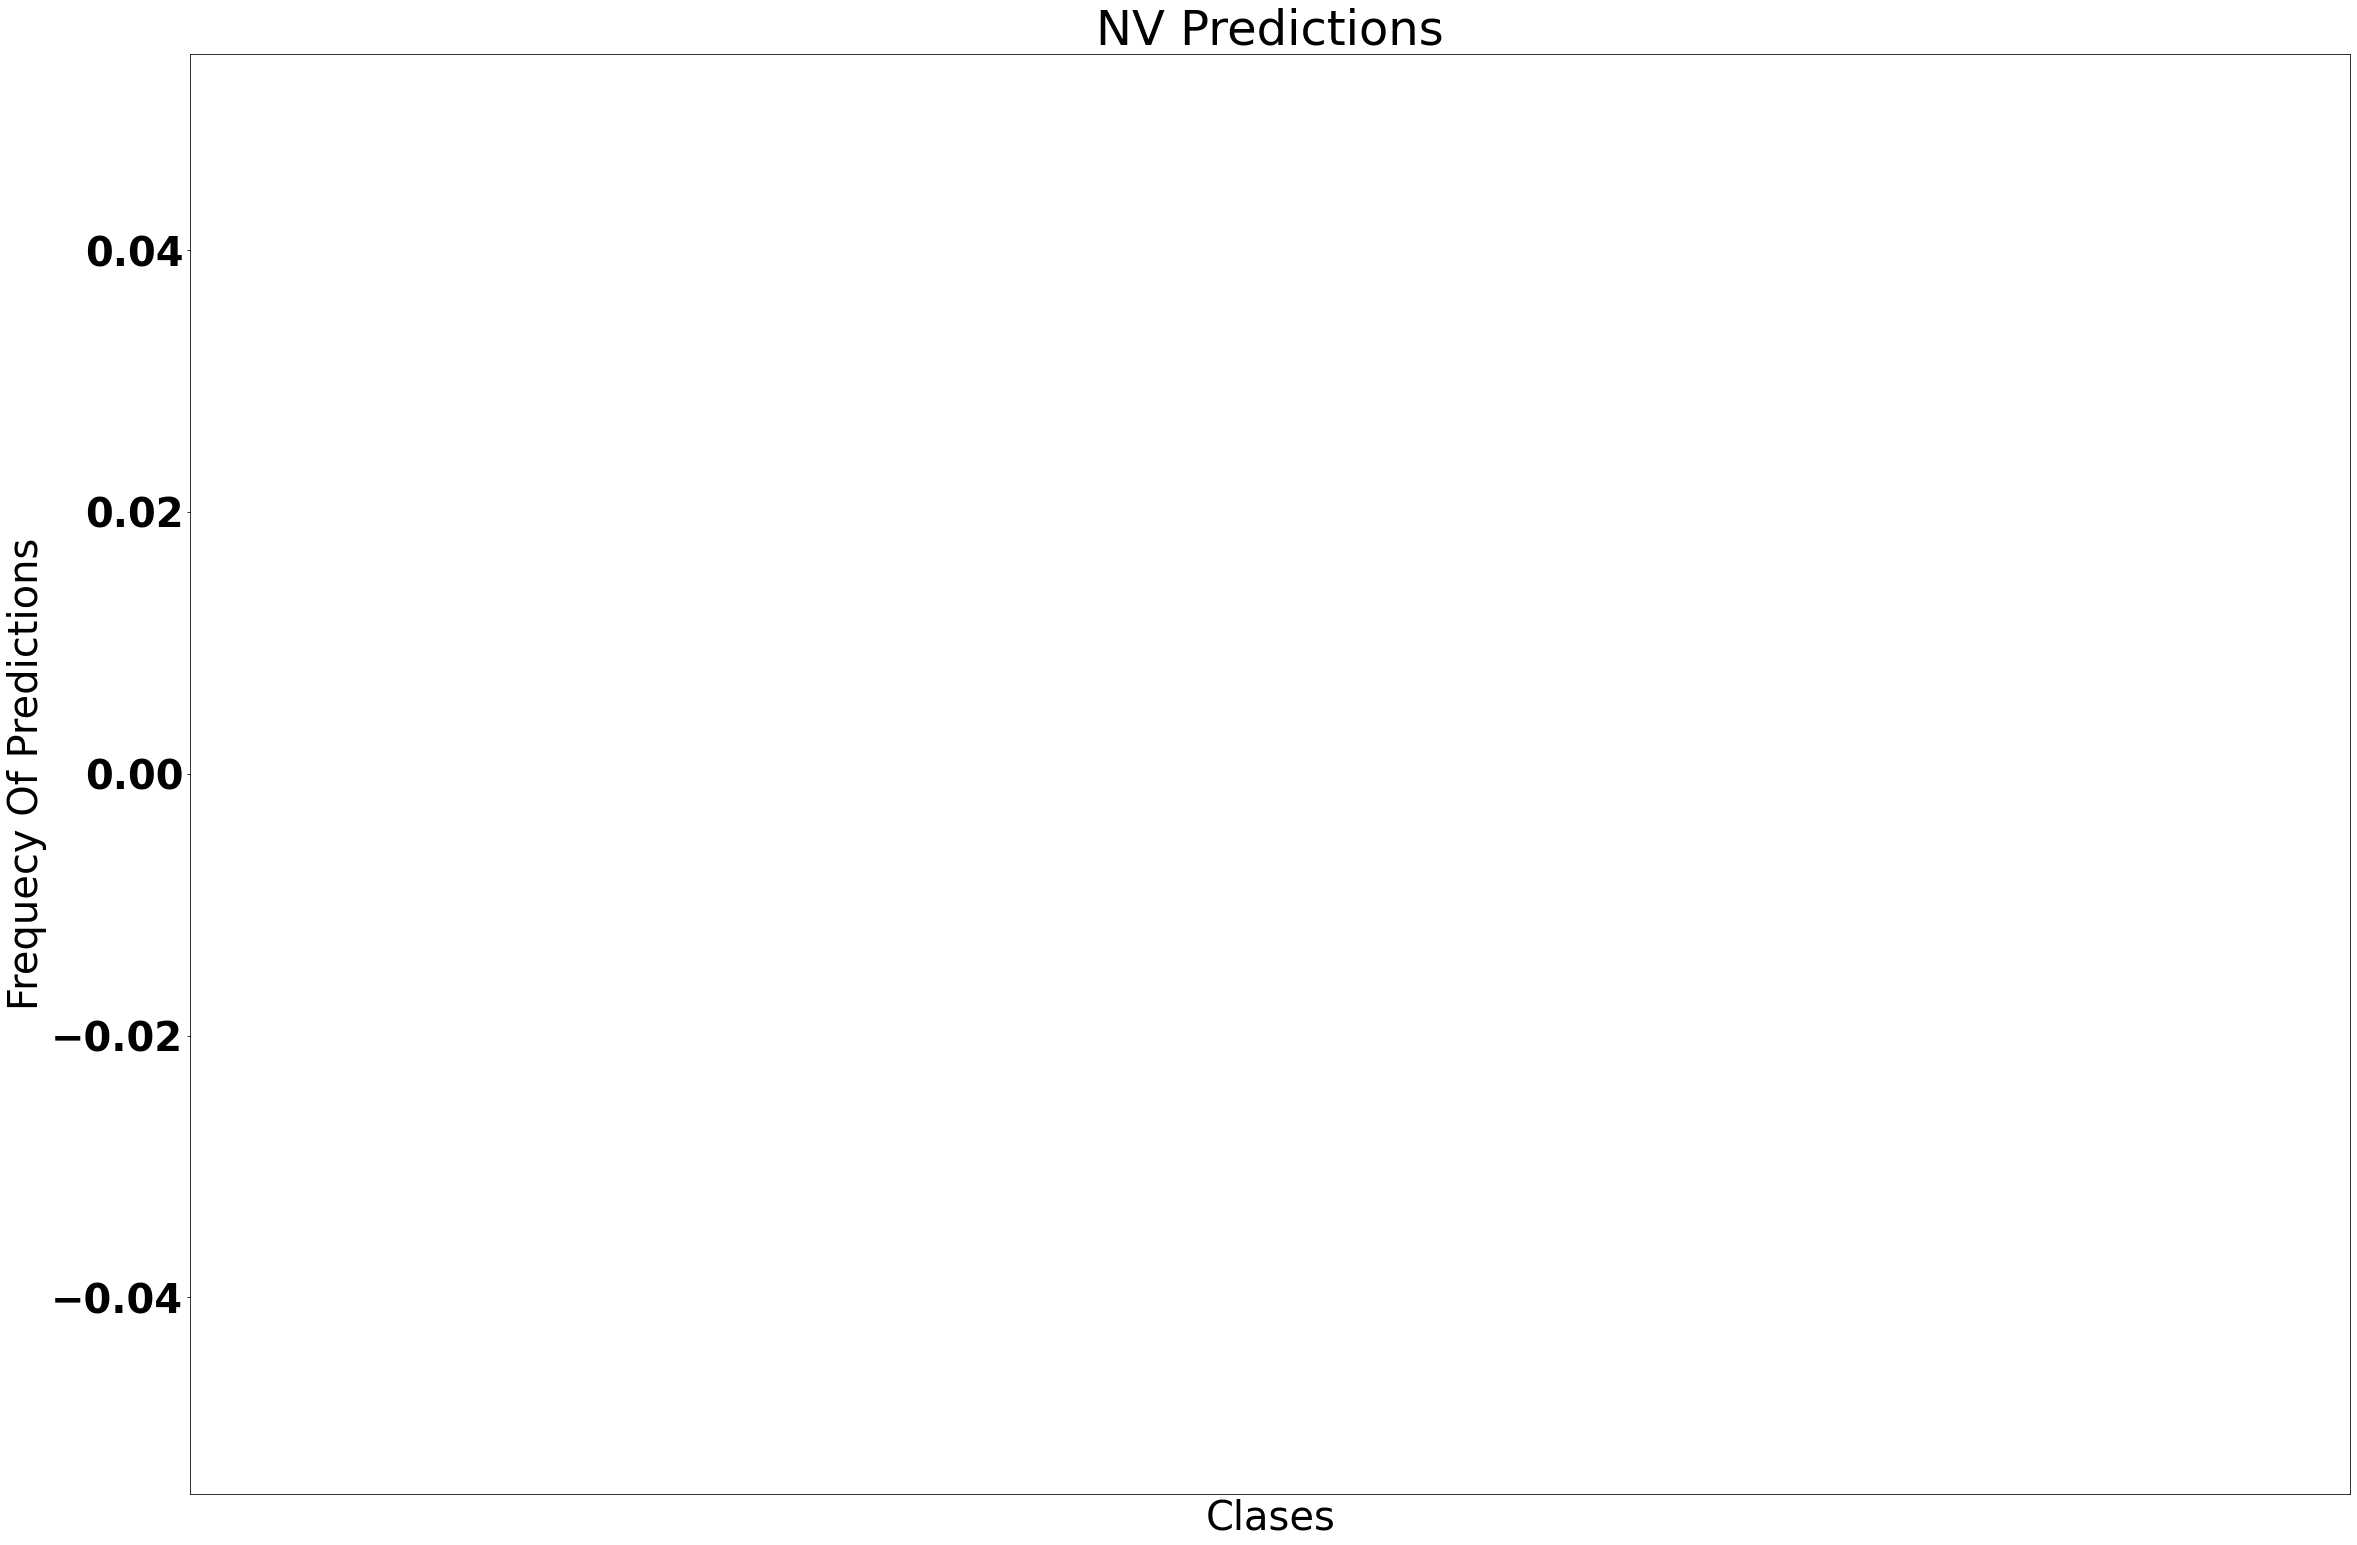

In [249]:
idx = 1
c = returnClassIndex(skin_testY_[hold_in_test_class_idx],idx)
plot_class_predictions(s_pred[c], idx,sclasses)

Class #2


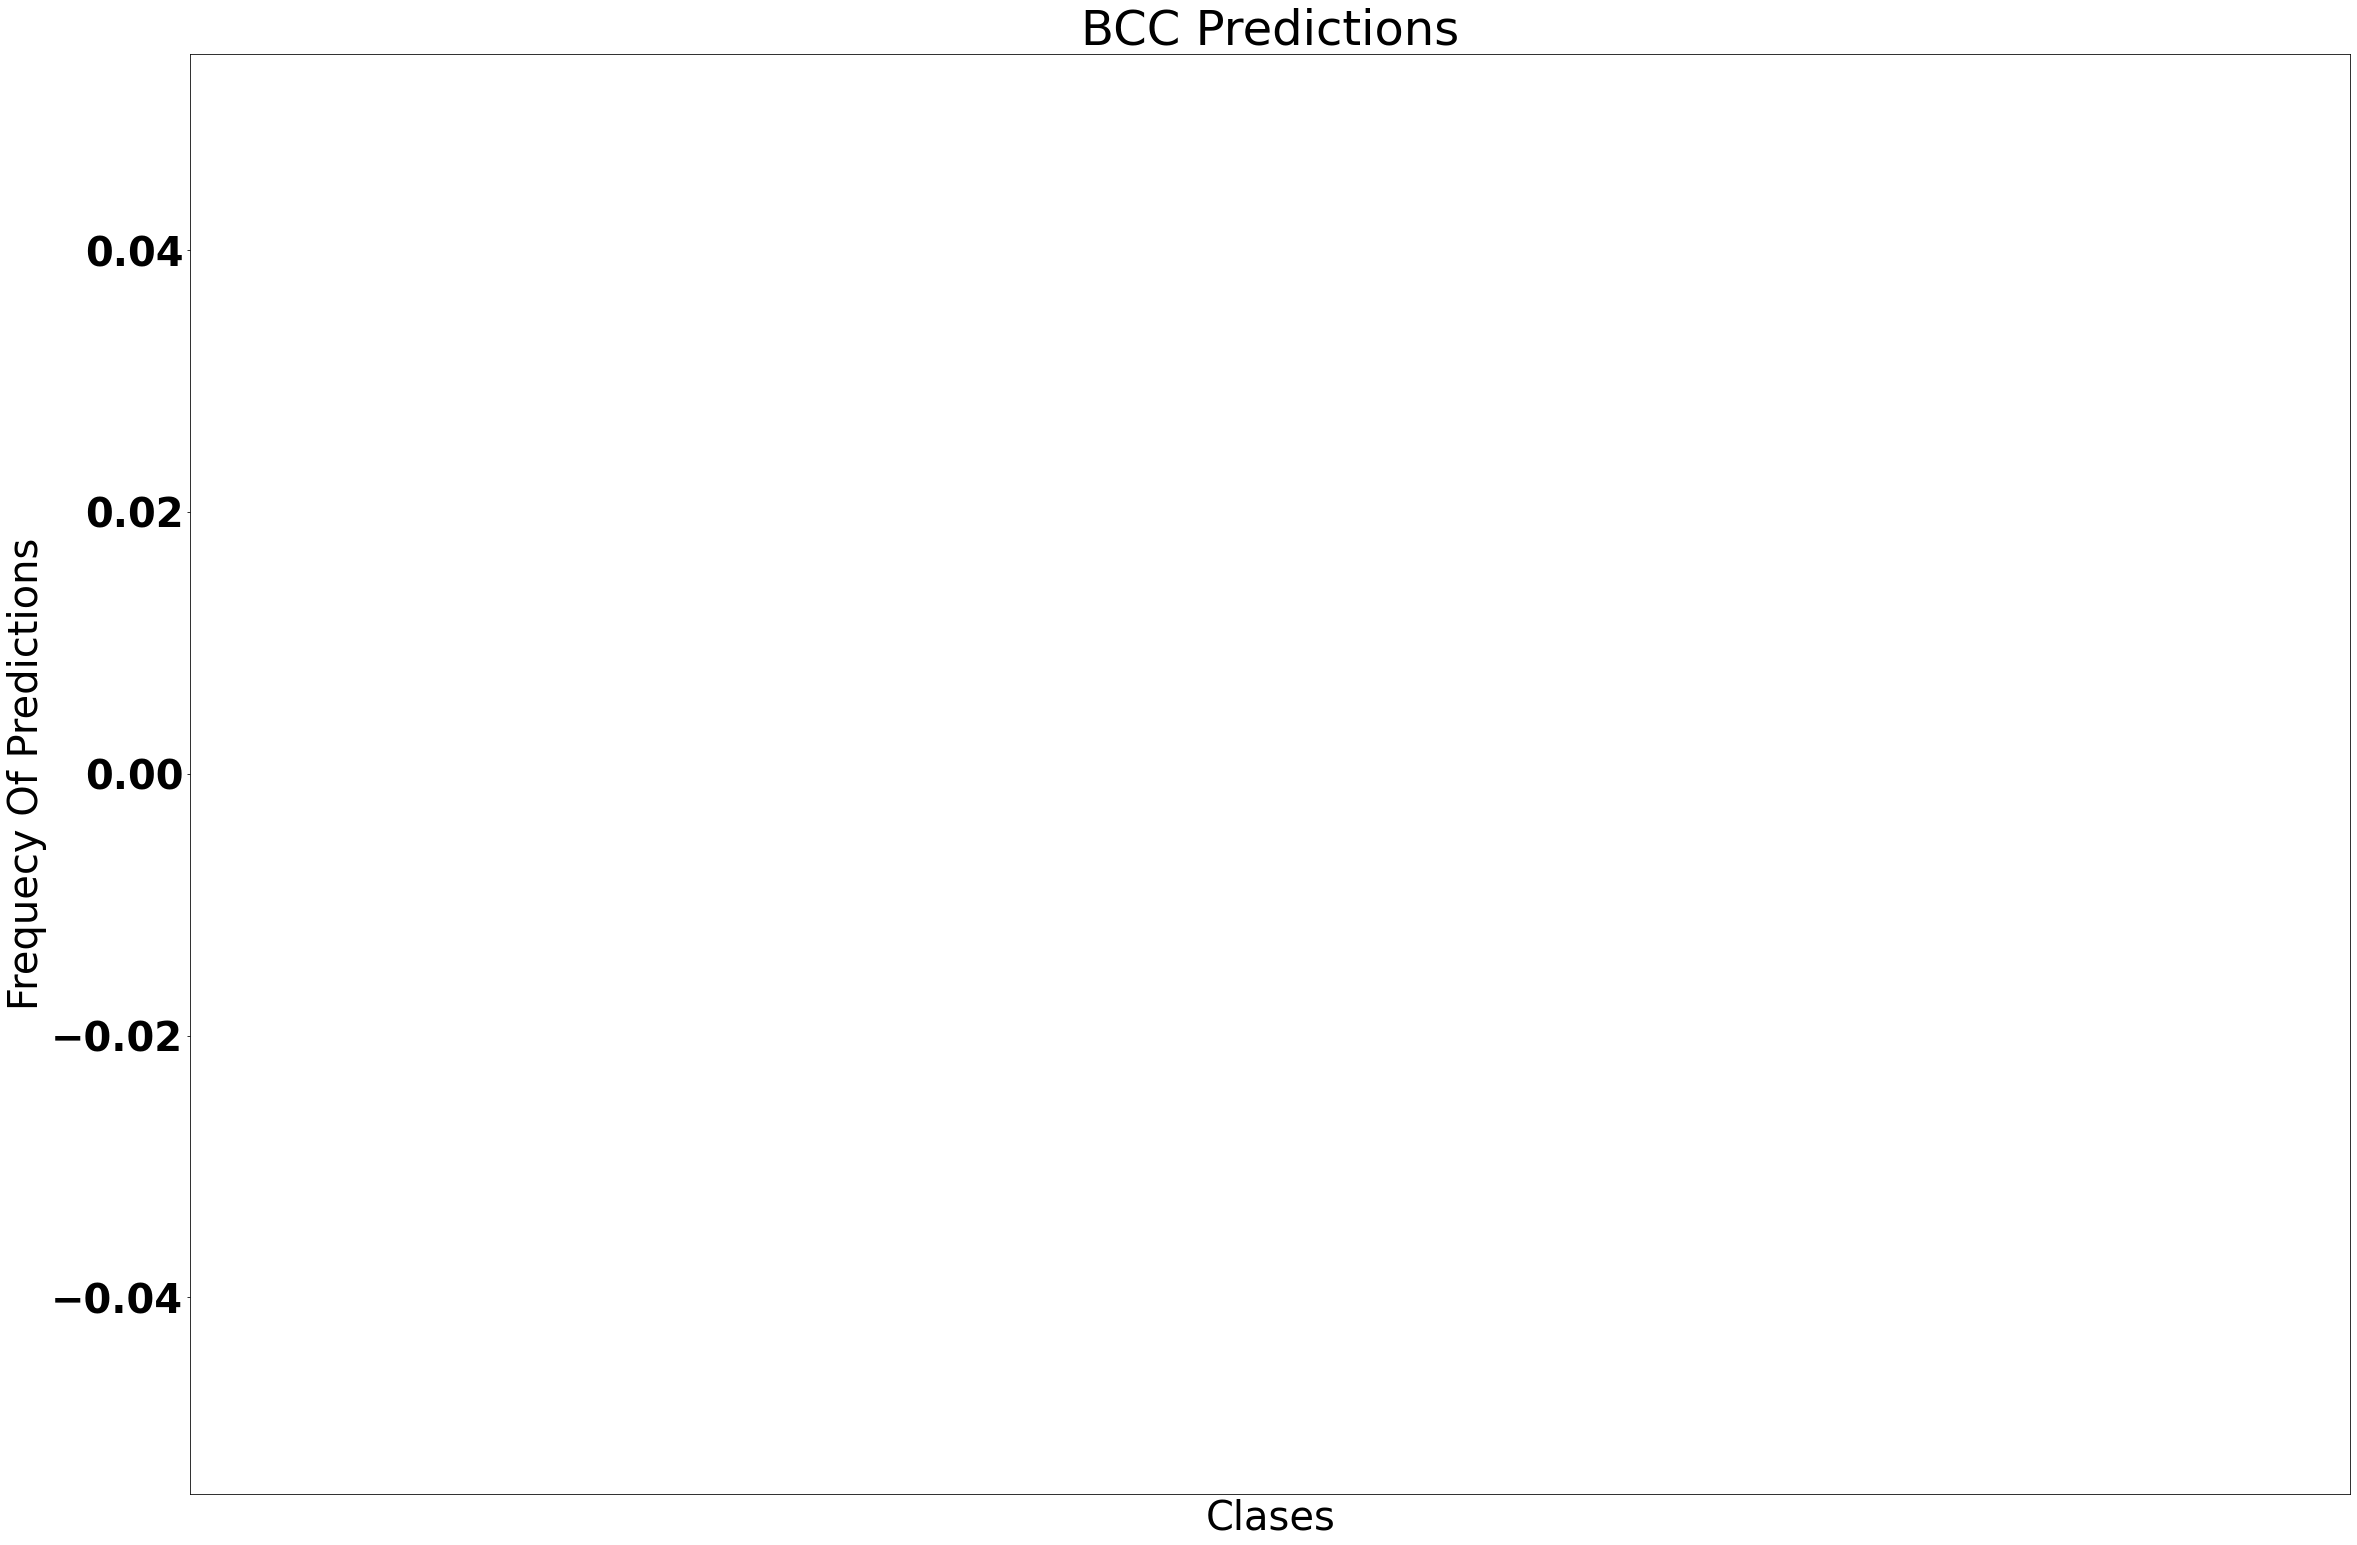

In [254]:
idx = 2
c = returnClassIndex(skin_testY_[hold_in_test_class_idx],idx)
plot_class_predictions(s_pred[c], idx,sclasses)

Class #3


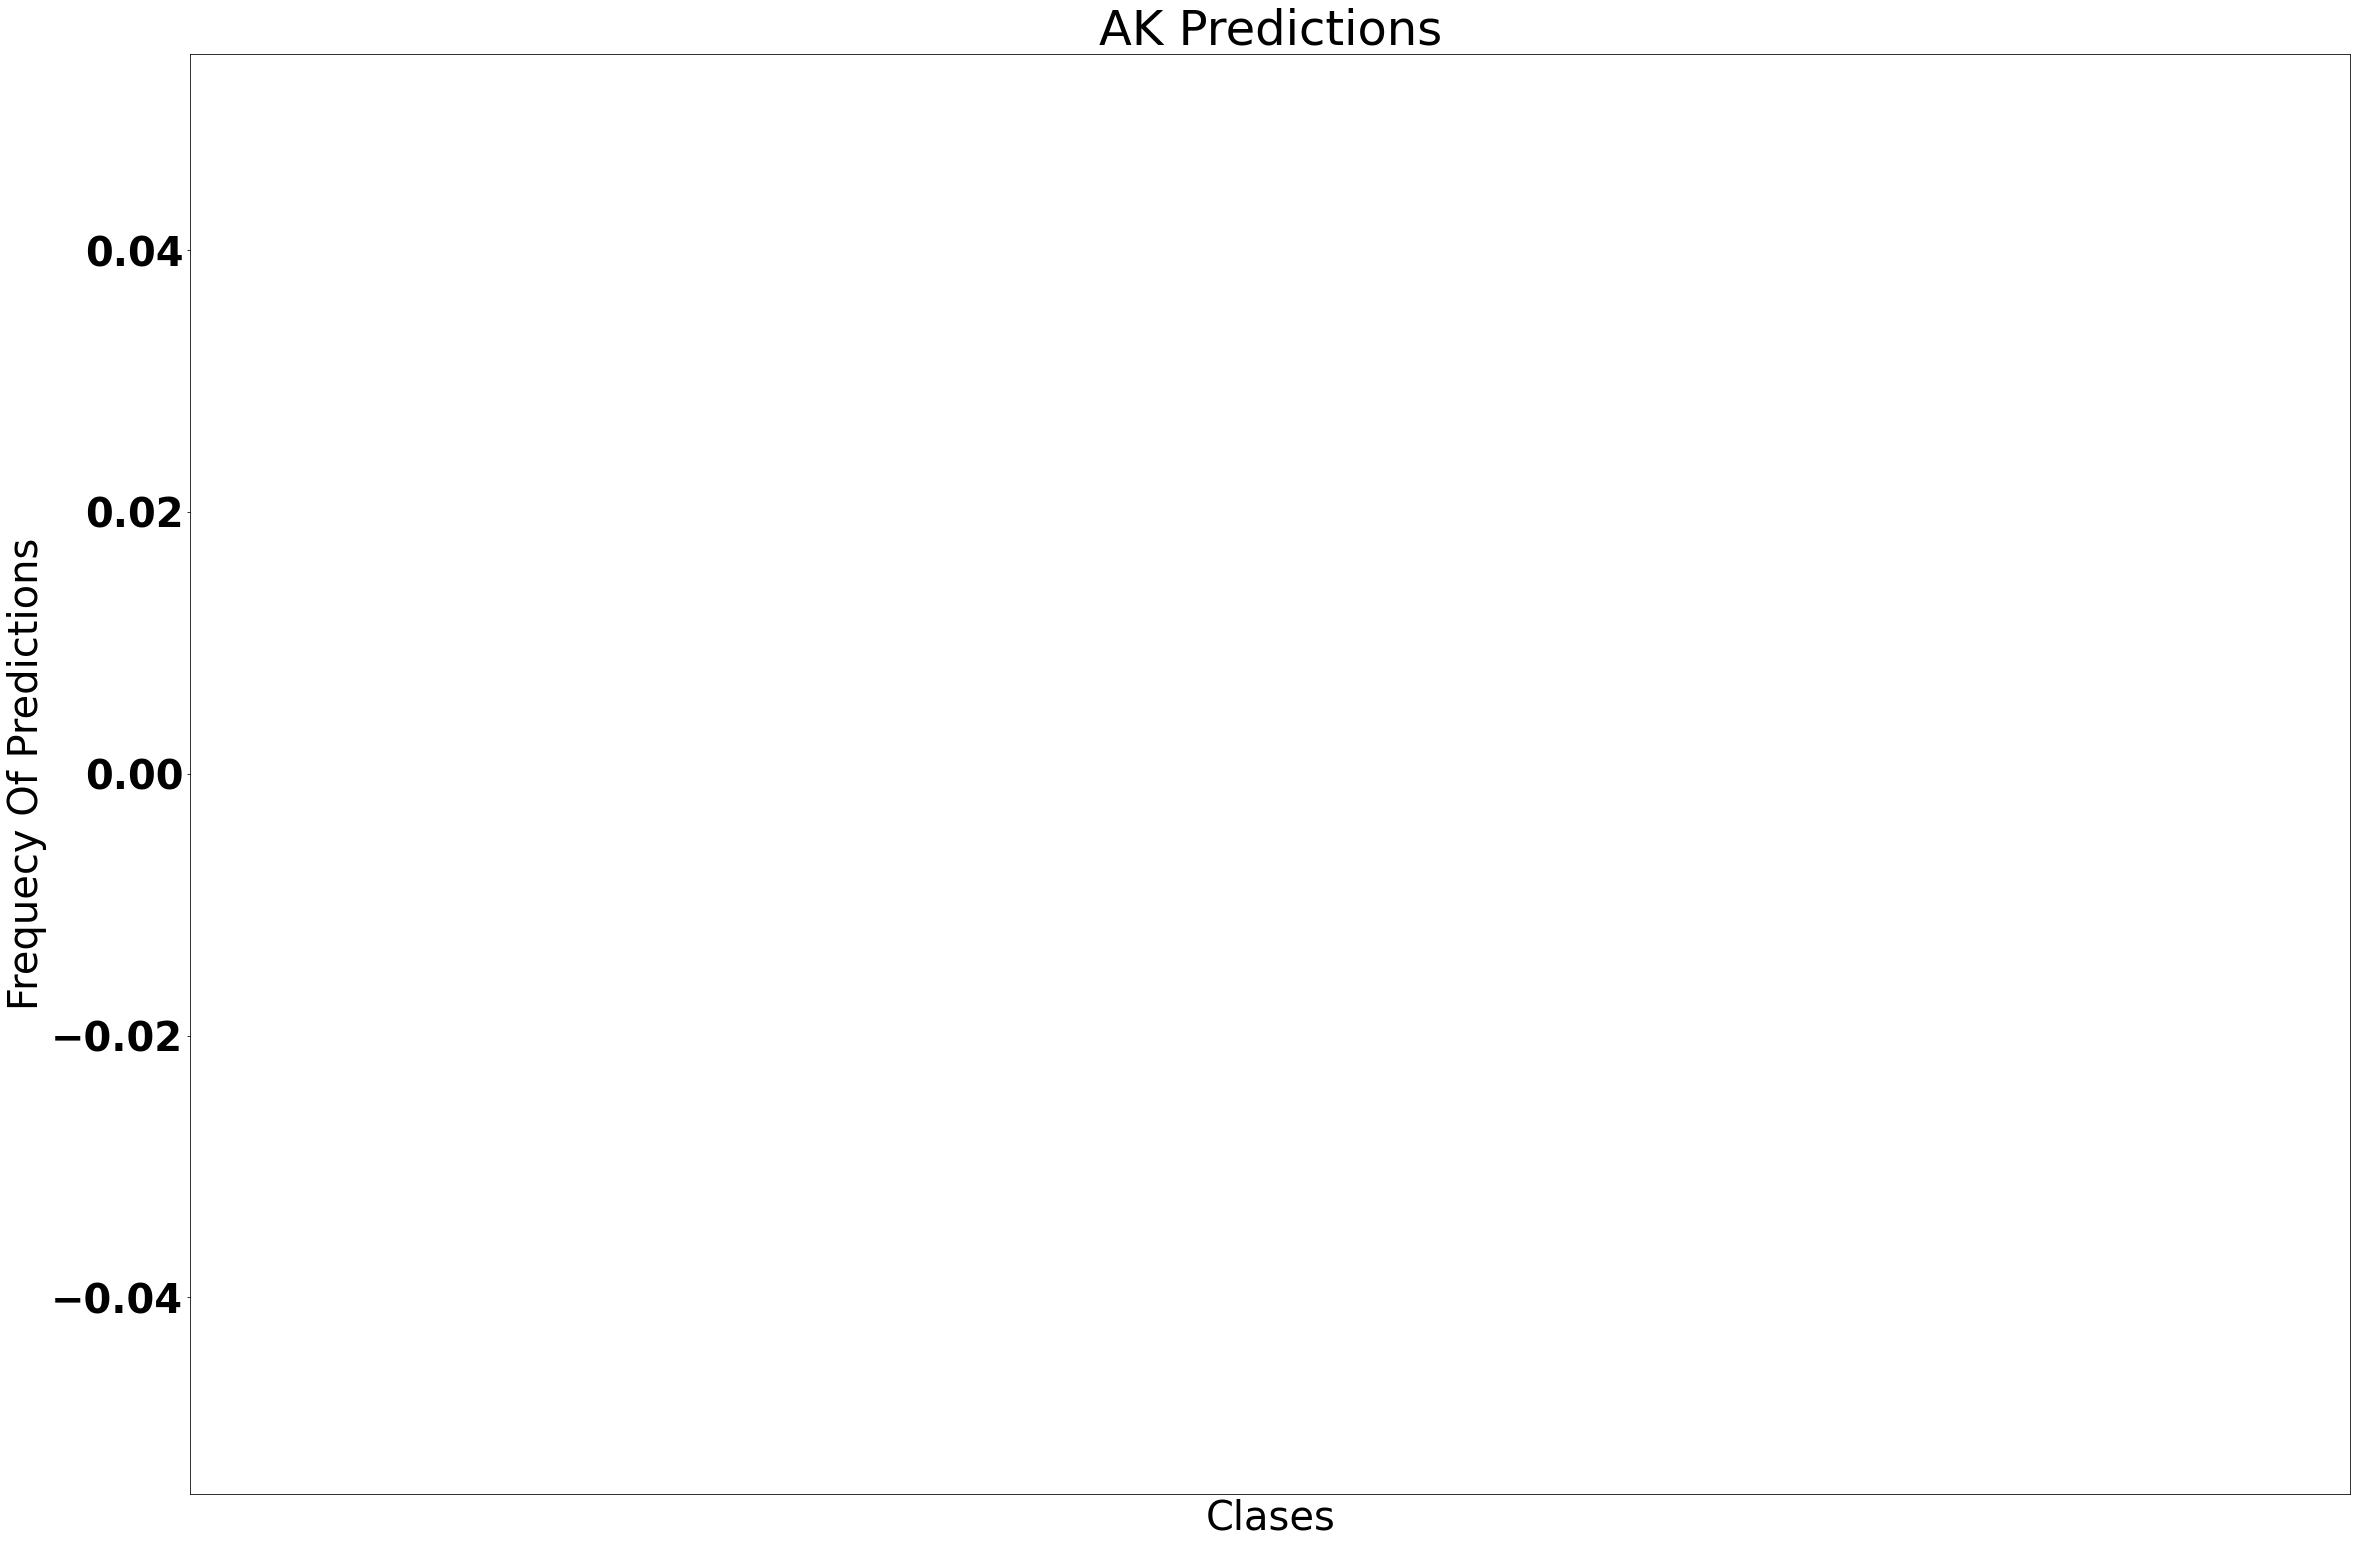

In [255]:
idx = 3
c = returnClassIndex(skin_testY_[hold_in_test_class_idx],idx)
plot_class_predictions(s_pred[c], idx,sclasses)